In this Notebook I'll try to give a visual hint of how different models for machine learning work when applied to the problem of predicting the color of a pixel in an image given its coordinates. The model is trained on a set of other pixel coordinates and colors for the same image.

This notebook requires Python 3.6 and the dependencies in `requirements.txt`. 

In [1]:
import itertools
from datetime import datetime

from matplotlib import pyplot
import numpy as np
from scipy import ndimage

def log(message, *args):
    if len(args) == 0:
        print(f'{datetime.now().isoformat()} {message}')
    else:
        print(f'{datetime.now().isoformat()} {message}', args)



In [2]:
# load and convert to uint8
photo = pyplot.imread('../data/Grant_Wood_-_American_Gothic_-_Google_Art_Project.jpg').astype(np.uint8)


Now photo is a numpy array of shape (X,Y,3), where 3 is the number of channels (R,G,B). Let's see it and the single channels

2018-09-06T09:59:55.556091 ----
2018-09-06T09:59:55.556175 Image matrix of shape (1545, 1280, 3)
2018-09-06T09:59:55.647070 min/avg/max on the channels: [0 0 0]/[103.34416212  97.49891535  76.45601992]/[255 255 246]


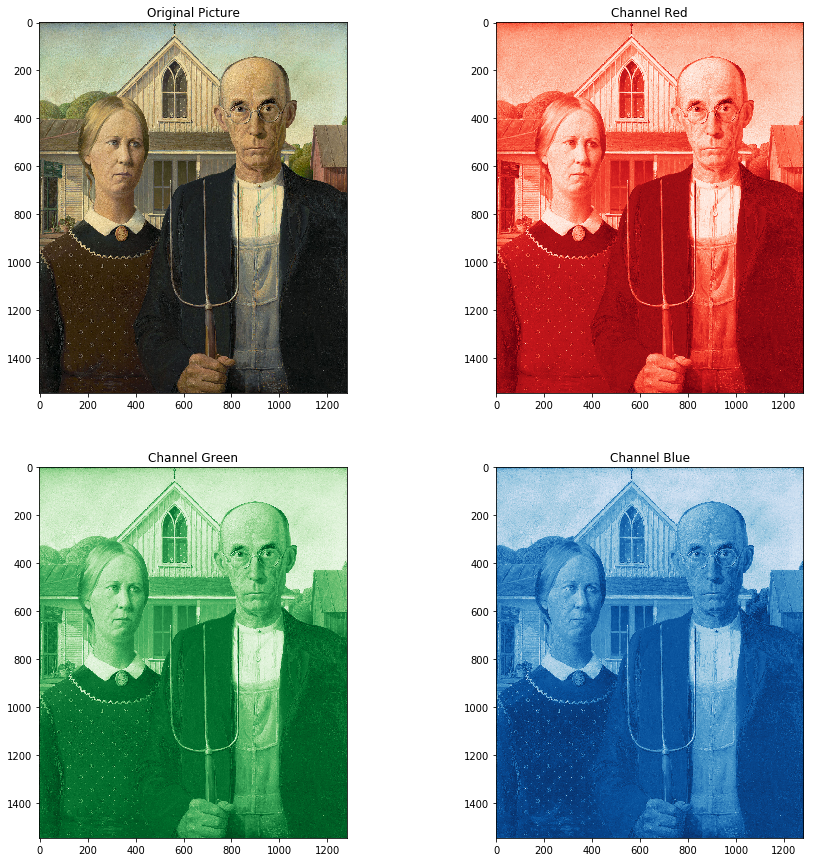

In [3]:
%matplotlib inline

def show_matrix(img_matrix):
    log('----')
    log(f'Image matrix of shape {img_matrix.shape}')
    log(f'min/avg/max on the channels: {np.min(img_matrix,axis=(0,1))}/{np.average(img_matrix,axis=(0,1))}/{np.max(img_matrix,axis=(0,1))}')
    # create a 2x2 plot area. Note: figsize is in inches, not pixels!
    fig, axes = pyplot.subplots(nrows=2, ncols=2, figsize=(15, 15))
    ax0, ax1, ax2, ax3 = axes.flatten()

    # display the image as whole and the 3 channels
    # imshow uses the 3 (or 4 for alpha) channels if the dimension is present, otherwise a colormap
    # some color maps are already defined ane named
    # the suffix _r is used to get the reverse scale, which represent in white the presence of the color
    ax0.imshow(img_matrix)
    ax0.set_title('Original Picture')
    for i, channel in enumerate(zip(axes.flatten(), [None, 'Reds_r','Greens_r','Blues_r'])):
        if channel[1] is None:
            continue
        channel[0].set_title('Channel ' + channel[1][:-3])
        channel[0].imshow(img_matrix[:,:,i-1], cmap=pyplot.get_cmap(channel[1]))

show_matrix(photo)

Let's extract the test and training datasets, in a format that libraries like. We don't care about a dev test because the execution will be one shot.

In [4]:
def extract_dataset(image, train_size=800, test_size=200, seed=0):
    np.random.seed(seed)
    coordinates_set = set()
    for i in range(train_size + test_size):
        x, y = np.random.randint(image.shape[0]), np.random.randint(image.shape[1])
        while (x,y) in coordinates_set:
            x, y = np.random.randint(image.shape[0]), np.random.randint(image.shape[1])
        coordinates_set.add((x,y))
    
    all_coordinates= [x for x in coordinates_set]
    X_train = np.array(all_coordinates[:train_size])
    X_test = np.array(all_coordinates[train_size:])
    # NOTE: use indexes to grab RGB values?
    # It requires broadcasting and the dimension is the trailing one, maybe transpose and use it?
    # Y_train = [image[x[0], x[1], :] for x in X_train]
    Y_train = np.zeros((X_train.shape[0], 3))
    for i,x in enumerate(X_train):
        Y_train[i] = image[x[0], x[1], :]
    Y_test = np.zeros((X_test.shape[0], 3))
    for i,x in enumerate(X_test):
        Y_test[i] = image[x[0], x[1], :]
    return X_train, Y_train, X_test, Y_test


log(extract_dataset(photo, train_size=2, test_size=10))
    
    

2018-09-06T09:59:57.104377 (array([[976, 755],
       [684, 559]]), array([[ 31.,  37.,  37.],
       [108., 106.,  91.]]), array([[1420,  314],
       [ 777,  115],
       [ 277,  599],
       [  87,  174],
       [1094,  600],
       [ 849,  537],
       [ 705,  551],
       [ 845,   72],
       [1216,  835],
       [ 763, 1033]]), array([[ 51.,  34.,  16.],
       [206., 186., 136.],
       [ 96.,  90.,  66.],
       [169., 182., 164.],
       [ 24.,  30.,  30.],
       [ 25.,  26.,  28.],
       [ 87.,  87.,  75.],
       [ 63.,  62.,  34.],
       [ 82.,  84.,  83.],
       [ 38.,  38.,  28.]]))


Let's start with a linear model. This assumes that the X,Y coordinates can be mapped to the three R,G,B values by a linear function. This is true only if our image is a gradient on each channel, so the result is expected to be very bad.

In [5]:
from sklearn import linear_model

X_train, Y_train, X_test, Y_test = extract_dataset(photo)
model = linear_model.LinearRegression(n_jobs=-1)
model.fit(X_train, Y_train)
log('the score on the test set is:', model.score(X_test, Y_test))
log('the score on the train set is:', model.score(X_train, Y_train))


2018-09-06T09:59:57.633900 the score on the test set is: (0.6310951309812427,)
2018-09-06T09:59:57.635241 the score on the train set is: (0.5682487879348017,)


/Users/jacopo/.scientific_jupyter/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


Let's see the image predicted

2018-09-06T10:00:00.791360 ----
2018-09-06T10:00:00.791463 Image matrix of shape (1545, 1280, 3)
2018-09-06T10:00:00.890178 min/avg/max on the channels: [17  4  0]/[103.87266383  97.89419043  78.17946551]/[191 191 255]


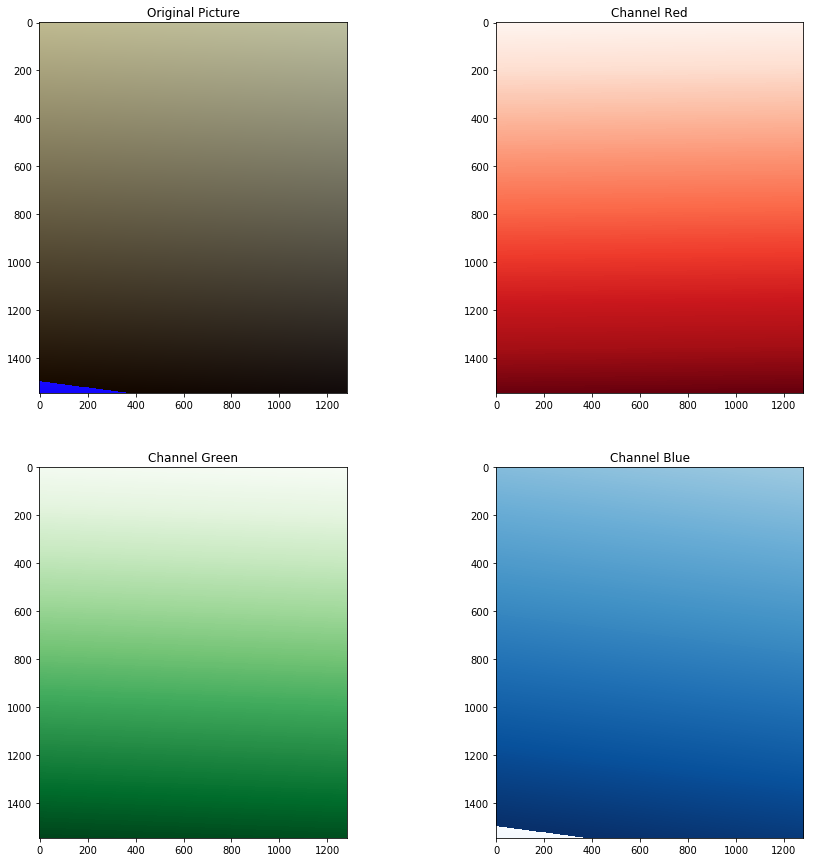

In [6]:
predict = np.zeros(photo.shape)

all_coordinates = np.array(list(itertools.product(np.arange(photo.shape[0]), np.arange(photo.shape[1]))))
all_results = model.predict(all_coordinates).astype(int)

for x in range(all_coordinates.shape[0]):
    predict[all_coordinates[x,0], all_coordinates[x,1]] = all_results[x]
show_matrix(predict.astype(np.uint8))

Not exactly similar to the original :) To be sure, let's see what happens if the image *is* a gradient. We expect in this case for the model to predict it quite well.

2018-09-06T10:00:02.083483 ----
2018-09-06T10:00:02.083574 Image matrix of shape (1280, 1280, 3)
2018-09-06T10:00:02.160988 min/avg/max on the channels: [111 176 178]/[164.5680188  198.74476929 187.00871094]/[211 221 203]
2018-09-06T10:00:02.309479 the score on the test set is: (0.9643974987097192,)
2018-09-06T10:00:02.310900 the score on the train set is: (0.9662055742342966,)
2018-09-06T10:00:03.110263 for the point (0, 0) the model predicts colors [[227.12266554 172.18817477 186.03861237]]
2018-09-06T10:00:03.110806 for the point (200, 200) the model predicts colors [[207.55045692 180.49927221 186.33101682]]
2018-09-06T10:00:03.111016 for the point (1280, 1280) the model predicts colors [[101.86053038 225.3791984  187.91000084]]
2018-09-06T10:00:03.206037 at coordinates [2 2] the result is [226.92694345 172.27128574 186.04153642], which become [226 172 186]
2018-09-06T10:00:03.206230 the value in the output matrix is [226.92694345 172.27128574 186.04153642]
2018-09-06T10:00:24.94362

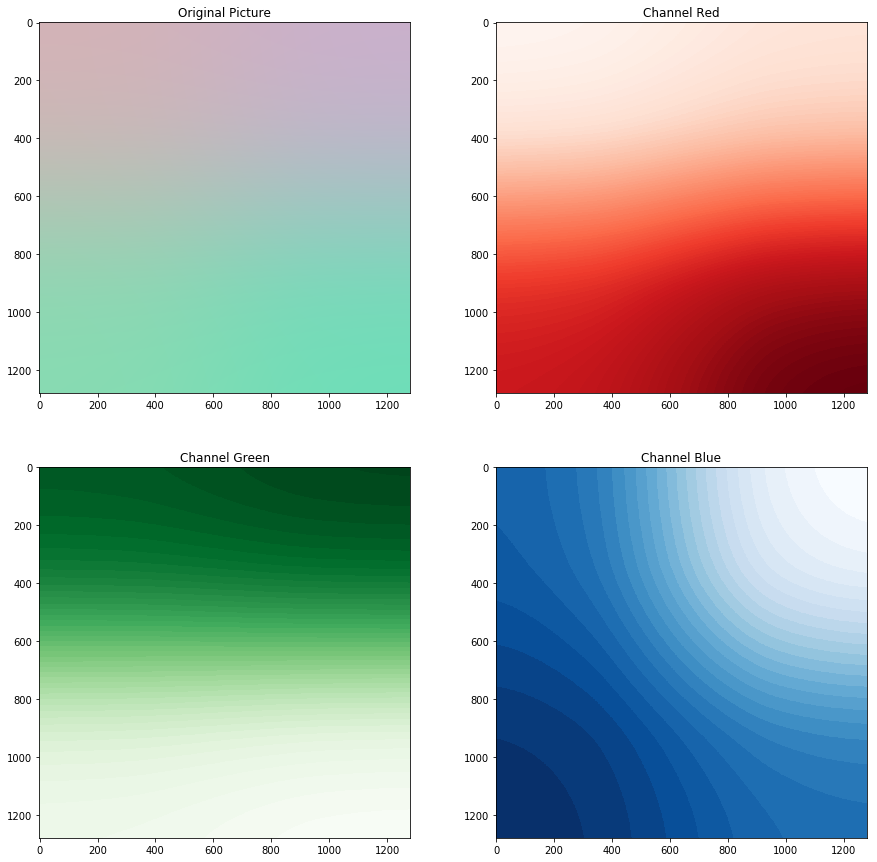

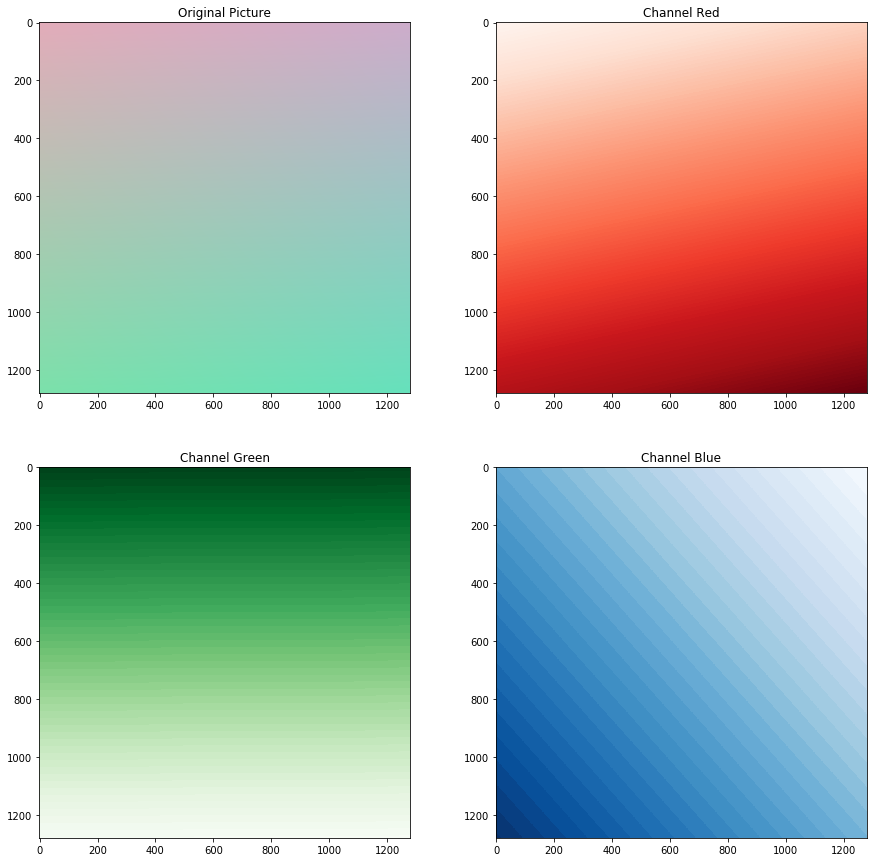

In [7]:
photo_gradient = (pyplot.imread('../data/a_gradient.png') * 255).astype(np.uint8)
show_matrix(photo_gradient)
X_train_gradient, Y_train_gradient, X_test_gradient, Y_test_gradient = extract_dataset(photo_gradient, train_size=2000, test_size=200)
model_gradient = linear_model.LinearRegression(n_jobs=-1)
model_gradient.fit(X_train_gradient, Y_train_gradient)
log('the score on the test set is:', model_gradient.score(X_test_gradient, Y_test_gradient))
log('the score on the train set is:', model_gradient.score(X_train_gradient, Y_train_gradient))

predict = np.zeros(photo_gradient.shape)
all_coordinates = np.array(list(itertools.product(np.arange(photo_gradient.shape[0]), np.arange(photo_gradient.shape[1]))))
# let's see the prediction at some points. Note that the model gives prediction for every coordinate, it has no information about the boundaries
sample_points = [(0,0), (200, 200), (1280, 1280)]
for sp in sample_points:
    log(f'for the point {sp} the model predicts colors {model_gradient.predict([[sp[0], sp[1]]])}')
all_results = model_gradient.predict(all_coordinates)

for x in range(all_coordinates.shape[0]):
    predict[all_coordinates[x,0], all_coordinates[x,1]] = all_results[x]
    
    if (all_coordinates[x] == [2, 2]).all() or (all_coordinates[x] == [1279, 1279]).all():
        log(f'at coordinates {all_coordinates[x]} the result is {all_results[x]}, which become {all_results[x].astype(np.uint8)}')
        log(f'the value in the output matrix is {predict[all_coordinates[x][0], all_coordinates[x][1]]}')
show_matrix(predict.astype(np.uint8))

Interestingly, the original image had an artifact (best visible on the blue channel), that now has changed since it was not linear and the model couldn't model it, but the output was later subject to quantization.
A possibility to improve the result without abandoning the linear model is to add "fake" dimensions obtained as a non-linear transformation of existing ones. This way the model will use those as well for the input. This is known as *kernel trick* and scikitlearn provides a few functions to apply it, based on the statistical properties of input data. But for fun let's try with something simple to see what happens.

For each coordinate we can add the distances of that point to a grid of reference coordinates


Try with a Decision Tree, which builds a tree of binary choices.

2018-09-06T10:00:32.183449 ----
2018-09-06T10:00:32.183591 Image matrix of shape (1545, 1280, 3)
2018-09-06T10:00:32.313351 min/avg/max on the channels: [0 1 0]/[103.73439927  98.01126669  77.2342056 ]/[250 232 208]


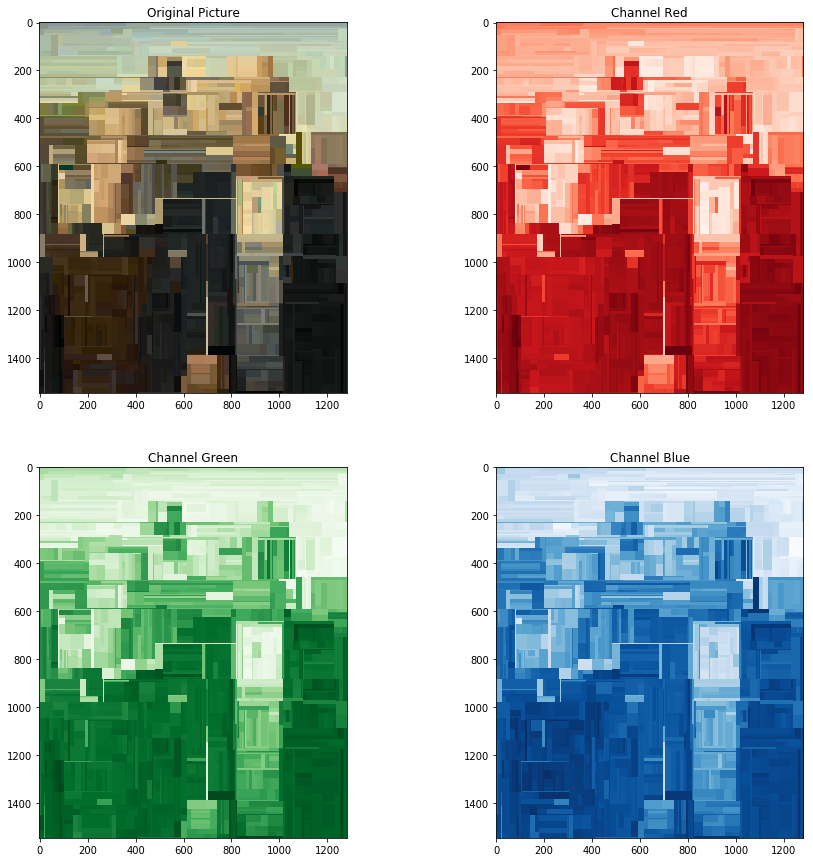

In [8]:
from sklearn import tree



X_train, Y_train, _, _ = extract_dataset(photo, train_size=2000, test_size=0)


tree_model = tree.DecisionTreeRegressor()
tree_model.fit(X_train, Y_train)

predicted = np.zeros((photo.shape[0], photo.shape[1], 3))


all_coordinates = np.array(list(itertools.product(np.arange(predicted.shape[0]), np.arange(predicted.shape[1]))))

all_results = tree_model.predict(all_coordinates)

for x in range(all_coordinates.shape[0]):
    predicted[all_coordinates[x][0], all_coordinates[x][1]] = all_results[x].astype(np.uint8)


show_matrix(predicted.astype(np.uint8))

And a Random Forest, which trains multiple decision trees with different subsets of the data and average their results

2018-09-06T11:33:11.595515 ----
2018-09-06T11:33:11.625591 Image matrix of shape (1545, 1280, 3)
2018-09-06T11:33:11.794666 min/avg/max on the channels: [0 0 0]/[102.205446    96.49095267  75.68391485]/[255 237 208]


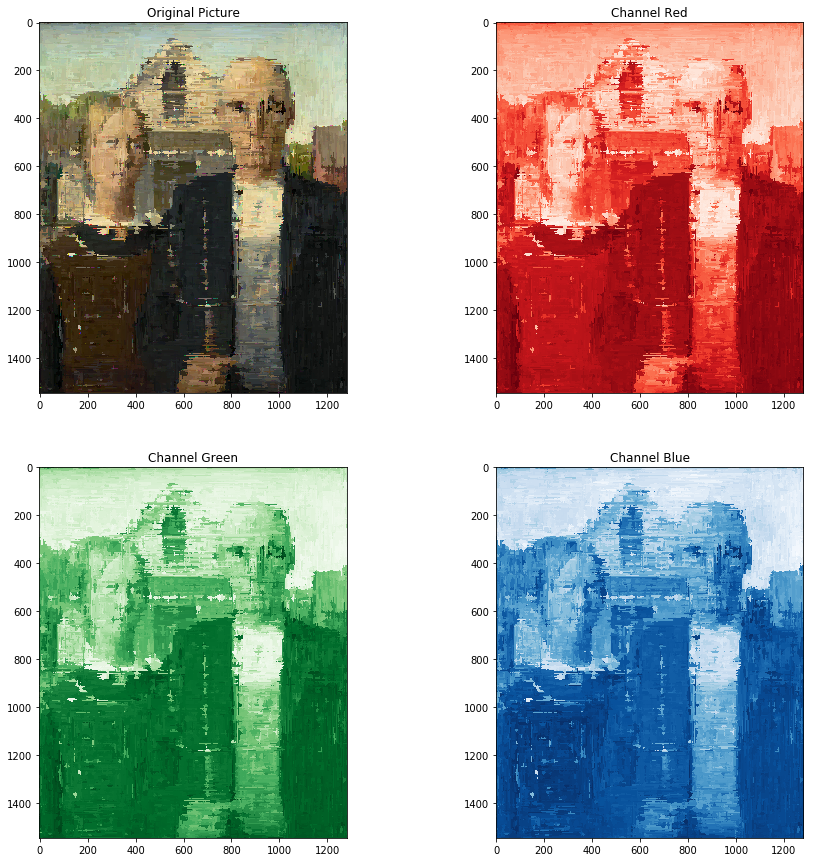

In [9]:
from sklearn.ensemble import RandomForestClassifier

X_train, Y_train, _, _ = extract_dataset(photo, train_size=10000, test_size=0)

#n_jobs=1 takes 24 minutes
tree_model = RandomForestClassifier(n_estimators=50, n_jobs=-1)
tree_model.fit(X_train, Y_train)

predicted = np.zeros((photo.shape[0], photo.shape[1], 3))


all_coordinates = np.array(list(itertools.product(np.arange(predicted.shape[0]), np.arange(predicted.shape[1]))))

all_results = tree_model.predict(all_coordinates)

for x in range(all_coordinates.shape[0]):
    predicted[all_coordinates[x][0], all_coordinates[x][1]] = all_results[x].astype(np.uint8)


show_matrix(predicted.astype(np.uint8))

2018-09-06T11:33:26.872212 ----
2018-09-06T11:33:26.872306 Image matrix of shape (1545, 1280, 3)
2018-09-06T11:33:26.957387 min/avg/max on the channels: [0 1 0]/[102.44682898  96.93147097  76.57945388]/[250 232 208]


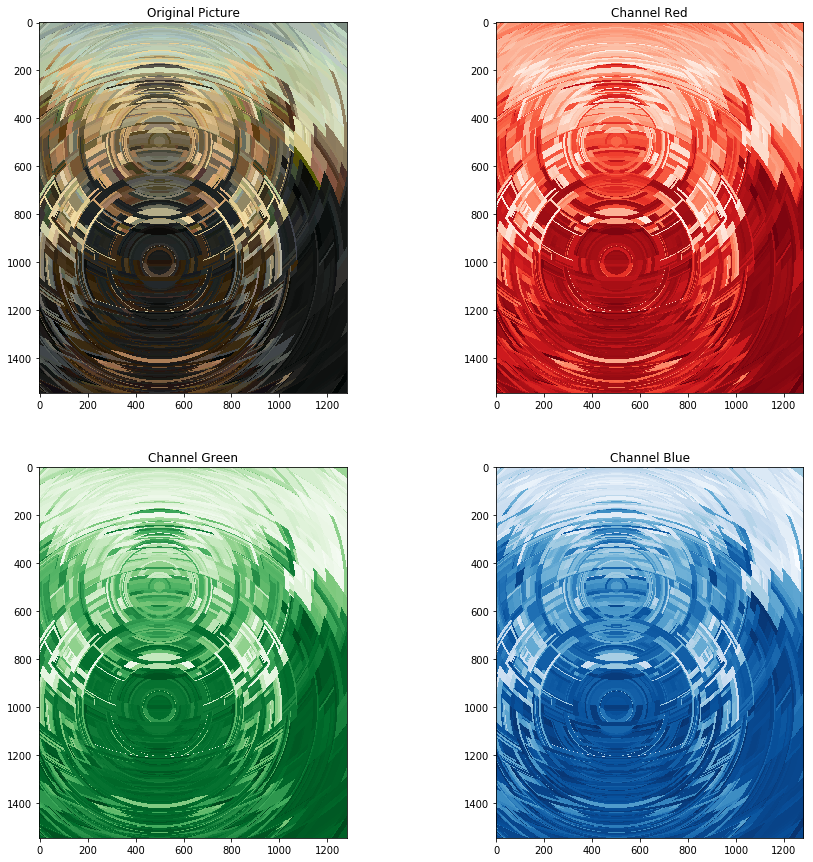

In [10]:
from sklearn import tree
def enricher_for_tree(coordinates):
    return [
            (coordinates[0] - 500) ** 2 + (coordinates[1] - 500) ** 2,
            (coordinates[0] - 1000) ** 2 + (coordinates[1] - 500) ** 2,
           ] 


X_train, Y_train, _, _ = extract_dataset(photo, train_size=2000, test_size=0)

X_train_enriched = [enricher_for_tree(c) for c in X_train]

tree_model = tree.DecisionTreeRegressor()
tree_model.fit(X_train_enriched, Y_train)

predicted = np.zeros((photo.shape[0], photo.shape[1], 3))


all_coordinates = np.array(list(itertools.product(np.arange(predicted.shape[0]), np.arange(predicted.shape[1]))))
all_coordinates_enriched = np.array([enricher_for_tree(c) for c in all_coordinates])

all_results = tree_model.predict(all_coordinates_enriched)

for x in range(all_coordinates.shape[0]):
    predicted[all_coordinates[x][0], all_coordinates[x][1]] = all_results[x].astype(np.uint8)


show_matrix(predicted.astype(np.uint8))

2018-09-06T11:33:28.022275 ----
2018-09-06T11:33:28.022917 Image matrix of shape (1545, 1280, 3)
2018-09-06T11:33:28.116283 min/avg/max on the channels: [0 0 0]/[103.34416212  97.49891535  76.45601992]/[255 255 246]
2018-09-06T11:33:28.900349 the score on the test set is: (0.7723551778178408,)
2018-09-06T11:33:28.919604 the score on the train set is: (0.755853103820492,)
2018-09-06T11:33:28.929873 Producing the enriched list of coordinates...
2018-09-06T11:39:59.782407 Predicting values for all of them...
2018-09-06T11:40:00.333446 Creating the image matrix using the predictions...
2018-09-06T11:40:03.818709 ---
2018-09-06T11:40:03.819532 for the point (0, 0) the predicted value is [114.74373612 124.06666234 117.47464531] and the original value was [111  96  73], 
2018-09-06T11:40:03.819708 ---
2018-09-06T11:40:03.820057 for the point (200, 200) the predicted value is [190.26413676 208.20577201 170.0127707 ] and the original value was [186 207 164], 
2018-09-06T11:40:03.820220 ---
2018

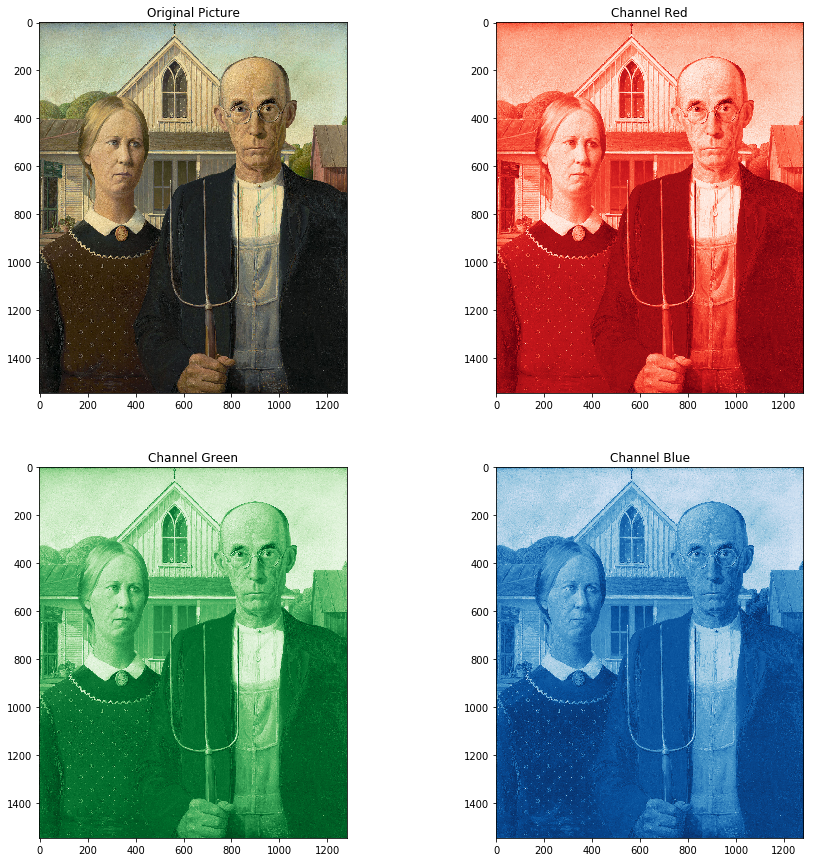

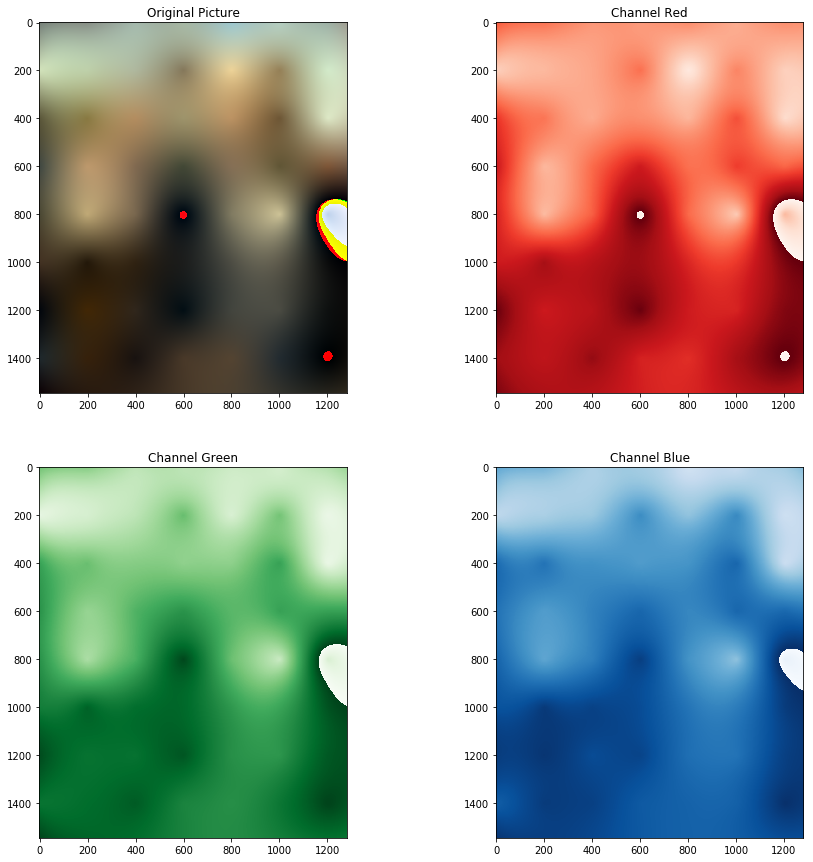

In [11]:
# 4 minutes with 300 pixel grid
# 32 minutes with 100 pixel grid
def enricher(coordinates):
    ref_coordinates = list(itertools.product(np.arange(0, photo.shape[0], 200), np.arange(0, photo.shape[1], 200)))
    return [coordinates[0],
            coordinates[1],
           ] + [np.sqrt((coordinates[0] - p[0]) ** 2 + (coordinates[1] - p[1]) ** 2) for p in ref_coordinates]



    
show_matrix(photo)

X_train, Y_train, X_test, Y_test = extract_dataset(photo, train_size=3000, test_size=500)

    
X_train_enriched = [enricher(c) for c in X_train]
X_test_enriched = [enricher(c) for c in X_test]


model_enriched = linear_model.LinearRegression(n_jobs=-1)
model_enriched.fit(X_train_enriched, Y_train)
log('the score on the test set is:', model_enriched.score(X_test_enriched, Y_test))
log('the score on the train set is:', model_enriched.score(X_train_enriched, Y_train))
predict = np.zeros(photo.shape)

log('Producing the enriched list of coordinates...')
all_coordinates = np.array(list(itertools.product(np.arange(photo.shape[0]), np.arange(photo.shape[1]))))
all_coordinates_enriched = np.array([enricher(c) for c in all_coordinates])

# this step is very slow. It could be parallelized using for example using concurrent.futures
log('Predicting values for all of them...')
all_results = model_enriched.predict(all_coordinates_enriched)

log('Creating the image matrix using the predictions...')
for x in range(all_coordinates.shape[0]):
    predict[all_coordinates[x][0], all_coordinates[x][1]] = all_results[x]

sample_points = [(0,0), (200, 200), (photo.shape[0] - 1 , photo.shape[1] -1)]
for sp in sample_points:
    log('---')
    log(f'for the point {sp} the predicted value is {predict[sp]} and the original value was {photo[sp]}, ')
    
show_matrix(predict.astype(np.uint8))


It worked, and in theory adding a growing number of independent non-linear functions and then increasing the number of sample points the model can be made arbitrarily accurate. A thing to notice is that this model is producing the *exact* set of parameters which reduces the quare error given the samples. It does not use any form of gradient descend.

The `enrich` function defined above applies a sort of RBF (Radial Basis Function): it assigns to each coordinate a set of extra parameters based on the distance of the point from some reference point. The distance is euclidean but other types of distances can be used as well.

We can compare the results with a proper implementation of SVM provided in Scikit-learn.

2018-09-06T11:40:06.850567 Defining untrained models with kernel type rbf and gamma value 0.001
2018-09-06T11:40:06.850907 Generating test and train datasets...
2018-09-06T11:40:06.891598 Fit the SVM for the 3 channels...
2018-09-06T11:40:08.838448 Enumerate all coordinates...
2018-09-06T11:40:09.851012 Use the trained SVM models to predict all the pixels for RED...
2018-09-06T11:43:24.317462 Use the trained SVM models to predict all the pixels for GREEN...
2018-09-06T11:46:09.258396 Use the trained SVM models to predict all the pixels for BLUE...
2018-09-06T11:48:40.470957 Reassemble an image from the predictions...
2018-09-06T11:48:51.325789 ----
2018-09-06T11:48:51.325948 Image matrix of shape (1545, 1280, 3)
2018-09-06T11:48:51.423568 min/avg/max on the channels: [74 64 42]/[87.85296824 77.58279632 55.1761069 ]/[103  92  69]
2018-09-06T11:48:51.653413 ----
2018-09-06T11:48:51.653538 Image matrix of shape (1545, 1280, 3)
2018-09-06T11:48:51.744946 min/avg/max on the channels: [133  

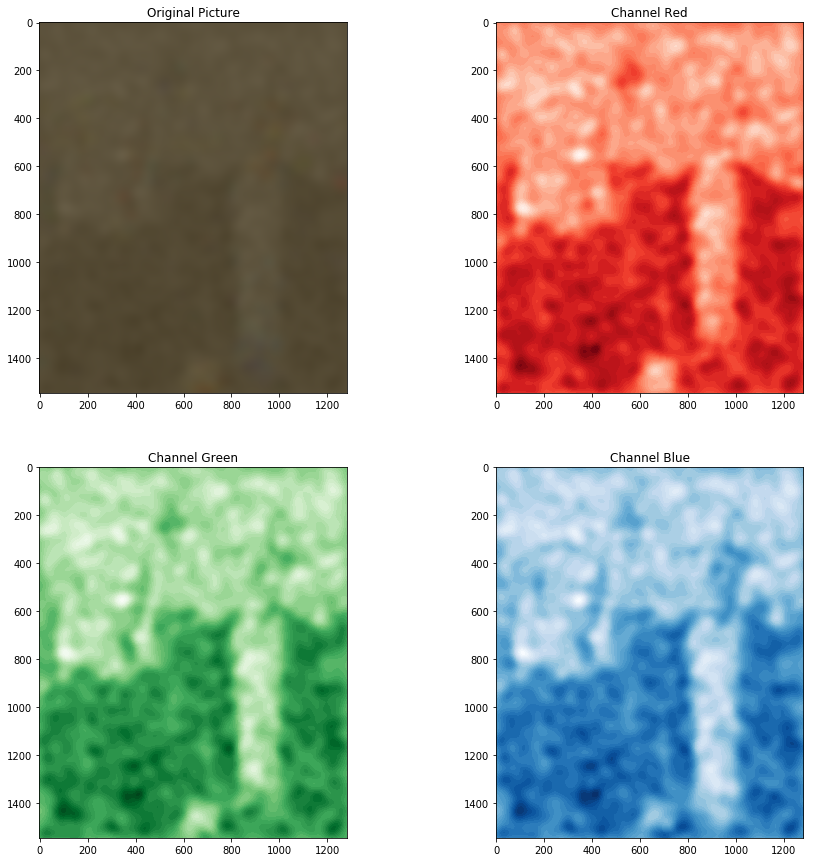

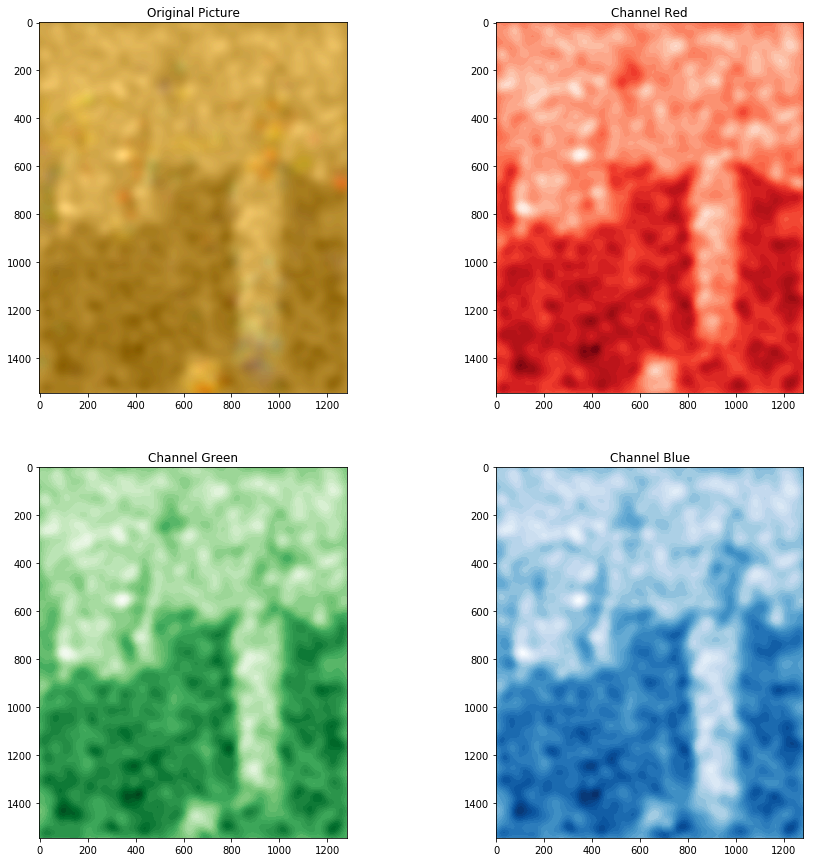

In [12]:
from sklearn.svm import SVR


#show_matrix(photo)
kernel = 'rbf'
gamma=0.001

log(f'Defining untrained models with kernel type {kernel} and gamma value {gamma}')
svr_rbf_red   = SVR(kernel=kernel, gamma=gamma,)
svr_rbf_green = SVR(kernel=kernel, gamma=gamma)
svr_rbf_blue  = SVR(kernel=kernel, gamma=gamma)

log('Generating test and train datasets...')
X_train, Y_train, X_test, Y_test = extract_dataset(photo, train_size=4000, test_size=0)

log('Fit the SVM for the 3 channels...')
svr_rbf_red.fit(X_train, Y_train[:, 0])
svr_rbf_green.fit(X_train, Y_train[:, 1])
svr_rbf_blue.fit(X_train, Y_train[:, 2])

log('Enumerate all coordinates...')
all_coordinates = np.array(list(itertools.product(np.arange(photo.shape[0]), np.arange(photo.shape[1]))))

log('Use the trained SVM models to predict all the pixels for RED...')
all_results_red = svr_rbf_red.predict(all_coordinates)
log('Use the trained SVM models to predict all the pixels for GREEN...')
all_results_green = svr_rbf_green.predict(all_coordinates)
log('Use the trained SVM models to predict all the pixels for BLUE...')
all_results_blue = svr_rbf_blue.predict(all_coordinates)

log('Reassemble an image from the predictions...')

predict = np.zeros(photo.shape)
for x in range(all_coordinates.shape[0]):
    predict[all_coordinates[x][0], all_coordinates[x][1]] = [all_results_red[x].astype(np.uint8), all_results_green[x].astype(np.uint8), all_results_blue[x].astype(np.uint8)]


show_matrix(predict.astype(np.uint8))

# the image is heavily polarized (why?)
predict = predict - np.min(predict)
predict = predict * 255.0 / np.max(predict)
show_matrix(predict.astype(np.uint8))

The model has different hyper-parameters that can be tuned (they are called like that to not be confused with the parameters tuned during training, in this case the hyperplanes), for example we can use `rbf`, `sigmoid` or many other kernels, or change the `gamma` and `C` parameters, among others. One can test a set of hyperparameters by hand and see what happens, but scikit-learn provides a tool called `GridSearchCV` to perform this operation automatically. It has the additional advantage of using multiple cores and train different models in parallel. And with Dask it can also exploit different machines of a cluster.

So, it's possible to test a few hyperparameters and see the let the tool pick up the one with the highest score and use directly that. Notice that the optimal hyperparameters are the almost the same for all the channels, so a single execution of `GridSearchCV` could suffice. 

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
[CV] C=0.001, gamma=1e-05, kernel=rbf ................................
[CV] C=0.001, gamma=1e-05, kernel=rbf ................................
[CV] C=0.001, gamma=1e-05, kernel=rbf ................................
[CV] C=0.001, gamma=1e-05, kernel=sigmoid ............................
[CV] C=0.001, gamma=1e-05, kernel=sigmoid ............................
[CV] C=0.001, gamma=1e-05, kernel=sigmoid ............................
[CV] C=0.001, gamma=1.52333050070436e-05, kernel=rbf .................
[CV] C=0.001, gamma=1.52333050070436e-05, kernel=rbf .................
[CV] ................. C=0.001, gamma=1e-05, kernel=rbf, total=   0.3s
[CV] C=0.001, gamma=1.52333050070436e-05, kernel=rbf .................
[CV] ................. C=0.001, gamma=1e-05, kernel=rbf, total=   0.3s
[CV] C=0.001, gamma=1.52333050070436e-05, kernel=sigmoid .............
[CV] ................. C=0.001, gamma=1e-05, kernel=rbf, total=   0.3s
[CV] C=0.001

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.7s


[CV] . C=0.001, gamma=8.202961796187215e-05, kernel=rbf, total=   0.3s
[CV] C=0.001, gamma=0.00012495821900244632, kernel=rbf ...............
[CV] . C=0.001, gamma=8.202961796187215e-05, kernel=rbf, total=   0.3s
[CV] C=0.001, gamma=0.00012495821900244632, kernel=sigmoid ...........
[CV]  C=0.001, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV]  C=0.001, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV] C=0.001, gamma=0.00012495821900244632, kernel=sigmoid ...........
[CV] C=0.001, gamma=0.00012495821900244632, kernel=sigmoid ...........
[CV]  C=0.001, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV] C=0.001, gamma=0.0001903526663201216, kernel=rbf ................
[CV] . C=0.001, gamma=8.202961796187215e-05, kernel=rbf, total=   0.4s
[CV] C=0.001, gamma=0.0001903526663201216, kernel=rbf ................
[CV]  C=0.001, gamma=0.00012495821900244632, kernel=rbf, total=   0.3s
[CV]  C=0.001, gamma=0.00012495821900244632, kernel=sigmoid, total= 

[CV] . C=0.001, gamma=0.0036234137575179596, kernel=rbf, total=   0.5s
[CV] C=0.001, gamma=0.005519656693498899, kernel=sigmoid .............
[CV] C=0.001, gamma=0.008408261394623858, kernel=rbf .................
[CV] . C=0.001, gamma=0.0036234137575179596, kernel=rbf, total=   0.5s
[CV] C=0.001, gamma=0.008408261394623858, kernel=rbf .................
[CV] .. C=0.001, gamma=0.005519656693498899, kernel=rbf, total=   0.4s
[CV] C=0.001, gamma=0.008408261394623858, kernel=rbf .................
[CV] .. C=0.001, gamma=0.005519656693498899, kernel=rbf, total=   0.4s
[CV] C=0.001, gamma=0.008408261394623858, kernel=sigmoid .............
[CV]  C=0.001, gamma=0.005519656693498899, kernel=sigmoid, total=   0.2s
[CV] C=0.001, gamma=0.008408261394623858, kernel=sigmoid .............
[CV]  C=0.001, gamma=0.005519656693498899, kernel=sigmoid, total=   0.2s
[CV] C=0.001, gamma=0.008408261394623858, kernel=sigmoid .............
[CV]  C=0.001, gamma=0.005519656693498899, kernel=sigmoid, total=   0.2s


[CV] .... C=0.001, gamma=0.2438143745749995, kernel=rbf, total=   0.2s
[CV]  C=0.001, gamma=0.2438143745749995, kernel=sigmoid, total=   0.2s
[CV] C=0.001, gamma=0.3714098733002543, kernel=sigmoid ...............
[CV] .... C=0.001, gamma=0.2438143745749995, kernel=rbf, total=   0.2s
[CV] C=0.001, gamma=0.3714098733002543, kernel=sigmoid ...............
[CV] C=0.001, gamma=0.3714098733002543, kernel=sigmoid ...............
[CV]  C=0.001, gamma=0.2438143745749995, kernel=sigmoid, total=   0.2s
[CV] C=0.001, gamma=0.5657799882610194, kernel=rbf ...................
[CV]  C=0.001, gamma=0.2438143745749995, kernel=sigmoid, total=   0.2s
[CV] C=0.001, gamma=0.5657799882610194, kernel=rbf ...................
[CV] .... C=0.001, gamma=0.3714098733002543, kernel=rbf, total=   0.2s
[CV] C=0.001, gamma=0.5657799882610194, kernel=rbf ...................


[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    6.7s


[CV] .... C=0.001, gamma=0.3714098733002543, kernel=rbf, total=   0.2s
[CV] C=0.001, gamma=0.5657799882610194, kernel=sigmoid ...............
[CV] .... C=0.001, gamma=0.3714098733002543, kernel=rbf, total=   0.3s
[CV] C=0.001, gamma=0.5657799882610194, kernel=sigmoid ...............
[CV]  C=0.001, gamma=0.3714098733002543, kernel=sigmoid, total=   0.2s
[CV] C=0.001, gamma=0.5657799882610194, kernel=sigmoid ...............
[CV]  C=0.001, gamma=0.3714098733002543, kernel=sigmoid, total=   0.2s
[CV] C=0.001, gamma=0.8618699128061654, kernel=rbf ...................
[CV]  C=0.001, gamma=0.3714098733002543, kernel=sigmoid, total=   0.3s
[CV] C=0.001, gamma=0.8618699128061654, kernel=rbf ...................
[CV] .... C=0.001, gamma=0.5657799882610194, kernel=rbf, total=   0.2s
[CV] C=0.001, gamma=0.8618699128061654, kernel=rbf ...................
[CV] .... C=0.001, gamma=0.5657799882610194, kernel=rbf, total=   0.2s
[CV] .... C=0.001, gamma=0.5657799882610194, kernel=rbf, total=   0.2s
[CV] C

[CV]  C=0.0019010851906124285, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.3s
[CV] C=0.0019010851906124285, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV] C=0.0019010851906124285, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV] C=0.0019010851906124285, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV]  C=0.0019010851906124285, gamma=5.3848864658026056e-05, kernel=sigmoid, total=   0.2s
[CV] C=0.0019010851906124285, gamma=0.00012495821900244632, kernel=rbf 
[CV]  C=0.0019010851906124285, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.3s
[CV] C=0.0019010851906124285, gamma=0.00012495821900244632, kernel=rbf 
[CV]  C=0.0019010851906124285, gamma=8.202961796187215e-05, kernel=rbf, total=   0.3s
[CV] C=0.0019010851906124285, gamma=0.00012495821900244632, kernel=rbf 
[CV]  C=0.0019010851906124285, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV] C=0.0019010851906124285, gamma=0.00012495821900244632, kernel=sigmoid 
[CV]  C=0.0019010851906124285, gamma=8.202

[CV]  C=0.0019010851906124285, gamma=0.0015614556496263334, kernel=rbf, total=   0.4s
[CV] C=0.0019010851906124285, gamma=0.0036234137575179596, kernel=rbf 
[CV]  C=0.0019010851906124285, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.2s
[CV] C=0.0019010851906124285, gamma=0.0036234137575179596, kernel=rbf 
[CV]  C=0.0019010851906124285, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.2s
[CV] C=0.0019010851906124285, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=0.0019010851906124285, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.2s
[CV] C=0.0019010851906124285, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=0.0019010851906124285, gamma=0.0023786130165729343, kernel=rbf, total=   0.3s
[CV] C=0.0019010851906124285, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=0.0019010851906124285, gamma=0.0023786130165729343, kernel=rbf, total=   0.3s
[CV] C=0.0019010851906124285, gamma=0.005519656693498899, kernel=rbf .
[CV]  C=0.0019010851906124285, gam

[CV] C=0.0019010851906124285, gamma=0.10506813687792228, kernel=sigmoid 
[CV]  C=0.0019010851906124285, gamma=0.06897264699245541, kernel=sigmoid, total=   0.2s
[CV] C=0.0019010851906124285, gamma=0.10506813687792228, kernel=sigmoid 
[CV]  C=0.0019010851906124285, gamma=0.06897264699245541, kernel=sigmoid, total=   0.2s
[CV] C=0.0019010851906124285, gamma=0.16005349755831957, kernel=rbf ..
[CV]  C=0.0019010851906124285, gamma=0.06897264699245541, kernel=sigmoid, total=   0.2s
[CV] C=0.0019010851906124285, gamma=0.16005349755831957, kernel=rbf ..
[CV]  C=0.0019010851906124285, gamma=0.10506813687792228, kernel=rbf, total=   0.2s
[CV] C=0.0019010851906124285, gamma=0.16005349755831957, kernel=rbf ..
[CV]  C=0.0019010851906124285, gamma=0.10506813687792228, kernel=rbf, total=   0.2s
[CV] C=0.0019010851906124285, gamma=0.16005349755831957, kernel=sigmoid 
[CV]  C=0.0019010851906124285, gamma=0.10506813687792228, kernel=sigmoid, total=   0.2s
[CV] C=0.0019010851906124285, gamma=0.1600534975

[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:   14.7s


[CV] ... C=0.0019010851906124285, gamma=2.0, kernel=rbf, total=   0.2s
[CV] C=0.00361412490196589, gamma=1e-05, kernel=sigmoid ..............
[CV]  C=0.0019010851906124285, gamma=2.0, kernel=sigmoid, total=   0.2s
[CV] C=0.00361412490196589, gamma=1e-05, kernel=sigmoid ..............
[CV]  C=0.0019010851906124285, gamma=2.0, kernel=sigmoid, total=   0.1s
[CV] C=0.00361412490196589, gamma=1.52333050070436e-05, kernel=rbf ...
[CV]  C=0.0019010851906124285, gamma=2.0, kernel=sigmoid, total=   0.1s
[CV] C=0.00361412490196589, gamma=1.52333050070436e-05, kernel=rbf ...
[CV] ... C=0.00361412490196589, gamma=1e-05, kernel=rbf, total=   0.2s
[CV] C=0.00361412490196589, gamma=1.52333050070436e-05, kernel=rbf ...
[CV] ... C=0.00361412490196589, gamma=1e-05, kernel=rbf, total=   0.3s
[CV] C=0.00361412490196589, gamma=1.52333050070436e-05, kernel=sigmoid 
[CV] ... C=0.00361412490196589, gamma=1e-05, kernel=rbf, total=   0.3s
[CV] C=0.00361412490196589, gamma=1.52333050070436e-05, kernel=sigmoid 
[

[CV]  C=0.00361412490196589, gamma=0.0002899700224958411, kernel=rbf, total=   0.3s
[CV] C=0.00361412490196589, gamma=0.00044172017955784455, kernel=sigmoid 
[CV]  C=0.00361412490196589, gamma=0.0002899700224958411, kernel=sigmoid, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.00044172017955784455, kernel=sigmoid 
[CV]  C=0.00361412490196589, gamma=0.0002899700224958411, kernel=sigmoid, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.00044172017955784455, kernel=sigmoid 
[CV]  C=0.00361412490196589, gamma=0.0002899700224958411, kernel=rbf, total=   0.4s
[CV] C=0.00361412490196589, gamma=0.0006728858222970712, kernel=rbf ..
[CV]  C=0.00361412490196589, gamma=0.0002899700224958411, kernel=rbf, total=   0.3s
[CV] C=0.00361412490196589, gamma=0.0006728858222970712, kernel=rbf ..
[CV]  C=0.00361412490196589, gamma=0.00044172017955784455, kernel=sigmoid, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.0006728858222970712, kernel=rbf ..
[CV]  C=0.00361412490196589, gamma=0.00044172017

[CV]  C=0.00361412490196589, gamma=0.008408261394623858, kernel=rbf, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.019511671702861427, kernel=rbf ...
[CV]  C=0.00361412490196589, gamma=0.012808561040325515, kernel=rbf, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.019511671702861427, kernel=rbf ...
[CV]  C=0.00361412490196589, gamma=0.012808561040325515, kernel=rbf, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.019511671702861427, kernel=sigmoid 
[CV]  C=0.00361412490196589, gamma=0.012808561040325515, kernel=sigmoid, total=   0.2s
[CV]  C=0.00361412490196589, gamma=0.012808561040325515, kernel=rbf, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.019511671702861427, kernel=sigmoid 
[CV] C=0.00361412490196589, gamma=0.019511671702861427, kernel=sigmoid 
[CV]  C=0.00361412490196589, gamma=0.012808561040325515, kernel=sigmoid, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.029722724624699017, kernel=rbf ...
[CV]  C=0.00361412490196589, gamma=0.012808561040325515, kernel=s

[CV]  C=0.00361412490196589, gamma=0.3714098733002543, kernel=sigmoid, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.8618699128061654, kernel=rbf .....
[CV]  C=0.00361412490196589, gamma=0.3714098733002543, kernel=sigmoid, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.8618699128061654, kernel=rbf .....
[CV]  C=0.00361412490196589, gamma=0.5657799882610194, kernel=rbf, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.8618699128061654, kernel=rbf .....
[CV]  C=0.00361412490196589, gamma=0.5657799882610194, kernel=rbf, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.8618699128061654, kernel=sigmoid .
[CV]  C=0.00361412490196589, gamma=0.5657799882610194, kernel=sigmoid, total=   0.3s
[CV] C=0.00361412490196589, gamma=0.8618699128061654, kernel=sigmoid .
[CV]  C=0.00361412490196589, gamma=0.5657799882610194, kernel=rbf, total=   0.3s
[CV] C=0.00361412490196589, gamma=0.8618699128061654, kernel=sigmoid .
[CV]  C=0.00361412490196589, gamma=0.5657799882610194, kernel=sigmoid, total

[CV] C=0.006870759328150948, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=5.3848864658026056e-05, kernel=sigmoid, total=   0.3s
[CV] C=0.006870759328150948, gamma=0.00012495821900244632, kernel=rbf 
[CV]  C=0.006870759328150948, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.4s
[CV] C=0.006870759328150948, gamma=0.00012495821900244632, kernel=rbf 
[CV]  C=0.006870759328150948, gamma=8.202961796187215e-05, kernel=rbf, total=   0.4s
[CV] C=0.006870759328150948, gamma=0.00012495821900244632, kernel=rbf 
[CV]  C=0.006870759328150948, gamma=8.202961796187215e-05, kernel=rbf, total=   0.4s
[CV] C=0.006870759328150948, gamma=0.00012495821900244632, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.3s
[CV] C=0.006870759328150948, gamma=0.00012495821900244632, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.3s
[CV]  C=0.006870759328150948, gamma=8.2

[CV]  C=0.006870759328150948, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.3s
[CV]  C=0.006870759328150948, gamma=0.0023786130165729343, kernel=rbf, total=   0.4s
[CV] C=0.006870759328150948, gamma=0.0036234137575179596, kernel=sigmoid 
[CV] C=0.006870759328150948, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=0.0023786130165729343, kernel=rbf, total=   0.5s
[CV] C=0.006870759328150948, gamma=0.005519656693498899, kernel=rbf ..
[CV]  C=0.006870759328150948, gamma=0.0023786130165729343, kernel=rbf, total=   0.4s
[CV] C=0.006870759328150948, gamma=0.005519656693498899, kernel=rbf ..
[CV]  C=0.006870759328150948, gamma=0.0036234137575179596, kernel=rbf, total=   0.4s
[CV] C=0.006870759328150948, gamma=0.005519656693498899, kernel=rbf ..
[CV]  C=0.006870759328150948, gamma=0.003623413

[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:   29.1s


[CV]  C=0.006870759328150948, gamma=0.008408261394623858, kernel=rbf, total=   0.3s
[CV]  C=0.006870759328150948, gamma=0.008408261394623858, kernel=sigmoid, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.012808561040325515, kernel=sigmoid 
[CV] C=0.006870759328150948, gamma=0.012808561040325515, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=0.008408261394623858, kernel=sigmoid, total=   0.2s
[CV]  C=0.006870759328150948, gamma=0.008408261394623858, kernel=sigmoid, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.019511671702861427, kernel=rbf ..
[CV] C=0.006870759328150948, gamma=0.019511671702861427, kernel=rbf ..
[CV]  C=0.006870759328150948, gamma=0.012808561040325515, kernel=rbf, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.019511671702861427, kernel=rbf ..
[CV]  C=0.006870759328150948, gamma=0.012808561040325515, kernel=rbf, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.019511671702861427, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=0.01280856104032

[CV] C=0.006870759328150948, gamma=0.5657799882610194, kernel=rbf ....
[CV]  C=0.006870759328150948, gamma=0.3714098733002543, kernel=rbf, total=   0.4s
[CV] C=0.006870759328150948, gamma=0.5657799882610194, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=0.3714098733002543, kernel=rbf, total=   0.4s
[CV] C=0.006870759328150948, gamma=0.5657799882610194, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=0.3714098733002543, kernel=sigmoid, total=   0.3s
[CV] C=0.006870759328150948, gamma=0.5657799882610194, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=0.3714098733002543, kernel=sigmoid, total=   0.3s
[CV] C=0.006870759328150948, gamma=0.8618699128061654, kernel=rbf ....
[CV]  C=0.006870759328150948, gamma=0.3714098733002543, kernel=sigmoid, total=   0.3s
[CV] C=0.006870759328150948, gamma=0.8618699128061654, kernel=rbf ....
[CV]  C=0.006870759328150948, gamma=0.5657799882610194, kernel=rbf, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.8618699128061654, kernel=rbf ....

[CV]  C=0.01306189880700996, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.6s
[CV] C=0.01306189880700996, gamma=8.202961796187215e-05, kernel=rbf ..
[CV]  C=0.01306189880700996, gamma=5.3848864658026056e-05, kernel=sigmoid, total=   0.4s
[CV] C=0.01306189880700996, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV]  C=0.01306189880700996, gamma=5.3848864658026056e-05, kernel=sigmoid, total=   0.4s
[CV] C=0.01306189880700996, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV]  C=0.01306189880700996, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.4s
[CV] C=0.01306189880700996, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV]  C=0.01306189880700996, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.5s
[CV] C=0.01306189880700996, gamma=0.00012495821900244632, kernel=rbf .
[CV]  C=0.01306189880700996, gamma=5.3848864658026056e-05, kernel=sigmoid, total=   0.3s
[CV] C=0.01306189880700996, gamma=0.00012495821900244632, kernel=rbf .
[CV]  C=0.01306189880700996, gamma=8.202961796

[CV]  C=0.01306189880700996, gamma=0.0015614556496263334, kernel=rbf, total=   0.4s
[CV] C=0.01306189880700996, gamma=0.0036234137575179596, kernel=rbf ..
[CV]  C=0.01306189880700996, gamma=0.0015614556496263334, kernel=rbf, total=   0.4s
[CV] C=0.01306189880700996, gamma=0.0036234137575179596, kernel=rbf ..
[CV]  C=0.01306189880700996, gamma=0.0023786130165729343, kernel=rbf, total=   0.4s
[CV] C=0.01306189880700996, gamma=0.0036234137575179596, kernel=rbf ..
[CV]  C=0.01306189880700996, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.2s
[CV] C=0.01306189880700996, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=0.01306189880700996, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.2s
[CV] C=0.01306189880700996, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=0.01306189880700996, gamma=0.0023786130165729343, kernel=rbf, total=   0.3s
[CV] C=0.01306189880700996, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=0.01306189880700996, gamma=0.0023786130165729343

[CV] C=0.01306189880700996, gamma=0.10506813687792228, kernel=sigmoid 
[CV]  C=0.01306189880700996, gamma=0.06897264699245541, kernel=rbf, total=   0.2s
[CV] C=0.01306189880700996, gamma=0.10506813687792228, kernel=sigmoid 
[CV]  C=0.01306189880700996, gamma=0.06897264699245541, kernel=sigmoid, total=   0.2s
[CV] C=0.01306189880700996, gamma=0.16005349755831957, kernel=rbf ....
[CV]  C=0.01306189880700996, gamma=0.06897264699245541, kernel=sigmoid, total=   0.2s
[CV] C=0.01306189880700996, gamma=0.16005349755831957, kernel=rbf ....
[CV]  C=0.01306189880700996, gamma=0.10506813687792228, kernel=rbf, total=   0.2s
[CV] C=0.01306189880700996, gamma=0.16005349755831957, kernel=rbf ....
[CV]  C=0.01306189880700996, gamma=0.10506813687792228, kernel=rbf, total=   0.2s
[CV] C=0.01306189880700996, gamma=0.16005349755831957, kernel=sigmoid 
[CV]  C=0.01306189880700996, gamma=0.10506813687792228, kernel=rbf, total=   0.2s
[CV] C=0.01306189880700996, gamma=0.16005349755831957, kernel=sigmoid 
[CV

[CV] C=0.02483178238328477, gamma=1.52333050070436e-05, kernel=sigmoid 
[CV]  C=0.02483178238328477, gamma=1.52333050070436e-05, kernel=rbf, total=   0.3s
[CV]  C=0.02483178238328477, gamma=1.52333050070436e-05, kernel=rbf, total=   0.3s
[CV] C=0.02483178238328477, gamma=1.52333050070436e-05, kernel=sigmoid 
[CV] C=0.02483178238328477, gamma=2.3205358143762008e-05, kernel=rbf .
[CV]  C=0.02483178238328477, gamma=1e-05, kernel=sigmoid, total=   0.4s
[CV] C=0.02483178238328477, gamma=2.3205358143762008e-05, kernel=rbf .
[CV]  C=0.02483178238328477, gamma=1e-05, kernel=sigmoid, total=   0.4s
[CV] C=0.02483178238328477, gamma=2.3205358143762008e-05, kernel=rbf .
[CV]  C=0.02483178238328477, gamma=1e-05, kernel=sigmoid, total=   0.4s
[CV] C=0.02483178238328477, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=0.02483178238328477, gamma=1.52333050070436e-05, kernel=rbf, total=   0.3s
[CV] C=0.02483178238328477, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=0.02483178238328477, g

[CV] C=0.02483178238328477, gamma=0.0006728858222970712, kernel=rbf ..
[CV]  C=0.02483178238328477, gamma=0.00044172017955784455, kernel=sigmoid, total=   0.2s
[CV] C=0.02483178238328477, gamma=0.0006728858222970712, kernel=sigmoid 
[CV]  C=0.02483178238328477, gamma=0.00044172017955784455, kernel=rbf, total=   0.4s
[CV] C=0.02483178238328477, gamma=0.0006728858222970712, kernel=sigmoid 
[CV]  C=0.02483178238328477, gamma=0.00044172017955784455, kernel=sigmoid, total=   0.2s
[CV] C=0.02483178238328477, gamma=0.0006728858222970712, kernel=sigmoid 
[CV]  C=0.02483178238328477, gamma=0.00044172017955784455, kernel=rbf, total=   0.4s
[CV] C=0.02483178238328477, gamma=0.0010250274965966635, kernel=rbf ..
[CV]  C=0.02483178238328477, gamma=0.00044172017955784455, kernel=rbf, total=   0.3s
[CV] C=0.02483178238328477, gamma=0.0010250274965966635, kernel=rbf ..
[CV]  C=0.02483178238328477, gamma=0.0006728858222970712, kernel=rbf, total=   0.3s
[CV]  C=0.02483178238328477, gamma=0.00067288582229

[Parallel(n_jobs=8)]: Done 997 tasks      | elapsed:   46.9s


[CV] C=0.02483178238328477, gamma=0.019511671702861427, kernel=rbf ...
[CV]  C=0.02483178238328477, gamma=0.012808561040325515, kernel=rbf, total=   0.2s
[CV] C=0.02483178238328477, gamma=0.019511671702861427, kernel=sigmoid 
[CV]  C=0.02483178238328477, gamma=0.012808561040325515, kernel=rbf, total=   0.2s
[CV] C=0.02483178238328477, gamma=0.019511671702861427, kernel=sigmoid 
[CV]  C=0.02483178238328477, gamma=0.012808561040325515, kernel=sigmoid, total=   0.2s
[CV] C=0.02483178238328477, gamma=0.019511671702861427, kernel=sigmoid 
[CV]  C=0.02483178238328477, gamma=0.012808561040325515, kernel=sigmoid, total=   0.2s
[CV] C=0.02483178238328477, gamma=0.029722724624699017, kernel=rbf ...
[CV]  C=0.02483178238328477, gamma=0.012808561040325515, kernel=sigmoid, total=   0.2s
[CV] C=0.02483178238328477, gamma=0.029722724624699017, kernel=rbf ...
[CV]  C=0.02483178238328477, gamma=0.019511671702861427, kernel=rbf, total=   0.2s
[CV] C=0.02483178238328477, gamma=0.029722724624699017, kerne

[CV] C=0.02483178238328477, gamma=0.8618699128061654, kernel=rbf .....
[CV]  C=0.02483178238328477, gamma=0.5657799882610194, kernel=rbf, total=   0.2s
[CV] C=0.02483178238328477, gamma=0.8618699128061654, kernel=rbf .....
[CV]  C=0.02483178238328477, gamma=0.5657799882610194, kernel=rbf, total=   0.2s
[CV] C=0.02483178238328477, gamma=0.8618699128061654, kernel=sigmoid .
[CV]  C=0.02483178238328477, gamma=0.5657799882610194, kernel=rbf, total=   0.2s
[CV] C=0.02483178238328477, gamma=0.8618699128061654, kernel=sigmoid .
[CV]  C=0.02483178238328477, gamma=0.5657799882610194, kernel=sigmoid, total=   0.2s
[CV] C=0.02483178238328477, gamma=0.8618699128061654, kernel=sigmoid .
[CV]  C=0.02483178238328477, gamma=0.5657799882610194, kernel=sigmoid, total=   0.2s
[CV] C=0.02483178238328477, gamma=1.3129127258170419, kernel=rbf .....
[CV]  C=0.02483178238328477, gamma=0.5657799882610194, kernel=sigmoid, total=   0.2s
[CV] C=0.02483178238328477, gamma=1.3129127258170419, kernel=rbf .....
[CV] 

[CV]  C=0.047207333745373274, gamma=5.3848864658026056e-05, kernel=sigmoid, total=   0.2s
[CV] C=0.047207333745373274, gamma=0.00012495821900244632, kernel=rbf 
[CV]  C=0.047207333745373274, gamma=8.202961796187215e-05, kernel=rbf, total=   0.4s
[CV] C=0.047207333745373274, gamma=0.00012495821900244632, kernel=rbf 
[CV]  C=0.047207333745373274, gamma=8.202961796187215e-05, kernel=rbf, total=   0.3s
[CV] C=0.047207333745373274, gamma=0.00012495821900244632, kernel=sigmoid 
[CV]  C=0.047207333745373274, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV] C=0.047207333745373274, gamma=0.00012495821900244632, kernel=sigmoid 
[CV]  C=0.047207333745373274, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV]  C=0.047207333745373274, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV] C=0.047207333745373274, gamma=0.00012495821900244632, kernel=sigmoid 
[CV] C=0.047207333745373274, gamma=0.0001903526663201216, kernel=rbf .
[CV]  C=0.047207333745373274, gamma

[CV] C=0.047207333745373274, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=0.047207333745373274, gamma=0.0023786130165729343, kernel=rbf, total=   0.3s
[CV] C=0.047207333745373274, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=0.047207333745373274, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.2s
[CV] C=0.047207333745373274, gamma=0.005519656693498899, kernel=rbf ..
[CV]  C=0.047207333745373274, gamma=0.0023786130165729343, kernel=rbf, total=   0.3s
[CV] C=0.047207333745373274, gamma=0.005519656693498899, kernel=rbf ..
[CV]  C=0.047207333745373274, gamma=0.0036234137575179596, kernel=rbf, total=   0.3s
[CV] C=0.047207333745373274, gamma=0.005519656693498899, kernel=rbf ..
[CV]  C=0.047207333745373274, gamma=0.0036234137575179596, kernel=rbf, total=   0.2s
[CV] C=0.047207333745373274, gamma=0.005519656693498899, kernel=sigmoid 
[CV]  C=0.047207333745373274, gamma=0.0036234137575179596, kernel=sigmoid, total=   0.2s
[CV]  C=0.047207333745373274, gamma=0.0036234137

[CV] C=0.047207333745373274, gamma=0.16005349755831957, kernel=rbf ...
[CV]  C=0.047207333745373274, gamma=0.10506813687792228, kernel=rbf, total=   0.2s
[CV] C=0.047207333745373274, gamma=0.16005349755831957, kernel=sigmoid 
[CV]  C=0.047207333745373274, gamma=0.10506813687792228, kernel=rbf, total=   0.2s
[CV] C=0.047207333745373274, gamma=0.16005349755831957, kernel=sigmoid 
[CV]  C=0.047207333745373274, gamma=0.10506813687792228, kernel=sigmoid, total=   0.2s
[CV] C=0.047207333745373274, gamma=0.16005349755831957, kernel=sigmoid 
[CV]  C=0.047207333745373274, gamma=0.10506813687792228, kernel=sigmoid, total=   0.2s
[CV]  C=0.047207333745373274, gamma=0.10506813687792228, kernel=sigmoid, total=   0.2s
[CV] C=0.047207333745373274, gamma=0.2438143745749995, kernel=rbf ....
[CV] C=0.047207333745373274, gamma=0.2438143745749995, kernel=rbf ....
[CV]  C=0.047207333745373274, gamma=0.16005349755831957, kernel=rbf, total=   0.2s
[CV] C=0.047207333745373274, gamma=0.2438143745749995, kernel

[CV] C=0.08974516307162743, gamma=2.3205358143762008e-05, kernel=rbf .
[CV]  C=0.08974516307162743, gamma=1e-05, kernel=sigmoid, total=   0.4s
[CV] C=0.08974516307162743, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=0.08974516307162743, gamma=1.52333050070436e-05, kernel=rbf, total=   0.4s
[CV] C=0.08974516307162743, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=0.08974516307162743, gamma=1.52333050070436e-05, kernel=sigmoid, total=   0.5s
[CV] C=0.08974516307162743, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=0.08974516307162743, gamma=1.52333050070436e-05, kernel=sigmoid, total=   0.5s
[CV] C=0.08974516307162743, gamma=3.534942984016097e-05, kernel=rbf ..
[CV]  C=0.08974516307162743, gamma=2.3205358143762008e-05, kernel=rbf, total=   0.3s
[CV]  C=0.08974516307162743, gamma=2.3205358143762008e-05, kernel=rbf, total=   0.3s
[CV]  C=0.08974516307162743, gamma=2.3205358143762008e-05, kernel=rbf, total=   0.3s
[CV] C=0.08974516307162743, gamma=3.534942984016097e

[CV] C=0.08974516307162743, gamma=0.0010250274965966635, kernel=rbf ..
[CV]  C=0.08974516307162743, gamma=0.00044172017955784455, kernel=rbf, total=   0.5s
[CV] C=0.08974516307162743, gamma=0.0010250274965966635, kernel=rbf ..
[CV]  C=0.08974516307162743, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.2s
[CV] C=0.08974516307162743, gamma=0.0010250274965966635, kernel=rbf ..
[CV]  C=0.08974516307162743, gamma=0.0006728858222970712, kernel=rbf, total=   0.4s
[CV] C=0.08974516307162743, gamma=0.0010250274965966635, kernel=sigmoid 
[CV]  C=0.08974516307162743, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.3s
[CV] C=0.08974516307162743, gamma=0.0010250274965966635, kernel=sigmoid 
[CV]  C=0.08974516307162743, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.3s
[CV] C=0.08974516307162743, gamma=0.0010250274965966635, kernel=sigmoid 
[CV]  C=0.08974516307162743, gamma=0.0006728858222970712, kernel=rbf, total=   0.4s
[CV] C=0.08974516307162743, gamma=0.001561455649626

[CV]  C=0.08974516307162743, gamma=0.019511671702861427, kernel=rbf, total=   0.4s
[CV] C=0.08974516307162743, gamma=0.029722724624699017, kernel=sigmoid 
[CV]  C=0.08974516307162743, gamma=0.019511671702861427, kernel=sigmoid, total=   0.3s
[CV] C=0.08974516307162743, gamma=0.04527753298484056, kernel=rbf ....
[CV]  C=0.08974516307162743, gamma=0.019511671702861427, kernel=sigmoid, total=   0.3s
[CV] C=0.08974516307162743, gamma=0.04527753298484056, kernel=rbf ....
[CV]  C=0.08974516307162743, gamma=0.029722724624699017, kernel=rbf, total=   0.4s
[CV] C=0.08974516307162743, gamma=0.04527753298484056, kernel=rbf ....
[CV]  C=0.08974516307162743, gamma=0.029722724624699017, kernel=rbf, total=   0.4s
[CV] C=0.08974516307162743, gamma=0.04527753298484056, kernel=sigmoid 
[CV]  C=0.08974516307162743, gamma=0.029722724624699017, kernel=rbf, total=   0.3s
[CV] C=0.08974516307162743, gamma=0.04527753298484056, kernel=sigmoid 
[CV]  C=0.08974516307162743, gamma=0.029722724624699017, kernel=sig

[CV]  C=0.08974516307162743, gamma=0.8618699128061654, kernel=rbf, total=   0.2s
[CV] C=0.08974516307162743, gamma=1.3129127258170419, kernel=sigmoid .
[CV]  C=0.08974516307162743, gamma=0.8618699128061654, kernel=sigmoid, total=   0.2s
[CV] C=0.08974516307162743, gamma=1.3129127258170419, kernel=sigmoid .
[CV]  C=0.08974516307162743, gamma=0.8618699128061654, kernel=sigmoid, total=   0.2s
[CV] C=0.08974516307162743, gamma=2.0, kernel=rbf ....................
[CV]  C=0.08974516307162743, gamma=1.3129127258170419, kernel=rbf, total=   0.2s
[CV] C=0.08974516307162743, gamma=2.0, kernel=rbf ....................
[CV]  C=0.08974516307162743, gamma=0.8618699128061654, kernel=sigmoid, total=   0.2s
[CV]  C=0.08974516307162743, gamma=1.3129127258170419, kernel=rbf, total=   0.2s
[CV] C=0.08974516307162743, gamma=2.0, kernel=rbf ....................
[CV] C=0.08974516307162743, gamma=2.0, kernel=sigmoid ................
[CV]  C=0.08974516307162743, gamma=1.3129127258170419, kernel=rbf, total=   

[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:  1.1min


[CV]  C=0.1706132004445682, gamma=1e-05, kernel=sigmoid, total=   0.4s
[CV] C=0.1706132004445682, gamma=2.3205358143762008e-05, kernel=rbf ..
[CV]  C=0.1706132004445682, gamma=1e-05, kernel=sigmoid, total=   0.4s
[CV] C=0.1706132004445682, gamma=2.3205358143762008e-05, kernel=rbf ..
[CV]  C=0.1706132004445682, gamma=1e-05, kernel=sigmoid, total=   0.4s
[CV] C=0.1706132004445682, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=0.1706132004445682, gamma=1.52333050070436e-05, kernel=rbf, total=   0.3s
[CV] C=0.1706132004445682, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=0.1706132004445682, gamma=1.52333050070436e-05, kernel=sigmoid, total=   0.3s
[CV] C=0.1706132004445682, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=0.1706132004445682, gamma=2.3205358143762008e-05, kernel=rbf, total=   0.2s
[CV] C=0.1706132004445682, gamma=3.534942984016097e-05, kernel=rbf ...
[CV]  C=0.1706132004445682, gamma=1.52333050070436e-05, kernel=sigmoid, total=   0.4s
[CV] C=0.17061320

[CV] C=0.1706132004445682, gamma=0.0006728858222970712, kernel=sigmoid 
[CV]  C=0.1706132004445682, gamma=0.00044172017955784455, kernel=rbf, total=   0.3s
[CV] C=0.1706132004445682, gamma=0.0010250274965966635, kernel=rbf ...
[CV]  C=0.1706132004445682, gamma=0.00044172017955784455, kernel=rbf, total=   0.3s
[CV] C=0.1706132004445682, gamma=0.0010250274965966635, kernel=rbf ...
[CV]  C=0.1706132004445682, gamma=0.0006728858222970712, kernel=rbf, total=   0.3s
[CV]  C=0.1706132004445682, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.2s
[CV] C=0.1706132004445682, gamma=0.0010250274965966635, kernel=rbf ...
[CV] C=0.1706132004445682, gamma=0.0010250274965966635, kernel=sigmoid 
[CV]  C=0.1706132004445682, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.2s
[CV]  C=0.1706132004445682, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.2s
[CV] C=0.1706132004445682, gamma=0.0010250274965966635, kernel=sigmoid 
[CV] C=0.1706132004445682, gamma=0.0010250274965966635, ker

[CV] C=0.1706132004445682, gamma=0.029722724624699017, kernel=sigmoid 
[CV]  C=0.1706132004445682, gamma=0.019511671702861427, kernel=sigmoid, total=   0.2s
[CV] C=0.1706132004445682, gamma=0.029722724624699017, kernel=sigmoid 
[CV]  C=0.1706132004445682, gamma=0.019511671702861427, kernel=sigmoid, total=   0.2s
[CV]  C=0.1706132004445682, gamma=0.019511671702861427, kernel=sigmoid, total=   0.2s
[CV] C=0.1706132004445682, gamma=0.04527753298484056, kernel=rbf .....
[CV] C=0.1706132004445682, gamma=0.04527753298484056, kernel=rbf .....
[CV]  C=0.1706132004445682, gamma=0.029722724624699017, kernel=rbf, total=   0.2s
[CV] C=0.1706132004445682, gamma=0.04527753298484056, kernel=rbf .....
[CV]  C=0.1706132004445682, gamma=0.029722724624699017, kernel=rbf, total=   0.2s
[CV] C=0.1706132004445682, gamma=0.04527753298484056, kernel=sigmoid .
[CV]  C=0.1706132004445682, gamma=0.029722724624699017, kernel=sigmoid, total=   0.2s
[CV] C=0.1706132004445682, gamma=0.04527753298484056, kernel=sigmo

[CV]  C=0.1706132004445682, gamma=0.8618699128061654, kernel=rbf, total=   0.2s
[CV] C=0.1706132004445682, gamma=1.3129127258170419, kernel=sigmoid ..
[CV]  C=0.1706132004445682, gamma=0.8618699128061654, kernel=sigmoid, total=   0.2s
[CV] C=0.1706132004445682, gamma=1.3129127258170419, kernel=sigmoid ..
[CV]  C=0.1706132004445682, gamma=0.8618699128061654, kernel=sigmoid, total=   0.2s
[CV] C=0.1706132004445682, gamma=2.0, kernel=rbf .....................
[CV]  C=0.1706132004445682, gamma=0.8618699128061654, kernel=sigmoid, total=   0.2s
[CV] C=0.1706132004445682, gamma=2.0, kernel=rbf .....................
[CV]  C=0.1706132004445682, gamma=1.3129127258170419, kernel=rbf, total=   0.2s
[CV] C=0.1706132004445682, gamma=2.0, kernel=rbf .....................
[CV]  C=0.1706132004445682, gamma=1.3129127258170419, kernel=rbf, total=   0.2s
[CV] C=0.1706132004445682, gamma=2.0, kernel=sigmoid .................
[CV]  C=0.1706132004445682, gamma=1.3129127258170419, kernel=rbf, total=   0.2s
[C

[CV] C=0.32435022868815844, gamma=0.0001903526663201216, kernel=sigmoid 
[CV]  C=0.32435022868815844, gamma=0.00012495821900244632, kernel=sigmoid, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.0001903526663201216, kernel=sigmoid 
[CV]  C=0.32435022868815844, gamma=0.00012495821900244632, kernel=sigmoid, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.0001903526663201216, kernel=sigmoid 
[CV]  C=0.32435022868815844, gamma=0.00012495821900244632, kernel=sigmoid, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.0002899700224958411, kernel=rbf ..
[CV]  C=0.32435022868815844, gamma=0.00012495821900244632, kernel=rbf, total=   0.3s
[CV] C=0.32435022868815844, gamma=0.0002899700224958411, kernel=rbf ..
[CV]  C=0.32435022868815844, gamma=0.0001903526663201216, kernel=sigmoid, total=   0.1s
[CV] C=0.32435022868815844, gamma=0.0002899700224958411, kernel=rbf ..
[CV]  C=0.32435022868815844, gamma=0.0001903526663201216, kernel=sigmoid, total=   0.2s
[CV]  C=0.32435022868815844, gamma=0.000

[CV] C=0.32435022868815844, gamma=0.008408261394623858, kernel=rbf ...
[CV]  C=0.32435022868815844, gamma=0.005519656693498899, kernel=rbf, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.008408261394623858, kernel=rbf ...
[CV]  C=0.32435022868815844, gamma=0.005519656693498899, kernel=rbf, total=   0.3s
[CV] C=0.32435022868815844, gamma=0.008408261394623858, kernel=sigmoid 
[CV]  C=0.32435022868815844, gamma=0.005519656693498899, kernel=sigmoid, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.008408261394623858, kernel=sigmoid 
[CV]  C=0.32435022868815844, gamma=0.005519656693498899, kernel=sigmoid, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.008408261394623858, kernel=sigmoid 
[CV]  C=0.32435022868815844, gamma=0.005519656693498899, kernel=sigmoid, total=   0.1s
[CV] C=0.32435022868815844, gamma=0.012808561040325515, kernel=rbf ...
[CV]  C=0.32435022868815844, gamma=0.005519656693498899, kernel=rbf, total=   0.3s
[CV] C=0.32435022868815844, gamma=0.012808561040325515, kerne

[CV] C=0.32435022868815844, gamma=0.3714098733002543, kernel=rbf .....
[CV]  C=0.32435022868815844, gamma=0.16005349755831957, kernel=sigmoid, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.3714098733002543, kernel=rbf .....
[CV]  C=0.32435022868815844, gamma=0.2438143745749995, kernel=rbf, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.3714098733002543, kernel=rbf .....
[CV]  C=0.32435022868815844, gamma=0.2438143745749995, kernel=rbf, total=   0.3s
[CV] C=0.32435022868815844, gamma=0.3714098733002543, kernel=sigmoid .
[CV]  C=0.32435022868815844, gamma=0.2438143745749995, kernel=rbf, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.3714098733002543, kernel=sigmoid .
[CV]  C=0.32435022868815844, gamma=0.2438143745749995, kernel=sigmoid, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.3714098733002543, kernel=sigmoid .
[CV]  C=0.32435022868815844, gamma=0.2438143745749995, kernel=sigmoid, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.5657799882610194, kernel=rbf .....
[CV]

[CV] C=0.6166174163308118, gamma=5.3848864658026056e-05, kernel=rbf ..
[CV]  C=0.6166174163308118, gamma=3.534942984016097e-05, kernel=rbf, total=   0.2s
[CV] C=0.6166174163308118, gamma=5.3848864658026056e-05, kernel=rbf ..
[CV]  C=0.6166174163308118, gamma=3.534942984016097e-05, kernel=rbf, total=   0.2s
[CV] C=0.6166174163308118, gamma=5.3848864658026056e-05, kernel=rbf ..
[CV]  C=0.6166174163308118, gamma=3.534942984016097e-05, kernel=rbf, total=   0.2s
[CV] C=0.6166174163308118, gamma=5.3848864658026056e-05, kernel=sigmoid 
[CV]  C=0.6166174163308118, gamma=2.3205358143762008e-05, kernel=sigmoid, total=   0.3s
[CV] C=0.6166174163308118, gamma=5.3848864658026056e-05, kernel=sigmoid 
[CV]  C=0.6166174163308118, gamma=3.534942984016097e-05, kernel=sigmoid, total=   0.2s
[CV] C=0.6166174163308118, gamma=5.3848864658026056e-05, kernel=sigmoid 
[CV]  C=0.6166174163308118, gamma=3.534942984016097e-05, kernel=sigmoid, total=   0.2s
[CV] C=0.6166174163308118, gamma=8.202961796187215e-05, k

[CV]  C=0.6166174163308118, gamma=0.0010250274965966635, kernel=rbf, total=   0.3s
[CV] C=0.6166174163308118, gamma=0.0015614556496263334, kernel=sigmoid 
[CV]  C=0.6166174163308118, gamma=0.0010250274965966635, kernel=rbf, total=   0.3s
[CV] C=0.6166174163308118, gamma=0.0023786130165729343, kernel=rbf ...
[CV]  C=0.6166174163308118, gamma=0.0010250274965966635, kernel=rbf, total=   0.3s
[CV] C=0.6166174163308118, gamma=0.0023786130165729343, kernel=rbf ...
[CV]  C=0.6166174163308118, gamma=0.0015614556496263334, kernel=sigmoid, total=   0.2s
[CV] C=0.6166174163308118, gamma=0.0023786130165729343, kernel=rbf ...
[CV]  C=0.6166174163308118, gamma=0.0015614556496263334, kernel=sigmoid, total=   0.2s
[CV] C=0.6166174163308118, gamma=0.0023786130165729343, kernel=sigmoid 
[CV]  C=0.6166174163308118, gamma=0.0015614556496263334, kernel=sigmoid, total=   0.2s
[CV] C=0.6166174163308118, gamma=0.0023786130165729343, kernel=sigmoid 
[CV]  C=0.6166174163308118, gamma=0.0015614556496263334, kern

[CV]  C=0.6166174163308118, gamma=0.04527753298484056, kernel=rbf, total=   0.2s
[CV] C=0.6166174163308118, gamma=0.06897264699245541, kernel=sigmoid .
[CV]  C=0.6166174163308118, gamma=0.04527753298484056, kernel=sigmoid, total=   0.2s
[CV] C=0.6166174163308118, gamma=0.06897264699245541, kernel=sigmoid .
[CV]  C=0.6166174163308118, gamma=0.04527753298484056, kernel=sigmoid, total=   0.2s
[CV] C=0.6166174163308118, gamma=0.10506813687792228, kernel=rbf .....
[CV]  C=0.6166174163308118, gamma=0.04527753298484056, kernel=sigmoid, total=   0.2s
[CV]  C=0.6166174163308118, gamma=0.06897264699245541, kernel=rbf, total=   0.2s
[CV] C=0.6166174163308118, gamma=0.10506813687792228, kernel=rbf .....
[CV] C=0.6166174163308118, gamma=0.10506813687792228, kernel=rbf .....
[CV]  C=0.6166174163308118, gamma=0.06897264699245541, kernel=rbf, total=   0.2s
[CV] C=0.6166174163308118, gamma=0.10506813687792228, kernel=sigmoid .
[CV]  C=0.6166174163308118, gamma=0.06897264699245541, kernel=rbf, total=   

[CV] C=1.1722422384602047, gamma=1e-05, kernel=sigmoid ...............


[Parallel(n_jobs=8)]: Done 1969 tasks      | elapsed:  1.5min


[CV] ...... C=0.6166174163308118, gamma=2.0, kernel=rbf, total=   0.2s
[CV] C=1.1722422384602047, gamma=1e-05, kernel=sigmoid ...............
[CV] .. C=0.6166174163308118, gamma=2.0, kernel=sigmoid, total=   0.2s
[CV] C=1.1722422384602047, gamma=1e-05, kernel=sigmoid ...............
[CV] .. C=0.6166174163308118, gamma=2.0, kernel=sigmoid, total=   0.2s
[CV] C=1.1722422384602047, gamma=1.52333050070436e-05, kernel=rbf ....
[CV] .. C=0.6166174163308118, gamma=2.0, kernel=sigmoid, total=   0.1s
[CV] C=1.1722422384602047, gamma=1.52333050070436e-05, kernel=rbf ....
[CV] .... C=1.1722422384602047, gamma=1e-05, kernel=rbf, total=   0.2s
[CV] C=1.1722422384602047, gamma=1.52333050070436e-05, kernel=rbf ....
[CV] .... C=1.1722422384602047, gamma=1e-05, kernel=rbf, total=   0.2s
[CV] C=1.1722422384602047, gamma=1.52333050070436e-05, kernel=sigmoid 
[CV] .... C=1.1722422384602047, gamma=1e-05, kernel=rbf, total=   0.2s
[CV] C=1.1722422384602047, gamma=1.52333050070436e-05, kernel=sigmoid 
[CV]  

[CV]  C=1.1722422384602047, gamma=0.0002899700224958411, kernel=sigmoid, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.00044172017955784455, kernel=sigmoid 
[CV] C=1.1722422384602047, gamma=0.00044172017955784455, kernel=sigmoid 
[CV]  C=1.1722422384602047, gamma=0.0002899700224958411, kernel=sigmoid, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.00044172017955784455, kernel=sigmoid 
[CV]  C=1.1722422384602047, gamma=0.0002899700224958411, kernel=rbf, total=   0.3s
[CV] C=1.1722422384602047, gamma=0.0006728858222970712, kernel=rbf ...
[CV]  C=1.1722422384602047, gamma=0.0002899700224958411, kernel=rbf, total=   0.3s
[CV] C=1.1722422384602047, gamma=0.0006728858222970712, kernel=rbf ...
[CV]  C=1.1722422384602047, gamma=0.00044172017955784455, kernel=sigmoid, total=   0.2s
[CV]  C=1.1722422384602047, gamma=0.00044172017955784455, kernel=sigmoid, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.0006728858222970712, kernel=rbf ...
[CV] C=1.1722422384602047, gamma=0.00067288582229707

[CV]  C=1.1722422384602047, gamma=0.012808561040325515, kernel=rbf, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.019511671702861427, kernel=rbf ....
[CV]  C=1.1722422384602047, gamma=0.012808561040325515, kernel=rbf, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.019511671702861427, kernel=sigmoid 
[CV]  C=1.1722422384602047, gamma=0.012808561040325515, kernel=rbf, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.019511671702861427, kernel=sigmoid 
[CV]  C=1.1722422384602047, gamma=0.012808561040325515, kernel=sigmoid, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.019511671702861427, kernel=sigmoid 
[CV]  C=1.1722422384602047, gamma=0.012808561040325515, kernel=sigmoid, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.029722724624699017, kernel=rbf ....
[CV]  C=1.1722422384602047, gamma=0.012808561040325515, kernel=sigmoid, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.029722724624699017, kernel=rbf ....
[CV]  C=1.1722422384602047, gamma=0.019511671702861427, kernel=rbf, to

[CV] C=1.1722422384602047, gamma=0.8618699128061654, kernel=rbf ......
[CV]  C=1.1722422384602047, gamma=0.5657799882610194, kernel=rbf, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.8618699128061654, kernel=rbf ......
[CV]  C=1.1722422384602047, gamma=0.5657799882610194, kernel=rbf, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.8618699128061654, kernel=sigmoid ..
[CV]  C=1.1722422384602047, gamma=0.5657799882610194, kernel=rbf, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.8618699128061654, kernel=sigmoid ..
[CV]  C=1.1722422384602047, gamma=0.5657799882610194, kernel=sigmoid, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.8618699128061654, kernel=sigmoid ..
[CV]  C=1.1722422384602047, gamma=0.5657799882610194, kernel=sigmoid, total=   0.1s
[CV]  C=1.1722422384602047, gamma=0.5657799882610194, kernel=sigmoid, total=   0.2s
[CV] C=1.1722422384602047, gamma=1.3129127258170419, kernel=rbf ......
[CV] C=1.1722422384602047, gamma=1.3129127258170419, kernel=rbf ......
[CV]  C=1.1

[CV]  C=2.228532359347058, gamma=8.202961796187215e-05, kernel=rbf, total=   0.3s
[CV] C=2.228532359347058, gamma=0.00012495821900244632, kernel=rbf ...
[CV]  C=2.228532359347058, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV]  C=2.228532359347058, gamma=8.202961796187215e-05, kernel=rbf, total=   0.3s
[CV] C=2.228532359347058, gamma=0.00012495821900244632, kernel=sigmoid 
[CV] C=2.228532359347058, gamma=0.00012495821900244632, kernel=sigmoid 
[CV]  C=2.228532359347058, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV] C=2.228532359347058, gamma=0.00012495821900244632, kernel=sigmoid 
[CV]  C=2.228532359347058, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV]  C=2.228532359347058, gamma=8.202961796187215e-05, kernel=rbf, total=   0.3s
[CV] C=2.228532359347058, gamma=0.0001903526663201216, kernel=rbf ....
[CV] C=2.228532359347058, gamma=0.0001903526663201216, kernel=rbf ....
[CV]  C=2.228532359347058, gamma=0.00012495821900244632, kernel=rbf

[CV]  C=2.228532359347058, gamma=0.0023786130165729343, kernel=rbf, total=   0.2s
[CV] C=2.228532359347058, gamma=0.005519656693498899, kernel=rbf .....
[CV]  C=2.228532359347058, gamma=0.0036234137575179596, kernel=rbf, total=   0.2s
[CV] C=2.228532359347058, gamma=0.005519656693498899, kernel=rbf .....
[CV]  C=2.228532359347058, gamma=0.0036234137575179596, kernel=sigmoid, total=   0.1s
[CV] C=2.228532359347058, gamma=0.005519656693498899, kernel=sigmoid .
[CV]  C=2.228532359347058, gamma=0.0036234137575179596, kernel=rbf, total=   0.2s
[CV]  C=2.228532359347058, gamma=0.0036234137575179596, kernel=sigmoid, total=   0.1s
[CV]  C=2.228532359347058, gamma=0.0036234137575179596, kernel=sigmoid, total=   0.1s
[CV] C=2.228532359347058, gamma=0.005519656693498899, kernel=sigmoid .
[CV] C=2.228532359347058, gamma=0.005519656693498899, kernel=sigmoid .
[CV] C=2.228532359347058, gamma=0.008408261394623858, kernel=rbf .....
[CV]  C=2.228532359347058, gamma=0.0036234137575179596, kernel=rbf, to

[CV] C=2.228532359347058, gamma=0.2438143745749995, kernel=rbf .......
[CV]  C=2.228532359347058, gamma=0.10506813687792228, kernel=sigmoid, total=   0.1s
[CV] C=2.228532359347058, gamma=0.2438143745749995, kernel=rbf .......
[CV]  C=2.228532359347058, gamma=0.16005349755831957, kernel=rbf, total=   0.2s
[CV]  C=2.228532359347058, gamma=0.16005349755831957, kernel=rbf, total=   0.2s
[CV] C=2.228532359347058, gamma=0.2438143745749995, kernel=sigmoid ...
[CV] C=2.228532359347058, gamma=0.2438143745749995, kernel=rbf .......
[CV]  C=2.228532359347058, gamma=0.16005349755831957, kernel=rbf, total=   0.2s
[CV] C=2.228532359347058, gamma=0.2438143745749995, kernel=sigmoid ...
[CV]  C=2.228532359347058, gamma=0.16005349755831957, kernel=sigmoid, total=   0.1s
[CV] C=2.228532359347058, gamma=0.2438143745749995, kernel=sigmoid ...
[CV]  C=2.228532359347058, gamma=0.16005349755831957, kernel=sigmoid, total=   0.1s
[CV] C=2.228532359347058, gamma=0.3714098733002543, kernel=rbf .......
[CV]  C=2.2

[CV] C=4.236629865155263, gamma=3.534942984016097e-05, kernel=rbf ....
[CV]  C=4.236629865155263, gamma=2.3205358143762008e-05, kernel=rbf, total=   0.2s
[CV] C=4.236629865155263, gamma=3.534942984016097e-05, kernel=rbf ....
[CV]  C=4.236629865155263, gamma=2.3205358143762008e-05, kernel=rbf, total=   0.2s
[CV] C=4.236629865155263, gamma=3.534942984016097e-05, kernel=sigmoid 
[CV]  C=4.236629865155263, gamma=1.52333050070436e-05, kernel=sigmoid, total=   0.3s
[CV]  C=4.236629865155263, gamma=2.3205358143762008e-05, kernel=sigmoid, total=   0.3s
[CV] C=4.236629865155263, gamma=3.534942984016097e-05, kernel=sigmoid 
[CV] C=4.236629865155263, gamma=3.534942984016097e-05, kernel=sigmoid 
[CV]  C=4.236629865155263, gamma=2.3205358143762008e-05, kernel=sigmoid, total=   0.3s
[CV] C=4.236629865155263, gamma=5.3848864658026056e-05, kernel=rbf ...
[CV]  C=4.236629865155263, gamma=3.534942984016097e-05, kernel=rbf, total=   0.2s
[CV] C=4.236629865155263, gamma=5.3848864658026056e-05, kernel=rbf 

[CV] C=4.236629865155263, gamma=0.0015614556496263334, kernel=rbf ....
[CV]  C=4.236629865155263, gamma=0.0006728858222970712, kernel=rbf, total=   0.3s
[CV] C=4.236629865155263, gamma=0.0015614556496263334, kernel=rbf ....
[CV]  C=4.236629865155263, gamma=0.0010250274965966635, kernel=sigmoid, total=   0.1s
[CV] C=4.236629865155263, gamma=0.0015614556496263334, kernel=rbf ....
[CV]  C=4.236629865155263, gamma=0.0010250274965966635, kernel=sigmoid, total=   0.1s
[CV] C=4.236629865155263, gamma=0.0015614556496263334, kernel=sigmoid 
[CV]  C=4.236629865155263, gamma=0.0010250274965966635, kernel=sigmoid, total=   0.2s
[CV] C=4.236629865155263, gamma=0.0015614556496263334, kernel=sigmoid 
[CV]  C=4.236629865155263, gamma=0.0010250274965966635, kernel=rbf, total=   0.3s
[CV] C=4.236629865155263, gamma=0.0015614556496263334, kernel=sigmoid 
[CV]  C=4.236629865155263, gamma=0.0010250274965966635, kernel=rbf, total=   0.3s
[CV] C=4.236629865155263, gamma=0.0023786130165729343, kernel=rbf ....

[CV]  C=4.236629865155263, gamma=0.029722724624699017, kernel=sigmoid, total=   0.4s
[CV]  C=4.236629865155263, gamma=0.029722724624699017, kernel=sigmoid, total=   0.4s
[CV] C=4.236629865155263, gamma=0.06897264699245541, kernel=rbf ......
[CV] C=4.236629865155263, gamma=0.06897264699245541, kernel=rbf ......
[CV]  C=4.236629865155263, gamma=0.04527753298484056, kernel=rbf, total=   0.4s
[CV] C=4.236629865155263, gamma=0.06897264699245541, kernel=rbf ......
[CV]  C=4.236629865155263, gamma=0.04527753298484056, kernel=rbf, total=   0.4s
[CV] C=4.236629865155263, gamma=0.06897264699245541, kernel=sigmoid ..
[CV]  C=4.236629865155263, gamma=0.04527753298484056, kernel=sigmoid, total=   0.2s
[CV] C=4.236629865155263, gamma=0.06897264699245541, kernel=sigmoid ..
[CV]  C=4.236629865155263, gamma=0.04527753298484056, kernel=rbf, total=   0.3s
[CV] C=4.236629865155263, gamma=0.06897264699245541, kernel=sigmoid ..
[CV]  C=4.236629865155263, gamma=0.04527753298484056, kernel=sigmoid, total=   0

[CV]  C=4.236629865155263, gamma=1.3129127258170419, kernel=rbf, total=   0.2s
[CV] C=8.054194294753, gamma=1e-05, kernel=rbf .......................
[CV]  C=4.236629865155263, gamma=1.3129127258170419, kernel=sigmoid, total=   0.2s
[CV] C=8.054194294753, gamma=1e-05, kernel=rbf .......................
[CV] ....... C=4.236629865155263, gamma=2.0, kernel=rbf, total=   0.2s
[CV] ....... C=4.236629865155263, gamma=2.0, kernel=rbf, total=   0.2s
[CV] C=8.054194294753, gamma=1e-05, kernel=rbf .......................
[CV] C=8.054194294753, gamma=1e-05, kernel=sigmoid ...................
[CV] ....... C=4.236629865155263, gamma=2.0, kernel=rbf, total=   0.2s
[CV] C=8.054194294753, gamma=1e-05, kernel=sigmoid ...................
[CV] ... C=4.236629865155263, gamma=2.0, kernel=sigmoid, total=   0.2s
[CV] C=8.054194294753, gamma=1e-05, kernel=sigmoid ...................
[CV] ... C=4.236629865155263, gamma=2.0, kernel=sigmoid, total=   0.2s
[CV] C=8.054194294753, gamma=1.52333050070436e-05, kernel

[CV]  C=8.054194294753, gamma=0.0001903526663201216, kernel=rbf, total=   0.4s
[CV] C=8.054194294753, gamma=0.00044172017955784455, kernel=rbf ......
[CV]  C=8.054194294753, gamma=0.0002899700224958411, kernel=sigmoid, total=   0.2s
[CV] C=8.054194294753, gamma=0.00044172017955784455, kernel=rbf ......
[CV]  C=8.054194294753, gamma=0.0002899700224958411, kernel=sigmoid, total=   0.2s
[CV] C=8.054194294753, gamma=0.00044172017955784455, kernel=sigmoid ..
[CV]  C=8.054194294753, gamma=0.0002899700224958411, kernel=rbf, total=   0.3s
[CV] C=8.054194294753, gamma=0.00044172017955784455, kernel=sigmoid ..
[CV]  C=8.054194294753, gamma=0.0002899700224958411, kernel=sigmoid, total=   0.2s
[CV] C=8.054194294753, gamma=0.00044172017955784455, kernel=sigmoid ..
[CV]  C=8.054194294753, gamma=0.0002899700224958411, kernel=rbf, total=   0.3s
[CV] C=8.054194294753, gamma=0.0006728858222970712, kernel=rbf .......
[CV]  C=8.054194294753, gamma=0.00044172017955784455, kernel=sigmoid, total=   0.1s
[CV]

[Parallel(n_jobs=8)]: Done 2576 tasks      | elapsed:  1.8min


[CV] C=8.054194294753, gamma=0.0010250274965966635, kernel=sigmoid ...
[CV]  C=8.054194294753, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.1s
[CV] C=8.054194294753, gamma=0.0010250274965966635, kernel=sigmoid ...
[CV]  C=8.054194294753, gamma=0.0006728858222970712, kernel=rbf, total=   0.3s
[CV] C=8.054194294753, gamma=0.0010250274965966635, kernel=sigmoid ...
[CV]  C=8.054194294753, gamma=0.0006728858222970712, kernel=rbf, total=   0.3s
[CV] C=8.054194294753, gamma=0.0015614556496263334, kernel=rbf .......
[CV]  C=8.054194294753, gamma=0.0006728858222970712, kernel=rbf, total=   0.3s
[CV] C=8.054194294753, gamma=0.0015614556496263334, kernel=rbf .......
[CV]  C=8.054194294753, gamma=0.0010250274965966635, kernel=sigmoid, total=   0.1s
[CV] C=8.054194294753, gamma=0.0015614556496263334, kernel=rbf .......
[CV]  C=8.054194294753, gamma=0.0010250274965966635, kernel=sigmoid, total=   0.1s
[CV] C=8.054194294753, gamma=0.0015614556496263334, kernel=sigmoid ...
[CV]  C=8.0541942

[CV]  C=8.054194294753, gamma=0.029722724624699017, kernel=sigmoid, total=   0.1s
[CV] C=8.054194294753, gamma=0.04527753298484056, kernel=sigmoid .....
[CV]  C=8.054194294753, gamma=0.029722724624699017, kernel=rbf, total=   0.2s
[CV] C=8.054194294753, gamma=0.04527753298484056, kernel=sigmoid .....
[CV]  C=8.054194294753, gamma=0.029722724624699017, kernel=sigmoid, total=   0.1s
[CV]  C=8.054194294753, gamma=0.029722724624699017, kernel=sigmoid, total=   0.2s
[CV] C=8.054194294753, gamma=0.06897264699245541, kernel=rbf .........
[CV] C=8.054194294753, gamma=0.06897264699245541, kernel=rbf .........
[CV]  C=8.054194294753, gamma=0.04527753298484056, kernel=rbf, total=   0.2s
[CV] C=8.054194294753, gamma=0.06897264699245541, kernel=rbf .........
[CV]  C=8.054194294753, gamma=0.04527753298484056, kernel=rbf, total=   0.2s
[CV] C=8.054194294753, gamma=0.06897264699245541, kernel=sigmoid .....
[CV]  C=8.054194294753, gamma=0.04527753298484056, kernel=sigmoid, total=   0.1s
[CV] C=8.054194

[CV] C=8.054194294753, gamma=2.0, kernel=sigmoid .....................
[CV] C=8.054194294753, gamma=2.0, kernel=sigmoid .....................
[CV]  C=8.054194294753, gamma=1.3129127258170419, kernel=sigmoid, total=   0.2s
[CV] C=15.311709496070025, gamma=1e-05, kernel=rbf ...................
[CV]  C=8.054194294753, gamma=1.3129127258170419, kernel=sigmoid, total=   0.2s
[CV] C=15.311709496070025, gamma=1e-05, kernel=rbf ...................
[CV] .......... C=8.054194294753, gamma=2.0, kernel=rbf, total=   0.2s
[CV] C=15.311709496070025, gamma=1e-05, kernel=rbf ...................
[CV] .......... C=8.054194294753, gamma=2.0, kernel=rbf, total=   0.2s
[CV] C=15.311709496070025, gamma=1e-05, kernel=sigmoid ...............
[CV] ...... C=8.054194294753, gamma=2.0, kernel=sigmoid, total=   0.1s
[CV] ...... C=8.054194294753, gamma=2.0, kernel=sigmoid, total=   0.1s
[CV] C=15.311709496070025, gamma=1e-05, kernel=sigmoid ...............
[CV] C=15.311709496070025, gamma=1e-05, kernel=sigmoid ....

[CV]  C=15.311709496070025, gamma=0.0001903526663201216, kernel=rbf, total=   0.3s
[CV] C=15.311709496070025, gamma=0.0002899700224958411, kernel=sigmoid 
[CV] C=15.311709496070025, gamma=0.0002899700224958411, kernel=sigmoid 
[CV]  C=15.311709496070025, gamma=0.0001903526663201216, kernel=rbf, total=   0.3s
[CV] C=15.311709496070025, gamma=0.00044172017955784455, kernel=rbf ..
[CV]  C=15.311709496070025, gamma=0.0001903526663201216, kernel=rbf, total=   0.4s
[CV]  C=15.311709496070025, gamma=0.0002899700224958411, kernel=sigmoid, total=   0.1s
[CV] C=15.311709496070025, gamma=0.00044172017955784455, kernel=rbf ..
[CV] C=15.311709496070025, gamma=0.00044172017955784455, kernel=rbf ..
[CV]  C=15.311709496070025, gamma=0.0002899700224958411, kernel=sigmoid, total=   0.1s
[CV] C=15.311709496070025, gamma=0.00044172017955784455, kernel=sigmoid 
[CV]  C=15.311709496070025, gamma=0.0002899700224958411, kernel=sigmoid, total=   0.1s
[CV] C=15.311709496070025, gamma=0.00044172017955784455, ker

[CV]  C=15.311709496070025, gamma=0.008408261394623858, kernel=sigmoid, total=   0.2s
[CV]  C=15.311709496070025, gamma=0.008408261394623858, kernel=rbf, total=   0.2s
[CV] C=15.311709496070025, gamma=0.012808561040325515, kernel=sigmoid 
[CV] C=15.311709496070025, gamma=0.012808561040325515, kernel=sigmoid 
[CV]  C=15.311709496070025, gamma=0.008408261394623858, kernel=sigmoid, total=   0.1s
[CV] C=15.311709496070025, gamma=0.012808561040325515, kernel=sigmoid 
[CV]  C=15.311709496070025, gamma=0.008408261394623858, kernel=rbf, total=   0.2s
[CV] C=15.311709496070025, gamma=0.019511671702861427, kernel=rbf ....
[CV]  C=15.311709496070025, gamma=0.008408261394623858, kernel=sigmoid, total=   0.2s
[CV] C=15.311709496070025, gamma=0.019511671702861427, kernel=rbf ....
[CV]  C=15.311709496070025, gamma=0.012808561040325515, kernel=rbf, total=   0.2s
[CV] C=15.311709496070025, gamma=0.019511671702861427, kernel=rbf ....
[CV]  C=15.311709496070025, gamma=0.012808561040325515, kernel=rbf, to

[CV] C=15.311709496070025, gamma=0.5657799882610194, kernel=rbf ......
[CV]  C=15.311709496070025, gamma=0.3714098733002543, kernel=rbf, total=   0.2s
[CV] C=15.311709496070025, gamma=0.5657799882610194, kernel=sigmoid ..
[CV]  C=15.311709496070025, gamma=0.3714098733002543, kernel=sigmoid, total=   0.2s
[CV] C=15.311709496070025, gamma=0.5657799882610194, kernel=sigmoid ..
[CV]  C=15.311709496070025, gamma=0.3714098733002543, kernel=rbf, total=   0.2s
[CV] C=15.311709496070025, gamma=0.5657799882610194, kernel=sigmoid ..
[CV]  C=15.311709496070025, gamma=0.3714098733002543, kernel=sigmoid, total=   0.2s
[CV]  C=15.311709496070025, gamma=0.3714098733002543, kernel=sigmoid, total=   0.2s
[CV] C=15.311709496070025, gamma=0.8618699128061654, kernel=rbf ......
[CV] C=15.311709496070025, gamma=0.8618699128061654, kernel=rbf ......
[CV]  C=15.311709496070025, gamma=0.5657799882610194, kernel=rbf, total=   0.3s
[CV] C=15.311709496070025, gamma=0.8618699128061654, kernel=rbf ......
[CV]  C=15.

[CV] C=29.108864165938414, gamma=8.202961796187215e-05, kernel=rbf ...
[CV]  C=29.108864165938414, gamma=5.3848864658026056e-05, kernel=sigmoid, total=   0.2s
[CV] C=29.108864165938414, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV]  C=29.108864165938414, gamma=5.3848864658026056e-05, kernel=sigmoid, total=   0.2s
[CV] C=29.108864165938414, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV]  C=29.108864165938414, gamma=5.3848864658026056e-05, kernel=sigmoid, total=   0.2s
[CV] C=29.108864165938414, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV]  C=29.108864165938414, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.3s
[CV] C=29.108864165938414, gamma=0.00012495821900244632, kernel=rbf ..
[CV]  C=29.108864165938414, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.4s
[CV] C=29.108864165938414, gamma=0.00012495821900244632, kernel=rbf ..
[CV]  C=29.108864165938414, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV]  C=29.108864165938414, gamma=8.202961796187215e

[CV]  C=29.108864165938414, gamma=0.0015614556496263334, kernel=rbf, total=   0.3s
[CV] C=29.108864165938414, gamma=0.0036234137575179596, kernel=rbf ...
[CV]  C=29.108864165938414, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.1s
[CV] C=29.108864165938414, gamma=0.0036234137575179596, kernel=rbf ...
[CV]  C=29.108864165938414, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.2s
[CV] C=29.108864165938414, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=29.108864165938414, gamma=0.0023786130165729343, kernel=rbf, total=   0.3s
[CV] C=29.108864165938414, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=29.108864165938414, gamma=0.0023786130165729343, kernel=rbf, total=   0.3s
[CV]  C=29.108864165938414, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.1s
[CV] C=29.108864165938414, gamma=0.0036234137575179596, kernel=sigmoid 
[CV] C=29.108864165938414, gamma=0.005519656693498899, kernel=rbf ....
[CV]  C=29.108864165938414, gamma=0.0023786130165729343, kern

[CV]  C=29.108864165938414, gamma=0.06897264699245541, kernel=sigmoid, total=   0.1s
[CV] C=29.108864165938414, gamma=0.16005349755831957, kernel=rbf .....
[CV]  C=29.108864165938414, gamma=0.06897264699245541, kernel=sigmoid, total=   0.2s
[CV] C=29.108864165938414, gamma=0.16005349755831957, kernel=rbf .....
[CV]  C=29.108864165938414, gamma=0.10506813687792228, kernel=rbf, total=   0.2s
[CV] C=29.108864165938414, gamma=0.16005349755831957, kernel=rbf .....
[CV]  C=29.108864165938414, gamma=0.10506813687792228, kernel=rbf, total=   0.2s
[CV] C=29.108864165938414, gamma=0.16005349755831957, kernel=sigmoid .
[CV]  C=29.108864165938414, gamma=0.10506813687792228, kernel=sigmoid, total=   0.1s
[CV] C=29.108864165938414, gamma=0.16005349755831957, kernel=sigmoid .
[CV]  C=29.108864165938414, gamma=0.10506813687792228, kernel=rbf, total=   0.2s
[CV] C=29.108864165938414, gamma=0.16005349755831957, kernel=sigmoid .
[CV]  C=29.108864165938414, gamma=0.10506813687792228, kernel=sigmoid, total

[CV] . C=55.33843058141432, gamma=1e-05, kernel=sigmoid, total=   0.3s
[CV] C=55.33843058141432, gamma=2.3205358143762008e-05, kernel=rbf ...
[CV] C=55.33843058141432, gamma=2.3205358143762008e-05, kernel=rbf ...
[CV] . C=55.33843058141432, gamma=1e-05, kernel=sigmoid, total=   0.3s
[CV] C=55.33843058141432, gamma=2.3205358143762008e-05, kernel=rbf ...
[CV] . C=55.33843058141432, gamma=1e-05, kernel=sigmoid, total=   0.3s
[CV] C=55.33843058141432, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=55.33843058141432, gamma=1.52333050070436e-05, kernel=rbf, total=   0.3s
[CV] C=55.33843058141432, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=55.33843058141432, gamma=1.52333050070436e-05, kernel=sigmoid, total=   0.4s
[CV] C=55.33843058141432, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=55.33843058141432, gamma=1.52333050070436e-05, kernel=sigmoid, total=   0.4s
[CV] C=55.33843058141432, gamma=3.534942984016097e-05, kernel=rbf ....
[CV]  C=55.33843058141432, gamma=2.3

[CV] C=55.33843058141432, gamma=0.0006728858222970712, kernel=sigmoid 
[CV]  C=55.33843058141432, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.2s
[CV] C=55.33843058141432, gamma=0.0010250274965966635, kernel=rbf ....
[CV]  C=55.33843058141432, gamma=0.00044172017955784455, kernel=rbf, total=   0.9s
[CV] C=55.33843058141432, gamma=0.0010250274965966635, kernel=rbf ....
[CV]  C=55.33843058141432, gamma=0.00044172017955784455, kernel=rbf, total=   0.9s
[CV] C=55.33843058141432, gamma=0.0010250274965966635, kernel=rbf ....
[CV]  C=55.33843058141432, gamma=0.00044172017955784455, kernel=rbf, total=   1.0s
[CV] C=55.33843058141432, gamma=0.0010250274965966635, kernel=sigmoid 
[CV]  C=55.33843058141432, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.3s
[CV] C=55.33843058141432, gamma=0.0010250274965966635, kernel=sigmoid 
[CV]  C=55.33843058141432, gamma=0.0010250274965966635, kernel=sigmoid, total=   0.2s
[CV] C=55.33843058141432, gamma=0.0010250274965966635, kernel=sigmo

[CV]  C=55.33843058141432, gamma=0.019511671702861427, kernel=sigmoid, total=   0.2s
[CV] C=55.33843058141432, gamma=0.029722724624699017, kernel=sigmoid .
[CV]  C=55.33843058141432, gamma=0.019511671702861427, kernel=rbf, total=   0.4s
[CV] C=55.33843058141432, gamma=0.04527753298484056, kernel=rbf ......
[CV]  C=55.33843058141432, gamma=0.019511671702861427, kernel=rbf, total=   0.4s
[CV] C=55.33843058141432, gamma=0.04527753298484056, kernel=rbf ......
[CV]  C=55.33843058141432, gamma=0.029722724624699017, kernel=rbf, total=   0.3s
[CV] C=55.33843058141432, gamma=0.04527753298484056, kernel=rbf ......
[CV]  C=55.33843058141432, gamma=0.029722724624699017, kernel=sigmoid, total=   0.2s
[CV] C=55.33843058141432, gamma=0.04527753298484056, kernel=sigmoid ..
[CV]  C=55.33843058141432, gamma=0.029722724624699017, kernel=sigmoid, total=   0.2s
[CV] C=55.33843058141432, gamma=0.04527753298484056, kernel=sigmoid ..
[CV]  C=55.33843058141432, gamma=0.029722724624699017, kernel=rbf, total=   

[CV]  C=55.33843058141432, gamma=0.8618699128061654, kernel=sigmoid, total=   0.3s
[CV] C=55.33843058141432, gamma=1.3129127258170419, kernel=sigmoid ...
[CV]  C=55.33843058141432, gamma=0.8618699128061654, kernel=sigmoid, total=   0.3s
[CV] C=55.33843058141432, gamma=2.0, kernel=rbf ......................
[CV]  C=55.33843058141432, gamma=0.8618699128061654, kernel=rbf, total=   0.4s
[CV] C=55.33843058141432, gamma=2.0, kernel=rbf ......................
[CV]  C=55.33843058141432, gamma=1.3129127258170419, kernel=rbf, total=   0.4s
[CV] C=55.33843058141432, gamma=2.0, kernel=rbf ......................
[CV]  C=55.33843058141432, gamma=1.3129127258170419, kernel=sigmoid, total=   0.2s
[CV]  C=55.33843058141432, gamma=1.3129127258170419, kernel=rbf, total=   0.3s
[CV] C=55.33843058141432, gamma=2.0, kernel=sigmoid ..................
[CV] C=55.33843058141432, gamma=2.0, kernel=sigmoid ..................
[CV]  C=55.33843058141432, gamma=1.3129127258170419, kernel=sigmoid, total=   0.2s
[CV] 

[Parallel(n_jobs=8)]: Done 3265 tasks      | elapsed:  2.4min


[CV]  C=105.20307085006068, gamma=5.3848864658026056e-05, kernel=rbf, total=   1.0s
[CV] C=105.20307085006068, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV]  C=105.20307085006068, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.3s
[CV] C=105.20307085006068, gamma=0.00012495821900244632, kernel=rbf ..
[CV]  C=105.20307085006068, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.3s
[CV] C=105.20307085006068, gamma=0.00012495821900244632, kernel=rbf ..
[CV]  C=105.20307085006068, gamma=5.3848864658026056e-05, kernel=rbf, total=   1.2s
[CV] C=105.20307085006068, gamma=0.00012495821900244632, kernel=rbf ..
[CV]  C=105.20307085006068, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.3s
[CV] C=105.20307085006068, gamma=0.00012495821900244632, kernel=sigmoid 
[CV]  C=105.20307085006068, gamma=5.3848864658026056e-05, kernel=rbf, total=   1.2s
[CV] C=105.20307085006068, gamma=0.00012495821900244632, kernel=sigmoid 
[CV]  C=105.20307085006068, gamma=0.00012495821900244632

[CV] C=105.20307085006068, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=105.20307085006068, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.3s
[CV] C=105.20307085006068, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=105.20307085006068, gamma=0.0023786130165729343, kernel=rbf, total=   1.1s
[CV] C=105.20307085006068, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=105.20307085006068, gamma=0.0036234137575179596, kernel=sigmoid, total=   0.3s
[CV] C=105.20307085006068, gamma=0.005519656693498899, kernel=rbf ....
[CV]  C=105.20307085006068, gamma=0.0023786130165729343, kernel=rbf, total=   1.2s
[CV] C=105.20307085006068, gamma=0.005519656693498899, kernel=rbf ....
[CV]  C=105.20307085006068, gamma=0.0036234137575179596, kernel=sigmoid, total=   0.3s
[CV] C=105.20307085006068, gamma=0.005519656693498899, kernel=rbf ....
[CV]  C=105.20307085006068, gamma=0.0023786130165729343, kernel=rbf, total=   1.2s
[CV] C=105.20307085006068, gamma=0.005519656693498899, kernel

[CV] C=105.20307085006068, gamma=0.16005349755831957, kernel=rbf .....
[CV]  C=105.20307085006068, gamma=0.10506813687792228, kernel=sigmoid, total=   0.4s
[CV] C=105.20307085006068, gamma=0.16005349755831957, kernel=sigmoid .
[CV]  C=105.20307085006068, gamma=0.10506813687792228, kernel=sigmoid, total=   0.4s
[CV] C=105.20307085006068, gamma=0.16005349755831957, kernel=sigmoid .
[CV]  C=105.20307085006068, gamma=0.10506813687792228, kernel=rbf, total=   0.9s
[CV] C=105.20307085006068, gamma=0.16005349755831957, kernel=sigmoid .
[CV]  C=105.20307085006068, gamma=0.10506813687792228, kernel=rbf, total=   1.0s
[CV] C=105.20307085006068, gamma=0.2438143745749995, kernel=rbf ......
[CV]  C=105.20307085006068, gamma=0.10506813687792228, kernel=rbf, total=   1.0s
[CV] C=105.20307085006068, gamma=0.2438143745749995, kernel=rbf ......
[CV]  C=105.20307085006068, gamma=0.16005349755831957, kernel=sigmoid, total=   0.4s
[CV] C=105.20307085006068, gamma=0.2438143745749995, kernel=rbf ......
[CV] 

[CV]  C=200.00000000000003, gamma=1.52333050070436e-05, kernel=rbf, total=   0.7s
[CV] C=200.00000000000003, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=200.00000000000003, gamma=1.52333050070436e-05, kernel=rbf, total=   0.8s
[CV] C=200.00000000000003, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=200.00000000000003, gamma=1.52333050070436e-05, kernel=sigmoid, total=   0.5s
[CV] C=200.00000000000003, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=200.00000000000003, gamma=1.52333050070436e-05, kernel=sigmoid, total=   0.5s
[CV] C=200.00000000000003, gamma=3.534942984016097e-05, kernel=rbf ...
[CV]  C=200.00000000000003, gamma=1.52333050070436e-05, kernel=sigmoid, total=   0.5s
[CV] C=200.00000000000003, gamma=3.534942984016097e-05, kernel=rbf ...
[CV]  C=200.00000000000003, gamma=2.3205358143762008e-05, kernel=sigmoid, total=   0.4s
[CV]  C=200.00000000000003, gamma=2.3205358143762008e-05, kernel=rbf, total=   0.7s
[CV] C=200.00000000000003, gamma=3.5349429840

[CV] C=200.00000000000003, gamma=0.0010250274965966635, kernel=rbf ...
[CV]  C=200.00000000000003, gamma=0.00044172017955784455, kernel=rbf, total=   3.2s
[CV] C=200.00000000000003, gamma=0.0010250274965966635, kernel=rbf ...
[CV]  C=200.00000000000003, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.2s
[CV] C=200.00000000000003, gamma=0.0010250274965966635, kernel=sigmoid 
[CV]  C=200.00000000000003, gamma=0.00044172017955784455, kernel=rbf, total=   3.1s
[CV] C=200.00000000000003, gamma=0.0010250274965966635, kernel=sigmoid 
[CV]  C=200.00000000000003, gamma=0.0010250274965966635, kernel=sigmoid, total=   0.2s
[CV] C=200.00000000000003, gamma=0.0010250274965966635, kernel=sigmoid 
[CV]  C=200.00000000000003, gamma=0.0006728858222970712, kernel=rbf, total=   2.3s
[CV] C=200.00000000000003, gamma=0.0015614556496263334, kernel=rbf ...
[CV]  C=200.00000000000003, gamma=0.0010250274965966635, kernel=sigmoid, total=   0.2s
[CV] C=200.00000000000003, gamma=0.0015614556496263334, ker

[CV] C=200.00000000000003, gamma=0.04527753298484056, kernel=rbf .....
[CV]  C=200.00000000000003, gamma=0.019511671702861427, kernel=rbf, total=   0.6s
[CV] C=200.00000000000003, gamma=0.04527753298484056, kernel=rbf .....
[CV]  C=200.00000000000003, gamma=0.029722724624699017, kernel=sigmoid, total=   0.3s
[CV] C=200.00000000000003, gamma=0.04527753298484056, kernel=rbf .....
[CV]  C=200.00000000000003, gamma=0.029722724624699017, kernel=sigmoid, total=   0.2s
[CV] C=200.00000000000003, gamma=0.04527753298484056, kernel=sigmoid .
[CV]  C=200.00000000000003, gamma=0.029722724624699017, kernel=rbf, total=   0.8s
[CV] C=200.00000000000003, gamma=0.04527753298484056, kernel=sigmoid .
[CV]  C=200.00000000000003, gamma=0.029722724624699017, kernel=sigmoid, total=   0.4s
[CV] C=200.00000000000003, gamma=0.04527753298484056, kernel=sigmoid .
[CV]  C=200.00000000000003, gamma=0.029722724624699017, kernel=rbf, total=   0.7s
[CV]  C=200.00000000000003, gamma=0.029722724624699017, kernel=rbf, to

[CV]  C=200.00000000000003, gamma=0.8618699128061654, kernel=rbf, total=   0.7s
[CV] C=200.00000000000003, gamma=2.0, kernel=rbf .....................
[CV]  C=200.00000000000003, gamma=0.8618699128061654, kernel=rbf, total=   0.7s
[CV] C=200.00000000000003, gamma=2.0, kernel=rbf .....................
[CV]  C=200.00000000000003, gamma=1.3129127258170419, kernel=sigmoid, total=   0.2s
[CV] C=200.00000000000003, gamma=2.0, kernel=rbf .....................
[CV]  C=200.00000000000003, gamma=1.3129127258170419, kernel=sigmoid, total=   0.2s
[CV] C=200.00000000000003, gamma=2.0, kernel=sigmoid .................
[CV]  C=200.00000000000003, gamma=1.3129127258170419, kernel=sigmoid, total=   0.2s
[CV] C=200.00000000000003, gamma=2.0, kernel=sigmoid .................
[CV]  C=200.00000000000003, gamma=1.3129127258170419, kernel=rbf, total=   0.4s
[CV] C=200.00000000000003, gamma=2.0, kernel=sigmoid .................
[CV]  C=200.00000000000003, gamma=1.3129127258170419, kernel=rbf, total=   0.5s
[C

[Parallel(n_jobs=8)]: Done 3600 out of 3600 | elapsed:  2.9min finished


Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
[CV] C=0.001, gamma=1e-05, kernel=rbf ................................
[CV] C=0.001, gamma=1e-05, kernel=rbf ................................
[CV] C=0.001, gamma=1e-05, kernel=rbf ................................
[CV] C=0.001, gamma=1e-05, kernel=sigmoid ............................
[CV] C=0.001, gamma=1e-05, kernel=sigmoid ............................
[CV] C=0.001, gamma=1.52333050070436e-05, kernel=rbf .................
[CV] C=0.001, gamma=1.52333050070436e-05, kernel=rbf .................
[CV] C=0.001, gamma=1e-05, kernel=sigmoid ............................
[CV] .. C=0.001, gamma=1.52333050070436e-05, kernel=rbf, total=   0.2s
[CV] C=0.001, gamma=1.52333050070436e-05, kernel=rbf .................
[CV] ................. C=0.001, gamma=1e-05, kernel=rbf, total=   0.2s
[CV] ................. C=0.001, gamma=1e-05, kernel=rbf, total=   0.2s
[CV] C=0.001, gamma=1.52333050070436e-05, kernel=sigmoid .............
[CV] C=0.001

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.8s


[CV]  C=0.001, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.4s
[CV] C=0.001, gamma=0.00012495821900244632, kernel=rbf ...............
[CV] . C=0.001, gamma=8.202961796187215e-05, kernel=rbf, total=   0.5s
[CV] C=0.001, gamma=0.00012495821900244632, kernel=rbf ...............
[CV] . C=0.001, gamma=8.202961796187215e-05, kernel=rbf, total=   0.5s
[CV] C=0.001, gamma=0.00012495821900244632, kernel=sigmoid ...........
[CV]  C=0.001, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.3s
[CV] C=0.001, gamma=0.00012495821900244632, kernel=sigmoid ...........
[CV]  C=0.001, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.3s
[CV] C=0.001, gamma=0.00012495821900244632, kernel=sigmoid ...........
[CV]  C=0.001, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV] C=0.001, gamma=0.0001903526663201216, kernel=rbf ................
[CV] . C=0.001, gamma=8.202961796187215e-05, kernel=rbf, total=   0.4s
[CV] C=0.001, gamma=0.0001903526663201216, kernel=rbf ..............

[CV] C=0.001, gamma=0.005519656693498899, kernel=sigmoid .............
[CV]  C=0.001, gamma=0.0036234137575179596, kernel=sigmoid, total=   0.2s
[CV] C=0.001, gamma=0.005519656693498899, kernel=sigmoid .............
[CV]  C=0.001, gamma=0.0036234137575179596, kernel=sigmoid, total=   0.2s
[CV] C=0.001, gamma=0.008408261394623858, kernel=rbf .................
[CV] . C=0.001, gamma=0.0036234137575179596, kernel=rbf, total=   0.3s
[CV] C=0.001, gamma=0.008408261394623858, kernel=rbf .................
[CV] .. C=0.001, gamma=0.005519656693498899, kernel=rbf, total=   0.2s
[CV] C=0.001, gamma=0.008408261394623858, kernel=rbf .................
[CV]  C=0.001, gamma=0.005519656693498899, kernel=sigmoid, total=   0.2s
[CV] C=0.001, gamma=0.008408261394623858, kernel=sigmoid .............
[CV]  C=0.001, gamma=0.005519656693498899, kernel=sigmoid, total=   0.2s
[CV] C=0.001, gamma=0.008408261394623858, kernel=sigmoid .............
[CV] .. C=0.001, gamma=0.005519656693498899, kernel=rbf, total=   0

[CV] .... C=0.001, gamma=0.2438143745749995, kernel=rbf, total=   0.2s
[CV] C=0.001, gamma=0.3714098733002543, kernel=rbf ...................
[CV] .... C=0.001, gamma=0.2438143745749995, kernel=rbf, total=   0.2s
[CV] C=0.001, gamma=0.3714098733002543, kernel=sigmoid ...............
[CV]  C=0.001, gamma=0.2438143745749995, kernel=sigmoid, total=   0.2s
[CV] C=0.001, gamma=0.3714098733002543, kernel=sigmoid ...............
[CV]  C=0.001, gamma=0.2438143745749995, kernel=sigmoid, total=   0.3s
[CV] C=0.001, gamma=0.3714098733002543, kernel=sigmoid ...............
[CV] .... C=0.001, gamma=0.2438143745749995, kernel=rbf, total=   0.3s
[CV] C=0.001, gamma=0.5657799882610194, kernel=rbf ...................
[CV]  C=0.001, gamma=0.2438143745749995, kernel=sigmoid, total=   0.2s
[CV] C=0.001, gamma=0.5657799882610194, kernel=rbf ...................


[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    6.8s


[CV] .... C=0.001, gamma=0.3714098733002543, kernel=rbf, total=   0.3s
[CV] C=0.001, gamma=0.5657799882610194, kernel=rbf ...................
[CV] .... C=0.001, gamma=0.3714098733002543, kernel=rbf, total=   0.3s
[CV] C=0.001, gamma=0.5657799882610194, kernel=sigmoid ...............
[CV] .... C=0.001, gamma=0.3714098733002543, kernel=rbf, total=   0.3s
[CV] C=0.001, gamma=0.5657799882610194, kernel=sigmoid ...............
[CV]  C=0.001, gamma=0.3714098733002543, kernel=sigmoid, total=   0.3s
[CV] C=0.001, gamma=0.5657799882610194, kernel=sigmoid ...............
[CV]  C=0.001, gamma=0.3714098733002543, kernel=sigmoid, total=   0.2s
[CV] C=0.001, gamma=0.8618699128061654, kernel=rbf ...................
[CV]  C=0.001, gamma=0.3714098733002543, kernel=sigmoid, total=   0.2s
[CV] C=0.001, gamma=0.8618699128061654, kernel=rbf ...................
[CV] .... C=0.001, gamma=0.5657799882610194, kernel=rbf, total=   0.2s
[CV] C=0.001, gamma=0.8618699128061654, kernel=rbf ...................
[CV] .

[CV]  C=0.0019010851906124285, gamma=5.3848864658026056e-05, kernel=sigmoid, total=   0.2s
[CV]  C=0.0019010851906124285, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.4s
[CV] C=0.0019010851906124285, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV] C=0.0019010851906124285, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV]  C=0.0019010851906124285, gamma=5.3848864658026056e-05, kernel=sigmoid, total=   0.3s
[CV] C=0.0019010851906124285, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV]  C=0.0019010851906124285, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.4s
[CV] C=0.0019010851906124285, gamma=0.00012495821900244632, kernel=rbf 
[CV]  C=0.0019010851906124285, gamma=5.3848864658026056e-05, kernel=sigmoid, total=   0.3s
[CV] C=0.0019010851906124285, gamma=0.00012495821900244632, kernel=rbf 
[CV]  C=0.0019010851906124285, gamma=8.202961796187215e-05, kernel=rbf, total=   0.4s
[CV] C=0.0019010851906124285, gamma=0.00012495821900244632, kernel=rbf 
[CV]  C=0.0019010851906124

[CV]  C=0.0019010851906124285, gamma=0.0015614556496263334, kernel=rbf, total=   0.3s
[CV] C=0.0019010851906124285, gamma=0.0036234137575179596, kernel=rbf 
[CV]  C=0.0019010851906124285, gamma=0.0015614556496263334, kernel=rbf, total=   0.3s
[CV] C=0.0019010851906124285, gamma=0.0036234137575179596, kernel=rbf 
[CV]  C=0.0019010851906124285, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.2s
[CV] C=0.0019010851906124285, gamma=0.0036234137575179596, kernel=rbf 
[CV]  C=0.0019010851906124285, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.1s
[CV] C=0.0019010851906124285, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=0.0019010851906124285, gamma=0.0023786130165729343, kernel=rbf, total=   0.3s
[CV]  C=0.0019010851906124285, gamma=0.0023786130165729343, kernel=rbf, total=   0.3s
[CV] C=0.0019010851906124285, gamma=0.0036234137575179596, kernel=sigmoid 
[CV] C=0.0019010851906124285, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=0.0019010851906124285, gamma=0

[CV] C=0.0019010851906124285, gamma=0.10506813687792228, kernel=sigmoid 
[CV]  C=0.0019010851906124285, gamma=0.06897264699245541, kernel=sigmoid, total=   0.2s
[CV]  C=0.0019010851906124285, gamma=0.06897264699245541, kernel=rbf, total=   0.2s
[CV] C=0.0019010851906124285, gamma=0.10506813687792228, kernel=sigmoid 
[CV] C=0.0019010851906124285, gamma=0.10506813687792228, kernel=sigmoid 
[CV]  C=0.0019010851906124285, gamma=0.06897264699245541, kernel=sigmoid, total=   0.2s
[CV]  C=0.0019010851906124285, gamma=0.06897264699245541, kernel=sigmoid, total=   0.2s
[CV] C=0.0019010851906124285, gamma=0.16005349755831957, kernel=rbf ..
[CV] C=0.0019010851906124285, gamma=0.16005349755831957, kernel=rbf ..
[CV]  C=0.0019010851906124285, gamma=0.10506813687792228, kernel=rbf, total=   0.2s
[CV] C=0.0019010851906124285, gamma=0.16005349755831957, kernel=rbf ..
[CV]  C=0.0019010851906124285, gamma=0.10506813687792228, kernel=rbf, total=   0.2s
[CV] C=0.0019010851906124285, gamma=0.16005349755831

[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:   15.8s


[CV] ... C=0.0019010851906124285, gamma=2.0, kernel=rbf, total=   0.2s
[CV] C=0.00361412490196589, gamma=1e-05, kernel=sigmoid ..............
[CV] ... C=0.0019010851906124285, gamma=2.0, kernel=rbf, total=   0.2s
[CV] C=0.00361412490196589, gamma=1e-05, kernel=sigmoid ..............
[CV]  C=0.0019010851906124285, gamma=2.0, kernel=sigmoid, total=   0.2s
[CV] C=0.00361412490196589, gamma=1e-05, kernel=sigmoid ..............
[CV]  C=0.0019010851906124285, gamma=2.0, kernel=sigmoid, total=   0.2s
[CV] C=0.00361412490196589, gamma=1.52333050070436e-05, kernel=rbf ...
[CV]  C=0.0019010851906124285, gamma=2.0, kernel=sigmoid, total=   0.2s
[CV] C=0.00361412490196589, gamma=1.52333050070436e-05, kernel=rbf ...
[CV] ... C=0.00361412490196589, gamma=1e-05, kernel=rbf, total=   0.3s
[CV] C=0.00361412490196589, gamma=1.52333050070436e-05, kernel=rbf ...
[CV] ... C=0.00361412490196589, gamma=1e-05, kernel=rbf, total=   0.3s
[CV] C=0.00361412490196589, gamma=1.52333050070436e-05, kernel=sigmoid 
[C

[CV]  C=0.00361412490196589, gamma=0.0002899700224958411, kernel=sigmoid, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.00044172017955784455, kernel=rbf .
[CV]  C=0.00361412490196589, gamma=0.0002899700224958411, kernel=sigmoid, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.00044172017955784455, kernel=sigmoid 
[CV]  C=0.00361412490196589, gamma=0.0002899700224958411, kernel=rbf, total=   0.3s
[CV] C=0.00361412490196589, gamma=0.00044172017955784455, kernel=sigmoid 
[CV]  C=0.00361412490196589, gamma=0.0002899700224958411, kernel=sigmoid, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.00044172017955784455, kernel=sigmoid 
[CV]  C=0.00361412490196589, gamma=0.0002899700224958411, kernel=rbf, total=   0.3s
[CV] C=0.00361412490196589, gamma=0.0006728858222970712, kernel=rbf ..
[CV]  C=0.00361412490196589, gamma=0.0002899700224958411, kernel=rbf, total=   0.3s
[CV] C=0.00361412490196589, gamma=0.0006728858222970712, kernel=rbf ..
[CV]  C=0.00361412490196589, gamma=0.000441720179

[CV]  C=0.00361412490196589, gamma=0.008408261394623858, kernel=sigmoid, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.019511671702861427, kernel=rbf ...
[CV]  C=0.00361412490196589, gamma=0.008408261394623858, kernel=sigmoid, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.019511671702861427, kernel=rbf ...
[CV]  C=0.00361412490196589, gamma=0.012808561040325515, kernel=rbf, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.019511671702861427, kernel=rbf ...
[CV]  C=0.00361412490196589, gamma=0.012808561040325515, kernel=rbf, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.019511671702861427, kernel=sigmoid 
[CV]  C=0.00361412490196589, gamma=0.012808561040325515, kernel=rbf, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.019511671702861427, kernel=sigmoid 
[CV]  C=0.00361412490196589, gamma=0.012808561040325515, kernel=sigmoid, total=   0.2s
[CV]  C=0.00361412490196589, gamma=0.012808561040325515, kernel=sigmoid, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.0195116717

[CV]  C=0.00361412490196589, gamma=0.3714098733002543, kernel=sigmoid, total=   0.2s
[CV]  C=0.00361412490196589, gamma=0.3714098733002543, kernel=sigmoid, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.5657799882610194, kernel=sigmoid .
[CV] C=0.00361412490196589, gamma=0.8618699128061654, kernel=rbf .....
[CV]  C=0.00361412490196589, gamma=0.3714098733002543, kernel=sigmoid, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.8618699128061654, kernel=rbf .....
[CV]  C=0.00361412490196589, gamma=0.5657799882610194, kernel=rbf, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.8618699128061654, kernel=rbf .....
[CV]  C=0.00361412490196589, gamma=0.5657799882610194, kernel=rbf, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.8618699128061654, kernel=sigmoid .
[CV]  C=0.00361412490196589, gamma=0.5657799882610194, kernel=rbf, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.8618699128061654, kernel=sigmoid .
[CV]  C=0.00361412490196589, gamma=0.5657799882610194, kernel=sigmoid, total

[CV] C=0.006870759328150948, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.4s
[CV] C=0.006870759328150948, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=5.3848864658026056e-05, kernel=sigmoid, total=   0.3s
[CV] C=0.006870759328150948, gamma=0.00012495821900244632, kernel=rbf 
[CV]  C=0.006870759328150948, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.4s
[CV] C=0.006870759328150948, gamma=0.00012495821900244632, kernel=rbf 
[CV]  C=0.006870759328150948, gamma=8.202961796187215e-05, kernel=rbf, total=   0.4s
[CV] C=0.006870759328150948, gamma=0.00012495821900244632, kernel=rbf 
[CV]  C=0.006870759328150948, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.00012495821900244632, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV]  C=0.006870759328150948, gamma=8.2

[CV]  C=0.006870759328150948, gamma=0.0023786130165729343, kernel=rbf, total=   0.3s
[CV] C=0.006870759328150948, gamma=0.0036234137575179596, kernel=rbf .
[CV]  C=0.006870759328150948, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=0.0023786130165729343, kernel=rbf, total=   0.3s
[CV] C=0.006870759328150948, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.005519656693498899, kernel=rbf ..
[CV]  C=0.006870759328150948, gamma=0.0023786130165729343, kernel=rbf, total=   0.3s
[CV] C=0.006870759328150948, gamma=0.005519656693498899, kernel=rbf ..
[CV]  C=0.006870759328150948, gamma=0.00362

[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:   27.7s


[CV]  C=0.006870759328150948, gamma=0.008408261394623858, kernel=sigmoid, total=   0.2s
[CV]  C=0.006870759328150948, gamma=0.008408261394623858, kernel=rbf, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.012808561040325515, kernel=sigmoid 
[CV] C=0.006870759328150948, gamma=0.012808561040325515, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=0.008408261394623858, kernel=sigmoid, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.019511671702861427, kernel=rbf ..
[CV]  C=0.006870759328150948, gamma=0.008408261394623858, kernel=sigmoid, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.019511671702861427, kernel=rbf ..
[CV]  C=0.006870759328150948, gamma=0.012808561040325515, kernel=rbf, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.019511671702861427, kernel=rbf ..
[CV]  C=0.006870759328150948, gamma=0.012808561040325515, kernel=rbf, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.019511671702861427, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=0.01280856104032

[CV] C=0.006870759328150948, gamma=0.5657799882610194, kernel=rbf ....
[CV]  C=0.006870759328150948, gamma=0.3714098733002543, kernel=rbf, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.5657799882610194, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=0.3714098733002543, kernel=sigmoid, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.5657799882610194, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=0.3714098733002543, kernel=rbf, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.5657799882610194, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=0.3714098733002543, kernel=sigmoid, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.8618699128061654, kernel=rbf ....
[CV]  C=0.006870759328150948, gamma=0.5657799882610194, kernel=rbf, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.8618699128061654, kernel=rbf ....
[CV]  C=0.006870759328150948, gamma=0.3714098733002543, kernel=sigmoid, total=   0.2s
[CV]  C=0.006870759328150948, gamma=0.5657799882610194, kernel=rbf, to

[CV]  C=0.01306189880700996, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.3s
[CV] C=0.01306189880700996, gamma=8.202961796187215e-05, kernel=rbf ..
[CV]  C=0.01306189880700996, gamma=5.3848864658026056e-05, kernel=sigmoid, total=   0.2s
[CV]  C=0.01306189880700996, gamma=5.3848864658026056e-05, kernel=sigmoid, total=   0.2s
[CV] C=0.01306189880700996, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV] C=0.01306189880700996, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV]  C=0.01306189880700996, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.3s
[CV]  C=0.01306189880700996, gamma=5.3848864658026056e-05, kernel=sigmoid, total=   0.2s
[CV] C=0.01306189880700996, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV] C=0.01306189880700996, gamma=0.00012495821900244632, kernel=rbf .
[CV]  C=0.01306189880700996, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.3s
[CV] C=0.01306189880700996, gamma=0.00012495821900244632, kernel=rbf .
[CV]  C=0.01306189880700996, gamma=8.202961796

[CV]  C=0.01306189880700996, gamma=0.0015614556496263334, kernel=sigmoid, total=   0.2s
[CV] C=0.01306189880700996, gamma=0.0036234137575179596, kernel=rbf ..
[CV]  C=0.01306189880700996, gamma=0.0015614556496263334, kernel=rbf, total=   0.3s
[CV] C=0.01306189880700996, gamma=0.0036234137575179596, kernel=rbf ..
[CV]  C=0.01306189880700996, gamma=0.0023786130165729343, kernel=rbf, total=   0.4s
[CV] C=0.01306189880700996, gamma=0.0036234137575179596, kernel=rbf ..
[CV]  C=0.01306189880700996, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.3s
[CV] C=0.01306189880700996, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=0.01306189880700996, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.3s
[CV] C=0.01306189880700996, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=0.01306189880700996, gamma=0.0023786130165729343, kernel=rbf, total=   0.4s
[CV] C=0.01306189880700996, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=0.01306189880700996, gamma=0.002378613016572

[CV] C=0.01306189880700996, gamma=0.10506813687792228, kernel=sigmoid 
[CV]  C=0.01306189880700996, gamma=0.06897264699245541, kernel=rbf, total=   0.2s
[CV] C=0.01306189880700996, gamma=0.10506813687792228, kernel=sigmoid 
[CV]  C=0.01306189880700996, gamma=0.06897264699245541, kernel=sigmoid, total=   0.2s
[CV]  C=0.01306189880700996, gamma=0.06897264699245541, kernel=sigmoid, total=   0.2s
[CV] C=0.01306189880700996, gamma=0.16005349755831957, kernel=rbf ....
[CV] C=0.01306189880700996, gamma=0.16005349755831957, kernel=rbf ....
[CV]  C=0.01306189880700996, gamma=0.10506813687792228, kernel=rbf, total=   0.2s
[CV]  C=0.01306189880700996, gamma=0.10506813687792228, kernel=rbf, total=   0.2s
[CV] C=0.01306189880700996, gamma=0.16005349755831957, kernel=sigmoid 
[CV] C=0.01306189880700996, gamma=0.16005349755831957, kernel=rbf ....
[CV]  C=0.01306189880700996, gamma=0.10506813687792228, kernel=rbf, total=   0.2s
[CV] C=0.01306189880700996, gamma=0.16005349755831957, kernel=sigmoid 
[CV

[CV] C=0.02483178238328477, gamma=1.52333050070436e-05, kernel=sigmoid 
[CV]  C=0.02483178238328477, gamma=1.52333050070436e-05, kernel=rbf, total=   0.3s
[CV] C=0.02483178238328477, gamma=1.52333050070436e-05, kernel=sigmoid 
[CV]  C=0.02483178238328477, gamma=1e-05, kernel=sigmoid, total=   0.4s
[CV] C=0.02483178238328477, gamma=2.3205358143762008e-05, kernel=rbf .
[CV]  C=0.02483178238328477, gamma=1e-05, kernel=sigmoid, total=   0.4s
[CV] C=0.02483178238328477, gamma=2.3205358143762008e-05, kernel=rbf .
[CV]  C=0.02483178238328477, gamma=1.52333050070436e-05, kernel=rbf, total=   0.2s
[CV] C=0.02483178238328477, gamma=2.3205358143762008e-05, kernel=rbf .
[CV]  C=0.02483178238328477, gamma=1e-05, kernel=sigmoid, total=   0.4s
[CV] C=0.02483178238328477, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=0.02483178238328477, gamma=1.52333050070436e-05, kernel=rbf, total=   0.3s
[CV] C=0.02483178238328477, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=0.02483178238328477, g

[CV]  C=0.02483178238328477, gamma=0.00044172017955784455, kernel=sigmoid, total=   0.2s
[CV] C=0.02483178238328477, gamma=0.0006728858222970712, kernel=rbf ..
[CV] C=0.02483178238328477, gamma=0.0006728858222970712, kernel=sigmoid 
[CV]  C=0.02483178238328477, gamma=0.00044172017955784455, kernel=sigmoid, total=   0.1s
[CV] C=0.02483178238328477, gamma=0.0006728858222970712, kernel=sigmoid 
[CV]  C=0.02483178238328477, gamma=0.00044172017955784455, kernel=rbf, total=   0.3s
[CV] C=0.02483178238328477, gamma=0.0006728858222970712, kernel=sigmoid 
[CV]  C=0.02483178238328477, gamma=0.00044172017955784455, kernel=rbf, total=   0.3s
[CV] C=0.02483178238328477, gamma=0.0010250274965966635, kernel=rbf ..
[CV]  C=0.02483178238328477, gamma=0.00044172017955784455, kernel=rbf, total=   0.3s
[CV] C=0.02483178238328477, gamma=0.0010250274965966635, kernel=rbf ..
[CV]  C=0.02483178238328477, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.1s
[CV] C=0.02483178238328477, gamma=0.00102502749

[Parallel(n_jobs=8)]: Done 997 tasks      | elapsed:   42.5s


[CV]  C=0.02483178238328477, gamma=0.008408261394623858, kernel=sigmoid, total=   0.3s
[CV] C=0.02483178238328477, gamma=0.019511671702861427, kernel=rbf ...
[CV]  C=0.02483178238328477, gamma=0.012808561040325515, kernel=rbf, total=   0.3s
[CV] C=0.02483178238328477, gamma=0.019511671702861427, kernel=rbf ...
[CV]  C=0.02483178238328477, gamma=0.012808561040325515, kernel=rbf, total=   0.3s
[CV] C=0.02483178238328477, gamma=0.019511671702861427, kernel=sigmoid 
[CV]  C=0.02483178238328477, gamma=0.012808561040325515, kernel=rbf, total=   0.3s
[CV]  C=0.02483178238328477, gamma=0.012808561040325515, kernel=sigmoid, total=   0.3s
[CV] C=0.02483178238328477, gamma=0.019511671702861427, kernel=sigmoid 
[CV] C=0.02483178238328477, gamma=0.019511671702861427, kernel=sigmoid 
[CV]  C=0.02483178238328477, gamma=0.012808561040325515, kernel=sigmoid, total=   0.2s
[CV] C=0.02483178238328477, gamma=0.029722724624699017, kernel=rbf ...
[CV]  C=0.02483178238328477, gamma=0.012808561040325515, kern

[CV]  C=0.02483178238328477, gamma=0.3714098733002543, kernel=sigmoid, total=   0.2s
[CV]  C=0.02483178238328477, gamma=0.3714098733002543, kernel=sigmoid, total=   0.2s
[CV] C=0.02483178238328477, gamma=0.8618699128061654, kernel=rbf .....
[CV] C=0.02483178238328477, gamma=0.8618699128061654, kernel=rbf .....
[CV]  C=0.02483178238328477, gamma=0.5657799882610194, kernel=rbf, total=   0.2s
[CV]  C=0.02483178238328477, gamma=0.5657799882610194, kernel=rbf, total=   0.2s
[CV] C=0.02483178238328477, gamma=0.8618699128061654, kernel=sigmoid .
[CV] C=0.02483178238328477, gamma=0.8618699128061654, kernel=rbf .....
[CV]  C=0.02483178238328477, gamma=0.5657799882610194, kernel=rbf, total=   0.2s
[CV] C=0.02483178238328477, gamma=0.8618699128061654, kernel=sigmoid .
[CV]  C=0.02483178238328477, gamma=0.5657799882610194, kernel=sigmoid, total=   0.2s
[CV] C=0.02483178238328477, gamma=0.8618699128061654, kernel=sigmoid .
[CV]  C=0.02483178238328477, gamma=0.5657799882610194, kernel=sigmoid, total

[CV] C=0.047207333745373274, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV]  C=0.047207333745373274, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.4s
[CV] C=0.047207333745373274, gamma=0.00012495821900244632, kernel=rbf 
[CV]  C=0.047207333745373274, gamma=5.3848864658026056e-05, kernel=sigmoid, total=   0.3s
[CV] C=0.047207333745373274, gamma=0.00012495821900244632, kernel=rbf 
[CV]  C=0.047207333745373274, gamma=8.202961796187215e-05, kernel=rbf, total=   0.3s
[CV] C=0.047207333745373274, gamma=0.00012495821900244632, kernel=rbf 
[CV]  C=0.047207333745373274, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV] C=0.047207333745373274, gamma=0.00012495821900244632, kernel=sigmoid 
[CV]  C=0.047207333745373274, gamma=8.202961796187215e-05, kernel=rbf, total=   0.3s
[CV] C=0.047207333745373274, gamma=0.00012495821900244632, kernel=sigmoid 
[CV]  C=0.047207333745373274, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV]  C=0.047207333745373274, gamma=8.2

[CV]  C=0.047207333745373274, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.1s
[CV] C=0.047207333745373274, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=0.047207333745373274, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.1s
[CV] C=0.047207333745373274, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=0.047207333745373274, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.1s
[CV] C=0.047207333745373274, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=0.047207333745373274, gamma=0.0023786130165729343, kernel=rbf, total=   0.3s
[CV] C=0.047207333745373274, gamma=0.005519656693498899, kernel=rbf ..
[CV]  C=0.047207333745373274, gamma=0.0023786130165729343, kernel=rbf, total=   0.2s
[CV] C=0.047207333745373274, gamma=0.005519656693498899, kernel=rbf ..
[CV]  C=0.047207333745373274, gamma=0.0036234137575179596, kernel=rbf, total=   0.2s
[CV] C=0.047207333745373274, gamma=0.005519656693498899, kernel=rbf ..
[CV]  C=0.047207333745373274, gamma=0.00362

[CV]  C=0.047207333745373274, gamma=0.06897264699245541, kernel=sigmoid, total=   0.2s
[CV] C=0.047207333745373274, gamma=0.16005349755831957, kernel=rbf ...
[CV]  C=0.047207333745373274, gamma=0.10506813687792228, kernel=rbf, total=   0.2s
[CV] C=0.047207333745373274, gamma=0.16005349755831957, kernel=rbf ...
[CV]  C=0.047207333745373274, gamma=0.10506813687792228, kernel=rbf, total=   0.2s
[CV] C=0.047207333745373274, gamma=0.16005349755831957, kernel=sigmoid 
[CV]  C=0.047207333745373274, gamma=0.10506813687792228, kernel=rbf, total=   0.2s
[CV] C=0.047207333745373274, gamma=0.16005349755831957, kernel=sigmoid 
[CV]  C=0.047207333745373274, gamma=0.10506813687792228, kernel=sigmoid, total=   0.2s
[CV] C=0.047207333745373274, gamma=0.16005349755831957, kernel=sigmoid 
[CV]  C=0.047207333745373274, gamma=0.10506813687792228, kernel=sigmoid, total=   0.2s
[CV] C=0.047207333745373274, gamma=0.2438143745749995, kernel=rbf ....
[CV]  C=0.047207333745373274, gamma=0.16005349755831957, kern

[CV] C=0.08974516307162743, gamma=2.3205358143762008e-05, kernel=rbf .
[CV]  C=0.08974516307162743, gamma=1e-05, kernel=sigmoid, total=   0.3s
[CV] C=0.08974516307162743, gamma=2.3205358143762008e-05, kernel=rbf .
[CV]  C=0.08974516307162743, gamma=1e-05, kernel=sigmoid, total=   0.3s
[CV] C=0.08974516307162743, gamma=2.3205358143762008e-05, kernel=rbf .
[CV]  C=0.08974516307162743, gamma=1e-05, kernel=sigmoid, total=   0.3s
[CV] C=0.08974516307162743, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=0.08974516307162743, gamma=1.52333050070436e-05, kernel=rbf, total=   0.2s
[CV] C=0.08974516307162743, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=0.08974516307162743, gamma=1.52333050070436e-05, kernel=sigmoid, total=   0.3s
[CV] C=0.08974516307162743, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=0.08974516307162743, gamma=1.52333050070436e-05, kernel=sigmoid, total=   0.3s
[CV] C=0.08974516307162743, gamma=3.534942984016097e-05, kernel=rbf ..
[CV]  C=0.08974516307

[CV] C=0.08974516307162743, gamma=0.0006728858222970712, kernel=sigmoid 
[CV]  C=0.08974516307162743, gamma=0.00044172017955784455, kernel=sigmoid, total=   0.1s
[CV] C=0.08974516307162743, gamma=0.0006728858222970712, kernel=sigmoid 
[CV]  C=0.08974516307162743, gamma=0.00044172017955784455, kernel=rbf, total=   0.3s
[CV] C=0.08974516307162743, gamma=0.0010250274965966635, kernel=rbf ..
[CV]  C=0.08974516307162743, gamma=0.00044172017955784455, kernel=rbf, total=   0.3s
[CV] C=0.08974516307162743, gamma=0.0010250274965966635, kernel=rbf ..
[CV]  C=0.08974516307162743, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.1s
[CV] C=0.08974516307162743, gamma=0.0010250274965966635, kernel=rbf ..
[CV]  C=0.08974516307162743, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.2s
[CV] C=0.08974516307162743, gamma=0.0010250274965966635, kernel=sigmoid 
[CV]  C=0.08974516307162743, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.2s
[CV] C=0.08974516307162743, gamma=0.001025027

[CV]  C=0.08974516307162743, gamma=0.019511671702861427, kernel=rbf, total=   0.2s
[CV] C=0.08974516307162743, gamma=0.029722724624699017, kernel=sigmoid 
[CV]  C=0.08974516307162743, gamma=0.019511671702861427, kernel=sigmoid, total=   0.2s
[CV]  C=0.08974516307162743, gamma=0.019511671702861427, kernel=rbf, total=   0.2s
[CV] C=0.08974516307162743, gamma=0.029722724624699017, kernel=sigmoid 
[CV] C=0.08974516307162743, gamma=0.029722724624699017, kernel=sigmoid 
[CV]  C=0.08974516307162743, gamma=0.019511671702861427, kernel=sigmoid, total=   0.2s
[CV] C=0.08974516307162743, gamma=0.04527753298484056, kernel=rbf ....
[CV]  C=0.08974516307162743, gamma=0.019511671702861427, kernel=sigmoid, total=   0.2s
[CV] C=0.08974516307162743, gamma=0.04527753298484056, kernel=rbf ....
[CV]  C=0.08974516307162743, gamma=0.029722724624699017, kernel=rbf, total=   0.2s
[CV] C=0.08974516307162743, gamma=0.04527753298484056, kernel=rbf ....
[CV]  C=0.08974516307162743, gamma=0.029722724624699017, kern

[CV] C=0.08974516307162743, gamma=1.3129127258170419, kernel=rbf .....
[CV]  C=0.08974516307162743, gamma=0.8618699128061654, kernel=rbf, total=   0.2s
[CV] C=0.08974516307162743, gamma=1.3129127258170419, kernel=sigmoid .
[CV] C=0.08974516307162743, gamma=1.3129127258170419, kernel=rbf .....
[CV]  C=0.08974516307162743, gamma=0.8618699128061654, kernel=sigmoid, total=   0.2s
[CV]  C=0.08974516307162743, gamma=0.8618699128061654, kernel=rbf, total=   0.2s
[CV] C=0.08974516307162743, gamma=1.3129127258170419, kernel=sigmoid .
[CV] C=0.08974516307162743, gamma=1.3129127258170419, kernel=sigmoid .
[CV]  C=0.08974516307162743, gamma=0.8618699128061654, kernel=sigmoid, total=   0.2s
[CV] C=0.08974516307162743, gamma=2.0, kernel=rbf ....................
[CV]  C=0.08974516307162743, gamma=0.8618699128061654, kernel=sigmoid, total=   0.2s
[CV] C=0.08974516307162743, gamma=2.0, kernel=rbf ....................
[CV]  C=0.08974516307162743, gamma=1.3129127258170419, kernel=rbf, total=   0.2s
[CV] 

[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:   59.2s


[CV]  C=0.1706132004445682, gamma=1e-05, kernel=sigmoid, total=   0.3s
[CV] C=0.1706132004445682, gamma=2.3205358143762008e-05, kernel=rbf ..
[CV]  C=0.1706132004445682, gamma=1e-05, kernel=sigmoid, total=   0.3s
[CV] C=0.1706132004445682, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=0.1706132004445682, gamma=1.52333050070436e-05, kernel=rbf, total=   0.2s
[CV] C=0.1706132004445682, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=0.1706132004445682, gamma=1.52333050070436e-05, kernel=sigmoid, total=   0.3s
[CV] C=0.1706132004445682, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=0.1706132004445682, gamma=1.52333050070436e-05, kernel=sigmoid, total=   0.3s
[CV] C=0.1706132004445682, gamma=3.534942984016097e-05, kernel=rbf ...
[CV]  C=0.1706132004445682, gamma=2.3205358143762008e-05, kernel=rbf, total=   0.2s
[CV] C=0.1706132004445682, gamma=3.534942984016097e-05, kernel=rbf ...
[CV]  C=0.1706132004445682, gamma=2.3205358143762008e-05, kernel=rbf, total=   0.2s
[CV]

[CV] C=0.1706132004445682, gamma=0.0010250274965966635, kernel=rbf ...
[CV]  C=0.1706132004445682, gamma=0.00044172017955784455, kernel=rbf, total=   0.3s
[CV] C=0.1706132004445682, gamma=0.0010250274965966635, kernel=rbf ...
[CV]  C=0.1706132004445682, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.1s
[CV]  C=0.1706132004445682, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.2s
[CV]  C=0.1706132004445682, gamma=0.0006728858222970712, kernel=rbf, total=   0.3s
[CV] C=0.1706132004445682, gamma=0.0010250274965966635, kernel=rbf ...
[CV] C=0.1706132004445682, gamma=0.0010250274965966635, kernel=sigmoid 
[CV] C=0.1706132004445682, gamma=0.0010250274965966635, kernel=sigmoid 
[CV]  C=0.1706132004445682, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.1s
[CV] C=0.1706132004445682, gamma=0.0010250274965966635, kernel=sigmoid 
[CV]  C=0.1706132004445682, gamma=0.0006728858222970712, kernel=rbf, total=   0.3s
[CV] C=0.1706132004445682, gamma=0.0015614556496263334, kern

[CV] C=0.1706132004445682, gamma=0.029722724624699017, kernel=sigmoid 
[CV] C=0.1706132004445682, gamma=0.029722724624699017, kernel=sigmoid 
[CV] C=0.1706132004445682, gamma=0.04527753298484056, kernel=rbf .....
[CV]  C=0.1706132004445682, gamma=0.019511671702861427, kernel=sigmoid, total=   0.1s
[CV] C=0.1706132004445682, gamma=0.04527753298484056, kernel=rbf .....
[CV]  C=0.1706132004445682, gamma=0.029722724624699017, kernel=rbf, total=   0.1s
[CV] C=0.1706132004445682, gamma=0.04527753298484056, kernel=rbf .....
[CV]  C=0.1706132004445682, gamma=0.029722724624699017, kernel=rbf, total=   0.1s
[CV] C=0.1706132004445682, gamma=0.04527753298484056, kernel=sigmoid .
[CV]  C=0.1706132004445682, gamma=0.029722724624699017, kernel=sigmoid, total=   0.1s
[CV]  C=0.1706132004445682, gamma=0.029722724624699017, kernel=rbf, total=   0.2s
[CV] C=0.1706132004445682, gamma=0.04527753298484056, kernel=sigmoid .
[CV] C=0.1706132004445682, gamma=0.04527753298484056, kernel=sigmoid .
[CV]  C=0.1706

[CV]  C=0.1706132004445682, gamma=0.8618699128061654, kernel=sigmoid, total=   0.2s
[CV]  C=0.1706132004445682, gamma=0.8618699128061654, kernel=sigmoid, total=   0.1s
[CV] C=0.1706132004445682, gamma=2.0, kernel=rbf .....................
[CV] C=0.1706132004445682, gamma=1.3129127258170419, kernel=sigmoid ..
[CV]  C=0.1706132004445682, gamma=0.8618699128061654, kernel=sigmoid, total=   0.1s
[CV] C=0.1706132004445682, gamma=2.0, kernel=rbf .....................
[CV]  C=0.1706132004445682, gamma=1.3129127258170419, kernel=rbf, total=   0.1s
[CV] C=0.1706132004445682, gamma=2.0, kernel=rbf .....................
[CV]  C=0.1706132004445682, gamma=1.3129127258170419, kernel=rbf, total=   0.1s
[CV] C=0.1706132004445682, gamma=2.0, kernel=sigmoid .................
[CV]  C=0.1706132004445682, gamma=1.3129127258170419, kernel=rbf, total=   0.2s
[CV] C=0.1706132004445682, gamma=2.0, kernel=sigmoid .................
[CV]  C=0.1706132004445682, gamma=1.3129127258170419, kernel=sigmoid, total=   0.2

[CV] C=0.32435022868815844, gamma=0.0001903526663201216, kernel=sigmoid 
[CV]  C=0.32435022868815844, gamma=0.00012495821900244632, kernel=sigmoid, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.0001903526663201216, kernel=sigmoid 
[CV]  C=0.32435022868815844, gamma=0.00012495821900244632, kernel=sigmoid, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.0002899700224958411, kernel=rbf ..
[CV]  C=0.32435022868815844, gamma=0.00012495821900244632, kernel=rbf, total=   0.3s
[CV] C=0.32435022868815844, gamma=0.0002899700224958411, kernel=rbf ..
[CV]  C=0.32435022868815844, gamma=0.0001903526663201216, kernel=sigmoid, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.0002899700224958411, kernel=rbf ..
[CV]  C=0.32435022868815844, gamma=0.0001903526663201216, kernel=sigmoid, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.0002899700224958411, kernel=sigmoid 
[CV]  C=0.32435022868815844, gamma=0.0001903526663201216, kernel=sigmoid, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.00028

[CV] C=0.32435022868815844, gamma=0.008408261394623858, kernel=rbf ...
[CV]  C=0.32435022868815844, gamma=0.005519656693498899, kernel=rbf, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.008408261394623858, kernel=sigmoid 
[CV]  C=0.32435022868815844, gamma=0.005519656693498899, kernel=sigmoid, total=   0.2s
[CV]  C=0.32435022868815844, gamma=0.005519656693498899, kernel=sigmoid, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.008408261394623858, kernel=sigmoid 
[CV] C=0.32435022868815844, gamma=0.008408261394623858, kernel=sigmoid 
[CV]  C=0.32435022868815844, gamma=0.005519656693498899, kernel=sigmoid, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.012808561040325515, kernel=rbf ...
[CV]  C=0.32435022868815844, gamma=0.005519656693498899, kernel=rbf, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.012808561040325515, kernel=rbf ...
[CV]  C=0.32435022868815844, gamma=0.008408261394623858, kernel=rbf, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.012808561040325515, kerne

[CV] C=0.32435022868815844, gamma=0.3714098733002543, kernel=rbf .....
[CV]  C=0.32435022868815844, gamma=0.2438143745749995, kernel=rbf, total=   0.1s
[CV] C=0.32435022868815844, gamma=0.3714098733002543, kernel=rbf .....
[CV]  C=0.32435022868815844, gamma=0.2438143745749995, kernel=rbf, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.3714098733002543, kernel=sigmoid .
[CV]  C=0.32435022868815844, gamma=0.2438143745749995, kernel=rbf, total=   0.2s
[CV]  C=0.32435022868815844, gamma=0.2438143745749995, kernel=sigmoid, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.3714098733002543, kernel=sigmoid .
[CV] C=0.32435022868815844, gamma=0.3714098733002543, kernel=sigmoid .
[CV]  C=0.32435022868815844, gamma=0.2438143745749995, kernel=sigmoid, total=   0.1s
[CV] C=0.32435022868815844, gamma=0.5657799882610194, kernel=rbf .....
[CV]  C=0.32435022868815844, gamma=0.2438143745749995, kernel=sigmoid, total=   0.1s
[CV]  C=0.32435022868815844, gamma=0.3714098733002543, kernel=rbf, total=   

[CV] C=0.6166174163308118, gamma=5.3848864658026056e-05, kernel=rbf ..
[CV]  C=0.6166174163308118, gamma=3.534942984016097e-05, kernel=rbf, total=   0.2s
[CV] C=0.6166174163308118, gamma=5.3848864658026056e-05, kernel=rbf ..
[CV]  C=0.6166174163308118, gamma=3.534942984016097e-05, kernel=rbf, total=   0.3s
[CV] C=0.6166174163308118, gamma=5.3848864658026056e-05, kernel=sigmoid 
[CV]  C=0.6166174163308118, gamma=2.3205358143762008e-05, kernel=sigmoid, total=   0.3s
[CV] C=0.6166174163308118, gamma=5.3848864658026056e-05, kernel=sigmoid 
[CV]  C=0.6166174163308118, gamma=3.534942984016097e-05, kernel=sigmoid, total=   0.3s
[CV] C=0.6166174163308118, gamma=5.3848864658026056e-05, kernel=sigmoid 
[CV]  C=0.6166174163308118, gamma=3.534942984016097e-05, kernel=sigmoid, total=   0.2s
[CV] C=0.6166174163308118, gamma=8.202961796187215e-05, kernel=rbf ...
[CV]  C=0.6166174163308118, gamma=3.534942984016097e-05, kernel=sigmoid, total=   0.2s
[CV] C=0.6166174163308118, gamma=8.202961796187215e-0

[CV]  C=0.6166174163308118, gamma=0.0010250274965966635, kernel=rbf, total=   0.3s
[CV] C=0.6166174163308118, gamma=0.0023786130165729343, kernel=rbf ...
[CV]  C=0.6166174163308118, gamma=0.0010250274965966635, kernel=rbf, total=   0.3s
[CV] C=0.6166174163308118, gamma=0.0023786130165729343, kernel=rbf ...
[CV]  C=0.6166174163308118, gamma=0.0015614556496263334, kernel=sigmoid, total=   0.1s
[CV] C=0.6166174163308118, gamma=0.0023786130165729343, kernel=rbf ...
[CV]  C=0.6166174163308118, gamma=0.0015614556496263334, kernel=sigmoid, total=   0.1s
[CV] C=0.6166174163308118, gamma=0.0023786130165729343, kernel=sigmoid 
[CV]  C=0.6166174163308118, gamma=0.0015614556496263334, kernel=rbf, total=   0.3s
[CV]  C=0.6166174163308118, gamma=0.0015614556496263334, kernel=sigmoid, total=   0.1s
[CV] C=0.6166174163308118, gamma=0.0023786130165729343, kernel=sigmoid 
[CV] C=0.6166174163308118, gamma=0.0023786130165729343, kernel=sigmoid 
[CV]  C=0.6166174163308118, gamma=0.0015614556496263334, kern

[CV] C=0.6166174163308118, gamma=0.06897264699245541, kernel=sigmoid .
[CV] C=0.6166174163308118, gamma=0.06897264699245541, kernel=sigmoid .
[CV]  C=0.6166174163308118, gamma=0.04527753298484056, kernel=sigmoid, total=   0.1s
[CV] C=0.6166174163308118, gamma=0.10506813687792228, kernel=rbf .....
[CV]  C=0.6166174163308118, gamma=0.04527753298484056, kernel=sigmoid, total=   0.2s
[CV] C=0.6166174163308118, gamma=0.10506813687792228, kernel=rbf .....
[CV]  C=0.6166174163308118, gamma=0.06897264699245541, kernel=rbf, total=   0.1s
[CV] C=0.6166174163308118, gamma=0.10506813687792228, kernel=rbf .....
[CV]  C=0.6166174163308118, gamma=0.06897264699245541, kernel=rbf, total=   0.1s
[CV] C=0.6166174163308118, gamma=0.10506813687792228, kernel=sigmoid .
[CV]  C=0.6166174163308118, gamma=0.06897264699245541, kernel=rbf, total=   0.2s
[CV] C=0.6166174163308118, gamma=0.10506813687792228, kernel=sigmoid .
[CV]  C=0.6166174163308118, gamma=0.06897264699245541, kernel=sigmoid, total=   0.1s
[CV] 

[Parallel(n_jobs=8)]: Done 1969 tasks      | elapsed:  1.3min


[CV] ...... C=0.6166174163308118, gamma=2.0, kernel=rbf, total=   0.2s
[CV] C=1.1722422384602047, gamma=1e-05, kernel=sigmoid ...............
[CV] C=1.1722422384602047, gamma=1e-05, kernel=sigmoid ...............
[CV] .. C=0.6166174163308118, gamma=2.0, kernel=sigmoid, total=   0.2s
[CV] .. C=0.6166174163308118, gamma=2.0, kernel=sigmoid, total=   0.1s
[CV] C=1.1722422384602047, gamma=1.52333050070436e-05, kernel=rbf ....
[CV] C=1.1722422384602047, gamma=1.52333050070436e-05, kernel=rbf ....
[CV] .... C=1.1722422384602047, gamma=1e-05, kernel=rbf, total=   0.2s
[CV] C=1.1722422384602047, gamma=1.52333050070436e-05, kernel=rbf ....
[CV] .... C=1.1722422384602047, gamma=1e-05, kernel=rbf, total=   0.2s
[CV] C=1.1722422384602047, gamma=1.52333050070436e-05, kernel=sigmoid 
[CV] .... C=1.1722422384602047, gamma=1e-05, kernel=rbf, total=   0.2s
[CV] C=1.1722422384602047, gamma=1.52333050070436e-05, kernel=sigmoid 
[CV]  C=1.1722422384602047, gamma=1.52333050070436e-05, kernel=rbf, total=   

[CV]  C=1.1722422384602047, gamma=0.0002899700224958411, kernel=sigmoid, total=   0.1s
[CV] C=1.1722422384602047, gamma=0.00044172017955784455, kernel=sigmoid 
[CV]  C=1.1722422384602047, gamma=0.0002899700224958411, kernel=sigmoid, total=   0.1s
[CV] C=1.1722422384602047, gamma=0.00044172017955784455, kernel=sigmoid 
[CV]  C=1.1722422384602047, gamma=0.0002899700224958411, kernel=rbf, total=   0.3s
[CV] C=1.1722422384602047, gamma=0.0006728858222970712, kernel=rbf ...
[CV]  C=1.1722422384602047, gamma=0.0002899700224958411, kernel=rbf, total=   0.3s
[CV] C=1.1722422384602047, gamma=0.0006728858222970712, kernel=rbf ...
[CV]  C=1.1722422384602047, gamma=0.00044172017955784455, kernel=rbf, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.0006728858222970712, kernel=rbf ...
[CV]  C=1.1722422384602047, gamma=0.00044172017955784455, kernel=sigmoid, total=   0.1s
[CV] C=1.1722422384602047, gamma=0.0006728858222970712, kernel=sigmoid 
[CV]  C=1.1722422384602047, gamma=0.00044172017955784455,

[CV] C=1.1722422384602047, gamma=0.019511671702861427, kernel=rbf ....
[CV]  C=1.1722422384602047, gamma=0.012808561040325515, kernel=rbf, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.019511671702861427, kernel=sigmoid 
[CV]  C=1.1722422384602047, gamma=0.012808561040325515, kernel=sigmoid, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.019511671702861427, kernel=sigmoid 
[CV]  C=1.1722422384602047, gamma=0.012808561040325515, kernel=rbf, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.019511671702861427, kernel=sigmoid 
[CV]  C=1.1722422384602047, gamma=0.012808561040325515, kernel=sigmoid, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.029722724624699017, kernel=rbf ....
[CV]  C=1.1722422384602047, gamma=0.012808561040325515, kernel=sigmoid, total=   0.2s
[CV]  C=1.1722422384602047, gamma=0.019511671702861427, kernel=rbf, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.029722724624699017, kernel=rbf ....
[CV] C=1.1722422384602047, gamma=0.029722724624699017, kernel=rbf ....

[CV]  C=1.1722422384602047, gamma=0.5657799882610194, kernel=rbf, total=   0.1s
[CV] C=1.1722422384602047, gamma=0.8618699128061654, kernel=rbf ......
[CV]  C=1.1722422384602047, gamma=0.5657799882610194, kernel=rbf, total=   0.1s
[CV] C=1.1722422384602047, gamma=0.8618699128061654, kernel=sigmoid ..
[CV]  C=1.1722422384602047, gamma=0.5657799882610194, kernel=rbf, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.8618699128061654, kernel=sigmoid ..
[CV]  C=1.1722422384602047, gamma=0.5657799882610194, kernel=sigmoid, total=   0.1s
[CV] C=1.1722422384602047, gamma=0.8618699128061654, kernel=sigmoid ..
[CV]  C=1.1722422384602047, gamma=0.5657799882610194, kernel=sigmoid, total=   0.2s
[CV]  C=1.1722422384602047, gamma=0.5657799882610194, kernel=sigmoid, total=   0.2s
[CV] C=1.1722422384602047, gamma=1.3129127258170419, kernel=rbf ......
[CV] C=1.1722422384602047, gamma=1.3129127258170419, kernel=rbf ......
[CV]  C=1.1722422384602047, gamma=0.8618699128061654, kernel=rbf, total=   0.2s
[C

[CV] C=2.228532359347058, gamma=0.00012495821900244632, kernel=rbf ...
[CV]  C=2.228532359347058, gamma=8.202961796187215e-05, kernel=rbf, total=   0.3s
[CV] C=2.228532359347058, gamma=0.00012495821900244632, kernel=sigmoid 
[CV]  C=2.228532359347058, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV] C=2.228532359347058, gamma=0.00012495821900244632, kernel=sigmoid 
[CV]  C=2.228532359347058, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV] C=2.228532359347058, gamma=0.00012495821900244632, kernel=sigmoid 
[CV]  C=2.228532359347058, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.1s
[CV] C=2.228532359347058, gamma=0.0001903526663201216, kernel=rbf ....
[CV]  C=2.228532359347058, gamma=8.202961796187215e-05, kernel=rbf, total=   0.3s
[CV] C=2.228532359347058, gamma=0.0001903526663201216, kernel=rbf ....
[CV]  C=2.228532359347058, gamma=0.00012495821900244632, kernel=rbf, total=   0.3s
[CV] C=2.228532359347058, gamma=0.0001903526663201216, kernel=rbf 

[CV] C=2.228532359347058, gamma=0.005519656693498899, kernel=rbf .....
[CV]  C=2.228532359347058, gamma=0.0036234137575179596, kernel=rbf, total=   0.2s
[CV] C=2.228532359347058, gamma=0.005519656693498899, kernel=rbf .....
[CV]  C=2.228532359347058, gamma=0.0036234137575179596, kernel=sigmoid, total=   0.2s
[CV] C=2.228532359347058, gamma=0.005519656693498899, kernel=sigmoid .
[CV]  C=2.228532359347058, gamma=0.0036234137575179596, kernel=sigmoid, total=   0.1s
[CV] C=2.228532359347058, gamma=0.005519656693498899, kernel=sigmoid .
[CV]  C=2.228532359347058, gamma=0.0036234137575179596, kernel=rbf, total=   0.2s
[CV] C=2.228532359347058, gamma=0.005519656693498899, kernel=sigmoid .
[CV]  C=2.228532359347058, gamma=0.0036234137575179596, kernel=sigmoid, total=   0.2s
[CV] C=2.228532359347058, gamma=0.008408261394623858, kernel=rbf .....
[CV]  C=2.228532359347058, gamma=0.0036234137575179596, kernel=rbf, total=   0.2s
[CV] C=2.228532359347058, gamma=0.008408261394623858, kernel=rbf .....

[CV]  C=2.228532359347058, gamma=0.10506813687792228, kernel=sigmoid, total=   0.2s
[CV] C=2.228532359347058, gamma=0.2438143745749995, kernel=rbf .......
[CV]  C=2.228532359347058, gamma=0.16005349755831957, kernel=rbf, total=   0.2s
[CV] C=2.228532359347058, gamma=0.2438143745749995, kernel=rbf .......
[CV]  C=2.228532359347058, gamma=0.16005349755831957, kernel=rbf, total=   0.2s
[CV] C=2.228532359347058, gamma=0.2438143745749995, kernel=sigmoid ...
[CV]  C=2.228532359347058, gamma=0.16005349755831957, kernel=sigmoid, total=   0.2s
[CV] C=2.228532359347058, gamma=0.2438143745749995, kernel=sigmoid ...
[CV]  C=2.228532359347058, gamma=0.16005349755831957, kernel=rbf, total=   0.2s
[CV] C=2.228532359347058, gamma=0.2438143745749995, kernel=sigmoid ...
[CV]  C=2.228532359347058, gamma=0.16005349755831957, kernel=sigmoid, total=   0.2s
[CV]  C=2.228532359347058, gamma=0.16005349755831957, kernel=sigmoid, total=   0.2s
[CV] C=2.228532359347058, gamma=0.3714098733002543, kernel=rbf ......

[CV] C=4.236629865155263, gamma=3.534942984016097e-05, kernel=rbf ....
[CV] C=4.236629865155263, gamma=3.534942984016097e-05, kernel=rbf ....
[CV]  C=4.236629865155263, gamma=2.3205358143762008e-05, kernel=rbf, total=   0.2s
[CV] C=4.236629865155263, gamma=3.534942984016097e-05, kernel=sigmoid 
[CV]  C=4.236629865155263, gamma=1.52333050070436e-05, kernel=sigmoid, total=   0.3s
[CV] C=4.236629865155263, gamma=3.534942984016097e-05, kernel=sigmoid 
[CV]  C=4.236629865155263, gamma=2.3205358143762008e-05, kernel=sigmoid, total=   0.3s
[CV] C=4.236629865155263, gamma=3.534942984016097e-05, kernel=sigmoid 
[CV]  C=4.236629865155263, gamma=2.3205358143762008e-05, kernel=sigmoid, total=   0.3s
[CV] C=4.236629865155263, gamma=5.3848864658026056e-05, kernel=rbf ...
[CV]  C=4.236629865155263, gamma=2.3205358143762008e-05, kernel=sigmoid, total=   0.3s
[CV] C=4.236629865155263, gamma=5.3848864658026056e-05, kernel=rbf ...
[CV]  C=4.236629865155263, gamma=3.534942984016097e-05, kernel=rbf, total=

[CV] C=4.236629865155263, gamma=0.0015614556496263334, kernel=rbf ....
[CV] C=4.236629865155263, gamma=0.0015614556496263334, kernel=rbf ....
[CV]  C=4.236629865155263, gamma=0.0010250274965966635, kernel=sigmoid, total=   0.1s
[CV] C=4.236629865155263, gamma=0.0015614556496263334, kernel=rbf ....
[CV]  C=4.236629865155263, gamma=0.0010250274965966635, kernel=sigmoid, total=   0.2s
[CV] C=4.236629865155263, gamma=0.0015614556496263334, kernel=sigmoid 
[CV]  C=4.236629865155263, gamma=0.0010250274965966635, kernel=rbf, total=   0.3s
[CV]  C=4.236629865155263, gamma=0.0010250274965966635, kernel=rbf, total=   0.3s
[CV] C=4.236629865155263, gamma=0.0015614556496263334, kernel=sigmoid 
[CV] C=4.236629865155263, gamma=0.0015614556496263334, kernel=sigmoid 
[CV]  C=4.236629865155263, gamma=0.0010250274965966635, kernel=sigmoid, total=   0.2s
[CV] C=4.236629865155263, gamma=0.0023786130165729343, kernel=rbf ....
[CV]  C=4.236629865155263, gamma=0.0010250274965966635, kernel=rbf, total=   0.3s

[CV] C=4.236629865155263, gamma=0.06897264699245541, kernel=rbf ......
[CV]  C=4.236629865155263, gamma=0.029722724624699017, kernel=sigmoid, total=   0.2s
[CV] C=4.236629865155263, gamma=0.06897264699245541, kernel=rbf ......
[CV]  C=4.236629865155263, gamma=0.04527753298484056, kernel=sigmoid, total=   0.2s
[CV] C=4.236629865155263, gamma=0.06897264699245541, kernel=rbf ......
[CV]  C=4.236629865155263, gamma=0.04527753298484056, kernel=rbf, total=   0.2s
[CV]  C=4.236629865155263, gamma=0.04527753298484056, kernel=rbf, total=   0.2s
[CV] C=4.236629865155263, gamma=0.06897264699245541, kernel=sigmoid ..
[CV] C=4.236629865155263, gamma=0.06897264699245541, kernel=sigmoid ..
[CV]  C=4.236629865155263, gamma=0.04527753298484056, kernel=rbf, total=   0.3s
[CV] C=4.236629865155263, gamma=0.06897264699245541, kernel=sigmoid ..
[CV]  C=4.236629865155263, gamma=0.04527753298484056, kernel=sigmoid, total=   0.3s
[CV] C=4.236629865155263, gamma=0.10506813687792228, kernel=rbf ......
[CV]  C=4.

[CV]  C=4.236629865155263, gamma=1.3129127258170419, kernel=sigmoid, total=   0.3s
[CV] C=4.236629865155263, gamma=2.0, kernel=sigmoid ..................
[CV] C=8.054194294753, gamma=1e-05, kernel=rbf .......................
[CV] ....... C=4.236629865155263, gamma=2.0, kernel=rbf, total=   0.2s
[CV] C=8.054194294753, gamma=1e-05, kernel=rbf .......................
[CV] ....... C=4.236629865155263, gamma=2.0, kernel=rbf, total=   0.2s
[CV] C=8.054194294753, gamma=1e-05, kernel=sigmoid ...................
[CV] ....... C=4.236629865155263, gamma=2.0, kernel=rbf, total=   0.2s
[CV] ... C=4.236629865155263, gamma=2.0, kernel=sigmoid, total=   0.2s
[CV] ... C=4.236629865155263, gamma=2.0, kernel=sigmoid, total=   0.2s
[CV] C=8.054194294753, gamma=1e-05, kernel=sigmoid ...................
[CV] C=8.054194294753, gamma=1e-05, kernel=sigmoid ...................
[CV] C=8.054194294753, gamma=1.52333050070436e-05, kernel=rbf ........
[CV] ... C=4.236629865155263, gamma=2.0, kernel=sigmoid, total=  

[CV] C=8.054194294753, gamma=0.00044172017955784455, kernel=rbf ......
[CV]  C=8.054194294753, gamma=0.0002899700224958411, kernel=sigmoid, total=   0.2s
[CV] C=8.054194294753, gamma=0.00044172017955784455, kernel=rbf ......
[CV]  C=8.054194294753, gamma=0.0002899700224958411, kernel=sigmoid, total=   0.2s
[CV] C=8.054194294753, gamma=0.00044172017955784455, kernel=sigmoid ..
[CV]  C=8.054194294753, gamma=0.0002899700224958411, kernel=rbf, total=   0.4s
[CV] C=8.054194294753, gamma=0.00044172017955784455, kernel=sigmoid ..
[CV]  C=8.054194294753, gamma=0.0002899700224958411, kernel=sigmoid, total=   0.2s
[CV] C=8.054194294753, gamma=0.00044172017955784455, kernel=sigmoid ..
[CV]  C=8.054194294753, gamma=0.0002899700224958411, kernel=rbf, total=   0.4s
[CV] C=8.054194294753, gamma=0.0006728858222970712, kernel=rbf .......
[CV]  C=8.054194294753, gamma=0.0002899700224958411, kernel=rbf, total=   0.4s
[CV] C=8.054194294753, gamma=0.0006728858222970712, kernel=rbf .......
[CV]  C=8.0541942

[Parallel(n_jobs=8)]: Done 2576 tasks      | elapsed:  1.7min


[CV] C=8.054194294753, gamma=0.0010250274965966635, kernel=rbf .......
[CV]  C=8.054194294753, gamma=0.00044172017955784455, kernel=rbf, total=   0.4s
[CV] C=8.054194294753, gamma=0.0010250274965966635, kernel=rbf .......
[CV]  C=8.054194294753, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.2s
[CV] C=8.054194294753, gamma=0.0010250274965966635, kernel=rbf .......
[CV]  C=8.054194294753, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.2s
[CV] C=8.054194294753, gamma=0.0010250274965966635, kernel=sigmoid ...
[CV]  C=8.054194294753, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.2s
[CV] C=8.054194294753, gamma=0.0010250274965966635, kernel=sigmoid ...
[CV]  C=8.054194294753, gamma=0.0006728858222970712, kernel=rbf, total=   0.4s
[CV] C=8.054194294753, gamma=0.0010250274965966635, kernel=sigmoid ...
[CV]  C=8.054194294753, gamma=0.0006728858222970712, kernel=rbf, total=   0.4s
[CV] C=8.054194294753, gamma=0.0015614556496263334, kernel=rbf .......
[CV]  C=8.054194

[CV]  C=8.054194294753, gamma=0.019511671702861427, kernel=sigmoid, total=   0.2s
[CV] C=8.054194294753, gamma=0.04527753298484056, kernel=rbf .........
[CV]  C=8.054194294753, gamma=0.029722724624699017, kernel=rbf, total=   0.3s
[CV]  C=8.054194294753, gamma=0.029722724624699017, kernel=rbf, total=   0.2s
[CV] C=8.054194294753, gamma=0.04527753298484056, kernel=rbf .........
[CV] C=8.054194294753, gamma=0.04527753298484056, kernel=sigmoid .....
[CV]  C=8.054194294753, gamma=0.029722724624699017, kernel=rbf, total=   0.2s
[CV] C=8.054194294753, gamma=0.04527753298484056, kernel=sigmoid .....
[CV]  C=8.054194294753, gamma=0.029722724624699017, kernel=sigmoid, total=   0.2s
[CV] C=8.054194294753, gamma=0.04527753298484056, kernel=sigmoid .....
[CV]  C=8.054194294753, gamma=0.029722724624699017, kernel=sigmoid, total=   0.2s
[CV] C=8.054194294753, gamma=0.06897264699245541, kernel=rbf .........
[CV]  C=8.054194294753, gamma=0.029722724624699017, kernel=sigmoid, total=   0.2s
[CV] C=8.054

[CV]  C=8.054194294753, gamma=1.3129127258170419, kernel=rbf, total=   0.2s
[CV] C=8.054194294753, gamma=2.0, kernel=rbf .........................
[CV]  C=8.054194294753, gamma=1.3129127258170419, kernel=rbf, total=   0.2s
[CV]  C=8.054194294753, gamma=1.3129127258170419, kernel=rbf, total=   0.2s
[CV] C=8.054194294753, gamma=2.0, kernel=sigmoid .....................
[CV] C=8.054194294753, gamma=2.0, kernel=sigmoid .....................
[CV]  C=8.054194294753, gamma=1.3129127258170419, kernel=sigmoid, total=   0.2s
[CV] C=8.054194294753, gamma=2.0, kernel=sigmoid .....................
[CV]  C=8.054194294753, gamma=1.3129127258170419, kernel=sigmoid, total=   0.2s
[CV] C=15.311709496070025, gamma=1e-05, kernel=rbf ...................
[CV]  C=8.054194294753, gamma=1.3129127258170419, kernel=sigmoid, total=   0.2s
[CV] C=15.311709496070025, gamma=1e-05, kernel=rbf ...................
[CV] .......... C=8.054194294753, gamma=2.0, kernel=rbf, total=   0.2s
[CV] C=15.311709496070025, gamma=1e

[CV]  C=15.311709496070025, gamma=0.0001903526663201216, kernel=sigmoid, total=   0.2s
[CV] C=15.311709496070025, gamma=0.0002899700224958411, kernel=rbf ...
[CV]  C=15.311709496070025, gamma=0.00012495821900244632, kernel=rbf, total=   0.5s
[CV]  C=15.311709496070025, gamma=0.0001903526663201216, kernel=rbf, total=   0.4s
[CV] C=15.311709496070025, gamma=0.0002899700224958411, kernel=sigmoid 
[CV] C=15.311709496070025, gamma=0.0002899700224958411, kernel=sigmoid 
[CV]  C=15.311709496070025, gamma=0.0001903526663201216, kernel=sigmoid, total=   0.1s
[CV] C=15.311709496070025, gamma=0.0002899700224958411, kernel=sigmoid 
[CV]  C=15.311709496070025, gamma=0.0001903526663201216, kernel=rbf, total=   0.4s
[CV] C=15.311709496070025, gamma=0.00044172017955784455, kernel=rbf ..
[CV]  C=15.311709496070025, gamma=0.0002899700224958411, kernel=sigmoid, total=   0.2s
[CV] C=15.311709496070025, gamma=0.00044172017955784455, kernel=rbf ..
[CV]  C=15.311709496070025, gamma=0.0001903526663201216, ker

[CV] C=15.311709496070025, gamma=0.012808561040325515, kernel=rbf ....
[CV]  C=15.311709496070025, gamma=0.005519656693498899, kernel=rbf, total=   0.4s
[CV] C=15.311709496070025, gamma=0.012808561040325515, kernel=rbf ....
[CV]  C=15.311709496070025, gamma=0.008408261394623858, kernel=rbf, total=   0.3s
[CV] C=15.311709496070025, gamma=0.012808561040325515, kernel=rbf ....
[CV]  C=15.311709496070025, gamma=0.008408261394623858, kernel=rbf, total=   0.3s
[CV]  C=15.311709496070025, gamma=0.008408261394623858, kernel=sigmoid, total=   0.2s
[CV] C=15.311709496070025, gamma=0.012808561040325515, kernel=sigmoid 
[CV] C=15.311709496070025, gamma=0.012808561040325515, kernel=sigmoid 
[CV]  C=15.311709496070025, gamma=0.008408261394623858, kernel=sigmoid, total=   0.2s
[CV] C=15.311709496070025, gamma=0.012808561040325515, kernel=sigmoid 
[CV]  C=15.311709496070025, gamma=0.008408261394623858, kernel=rbf, total=   0.3s
[CV] C=15.311709496070025, gamma=0.019511671702861427, kernel=rbf ....
[CV

[CV]  C=15.311709496070025, gamma=0.2438143745749995, kernel=sigmoid, total=   0.3s
[CV] C=15.311709496070025, gamma=0.5657799882610194, kernel=rbf ......
[CV]  C=15.311709496070025, gamma=0.2438143745749995, kernel=sigmoid, total=   0.3s
[CV] C=15.311709496070025, gamma=0.5657799882610194, kernel=rbf ......
[CV]  C=15.311709496070025, gamma=0.3714098733002543, kernel=rbf, total=   0.4s
[CV] C=15.311709496070025, gamma=0.5657799882610194, kernel=rbf ......
[CV]  C=15.311709496070025, gamma=0.3714098733002543, kernel=rbf, total=   0.3s
[CV] C=15.311709496070025, gamma=0.5657799882610194, kernel=sigmoid ..
[CV]  C=15.311709496070025, gamma=0.3714098733002543, kernel=sigmoid, total=   0.2s
[CV] C=15.311709496070025, gamma=0.5657799882610194, kernel=sigmoid ..
[CV]  C=15.311709496070025, gamma=0.3714098733002543, kernel=rbf, total=   0.3s
[CV] C=15.311709496070025, gamma=0.5657799882610194, kernel=sigmoid ..
[CV]  C=15.311709496070025, gamma=0.3714098733002543, kernel=sigmoid, total=   0.2

[CV]  C=29.108864165938414, gamma=3.534942984016097e-05, kernel=sigmoid, total=   0.7s
[CV] C=29.108864165938414, gamma=8.202961796187215e-05, kernel=rbf ...
[CV]  C=29.108864165938414, gamma=3.534942984016097e-05, kernel=sigmoid, total=   0.6s
[CV] C=29.108864165938414, gamma=8.202961796187215e-05, kernel=rbf ...
[CV]  C=29.108864165938414, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.8s
[CV] C=29.108864165938414, gamma=8.202961796187215e-05, kernel=rbf ...
[CV]  C=29.108864165938414, gamma=5.3848864658026056e-05, kernel=sigmoid, total=   0.5s
[CV] C=29.108864165938414, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV]  C=29.108864165938414, gamma=5.3848864658026056e-05, kernel=sigmoid, total=   0.5s
[CV] C=29.108864165938414, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV]  C=29.108864165938414, gamma=5.3848864658026056e-05, kernel=sigmoid, total=   0.5s
[CV] C=29.108864165938414, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV]  C=29.108864165938414, gamma=5.3848864658026

[CV] C=29.108864165938414, gamma=0.0023786130165729343, kernel=sigmoid 
[CV]  C=29.108864165938414, gamma=0.0015614556496263334, kernel=rbf, total=   0.9s
[CV] C=29.108864165938414, gamma=0.0023786130165729343, kernel=sigmoid 
[CV]  C=29.108864165938414, gamma=0.0015614556496263334, kernel=rbf, total=   0.8s
[CV] C=29.108864165938414, gamma=0.0036234137575179596, kernel=rbf ...
[CV]  C=29.108864165938414, gamma=0.0015614556496263334, kernel=rbf, total=   0.9s
[CV] C=29.108864165938414, gamma=0.0036234137575179596, kernel=rbf ...
[CV]  C=29.108864165938414, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.3s
[CV] C=29.108864165938414, gamma=0.0036234137575179596, kernel=rbf ...
[CV]  C=29.108864165938414, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.3s
[CV] C=29.108864165938414, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=29.108864165938414, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.3s
[CV] C=29.108864165938414, gamma=0.0036234137575179596, kerne

[CV] C=29.108864165938414, gamma=0.10506813687792228, kernel=sigmoid .
[CV]  C=29.108864165938414, gamma=0.06897264699245541, kernel=rbf, total=   0.6s
[CV] C=29.108864165938414, gamma=0.10506813687792228, kernel=sigmoid .
[CV]  C=29.108864165938414, gamma=0.06897264699245541, kernel=sigmoid, total=   0.4s
[CV] C=29.108864165938414, gamma=0.10506813687792228, kernel=sigmoid .
[CV]  C=29.108864165938414, gamma=0.06897264699245541, kernel=rbf, total=   0.7s
[CV] C=29.108864165938414, gamma=0.16005349755831957, kernel=rbf .....
[CV]  C=29.108864165938414, gamma=0.06897264699245541, kernel=sigmoid, total=   0.5s
[CV] C=29.108864165938414, gamma=0.16005349755831957, kernel=rbf .....
[CV]  C=29.108864165938414, gamma=0.10506813687792228, kernel=rbf, total=   0.6s
[CV] C=29.108864165938414, gamma=0.16005349755831957, kernel=rbf .....
[CV]  C=29.108864165938414, gamma=0.10506813687792228, kernel=rbf, total=   0.7s
[CV] C=29.108864165938414, gamma=0.16005349755831957, kernel=sigmoid .
[CV]  C=2

[CV] ..... C=55.33843058141432, gamma=1e-05, kernel=rbf, total=   0.7s
[CV] C=55.33843058141432, gamma=1.52333050070436e-05, kernel=sigmoid .
[CV]  C=55.33843058141432, gamma=1.52333050070436e-05, kernel=rbf, total=   0.7s
[CV] C=55.33843058141432, gamma=1.52333050070436e-05, kernel=sigmoid .
[CV] . C=55.33843058141432, gamma=1e-05, kernel=sigmoid, total=   0.7s
[CV] C=55.33843058141432, gamma=2.3205358143762008e-05, kernel=rbf ...
[CV] . C=55.33843058141432, gamma=1e-05, kernel=sigmoid, total=   0.8s
[CV] C=55.33843058141432, gamma=2.3205358143762008e-05, kernel=rbf ...
[CV]  C=55.33843058141432, gamma=1.52333050070436e-05, kernel=rbf, total=   0.8s
[CV] C=55.33843058141432, gamma=2.3205358143762008e-05, kernel=rbf ...
[CV] . C=55.33843058141432, gamma=1e-05, kernel=sigmoid, total=   0.9s
[CV] C=55.33843058141432, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=55.33843058141432, gamma=1.52333050070436e-05, kernel=rbf, total=   1.1s
[CV] C=55.33843058141432, gamma=2.320535814376

[CV]  C=55.33843058141432, gamma=0.0002899700224958411, kernel=rbf, total=   3.3s
[CV] C=55.33843058141432, gamma=0.0006728858222970712, kernel=sigmoid 
[CV]  C=55.33843058141432, gamma=0.0002899700224958411, kernel=rbf, total=   3.6s
[CV] C=55.33843058141432, gamma=0.0006728858222970712, kernel=sigmoid 
[CV]  C=55.33843058141432, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.6s
[CV] C=55.33843058141432, gamma=0.0006728858222970712, kernel=sigmoid 
[CV]  C=55.33843058141432, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.8s
[CV] C=55.33843058141432, gamma=0.0010250274965966635, kernel=rbf ....
[CV]  C=55.33843058141432, gamma=0.00044172017955784455, kernel=rbf, total=   2.9s
[CV] C=55.33843058141432, gamma=0.0010250274965966635, kernel=rbf ....
[CV]  C=55.33843058141432, gamma=0.00044172017955784455, kernel=rbf, total=   2.7s
[CV] C=55.33843058141432, gamma=0.0010250274965966635, kernel=rbf ....
[CV]  C=55.33843058141432, gamma=0.00044172017955784455, kernel=rbf, tot

[CV] C=55.33843058141432, gamma=0.029722724624699017, kernel=rbf .....
[CV]  C=55.33843058141432, gamma=0.019511671702861427, kernel=sigmoid, total=   0.5s
[CV] C=55.33843058141432, gamma=0.029722724624699017, kernel=sigmoid .
[CV]  C=55.33843058141432, gamma=0.019511671702861427, kernel=rbf, total=   1.2s
[CV]  C=55.33843058141432, gamma=0.019511671702861427, kernel=sigmoid, total=   0.6s
[CV] C=55.33843058141432, gamma=0.029722724624699017, kernel=sigmoid .
[CV] C=55.33843058141432, gamma=0.029722724624699017, kernel=sigmoid .
[CV]  C=55.33843058141432, gamma=0.019511671702861427, kernel=rbf, total=   1.1s
[CV] C=55.33843058141432, gamma=0.04527753298484056, kernel=rbf ......
[CV]  C=55.33843058141432, gamma=0.019511671702861427, kernel=rbf, total=   1.1s
[CV] C=55.33843058141432, gamma=0.04527753298484056, kernel=rbf ......
[CV]  C=55.33843058141432, gamma=0.029722724624699017, kernel=sigmoid, total=   0.4s
[CV] C=55.33843058141432, gamma=0.04527753298484056, kernel=rbf ......
[CV] 

[CV]  C=55.33843058141432, gamma=0.8618699128061654, kernel=rbf, total=   1.1s
[CV] C=55.33843058141432, gamma=1.3129127258170419, kernel=rbf .......
[CV] C=55.33843058141432, gamma=1.3129127258170419, kernel=sigmoid ...
[CV]  C=55.33843058141432, gamma=0.8618699128061654, kernel=sigmoid, total=   0.5s
[CV] C=55.33843058141432, gamma=1.3129127258170419, kernel=sigmoid ...
[CV]  C=55.33843058141432, gamma=0.8618699128061654, kernel=sigmoid, total=   0.2s
[CV] C=55.33843058141432, gamma=1.3129127258170419, kernel=sigmoid ...
[CV]  C=55.33843058141432, gamma=0.8618699128061654, kernel=sigmoid, total=   0.4s
[CV] C=55.33843058141432, gamma=2.0, kernel=rbf ......................
[CV]  C=55.33843058141432, gamma=0.8618699128061654, kernel=rbf, total=   0.8s
[CV] C=55.33843058141432, gamma=2.0, kernel=rbf ......................
[CV]  C=55.33843058141432, gamma=1.3129127258170419, kernel=rbf, total=   0.7s
[CV] C=55.33843058141432, gamma=2.0, kernel=rbf ......................
[CV]  C=55.338430

[Parallel(n_jobs=8)]: Done 3265 tasks      | elapsed:  2.7min


[CV]  C=105.20307085006068, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.8s
[CV] C=105.20307085006068, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV]  C=105.20307085006068, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.9s
[CV] C=105.20307085006068, gamma=0.00012495821900244632, kernel=rbf ..
[CV]  C=105.20307085006068, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.3s
[CV] C=105.20307085006068, gamma=0.00012495821900244632, kernel=rbf ..
[CV]  C=105.20307085006068, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.3s
[CV] C=105.20307085006068, gamma=0.00012495821900244632, kernel=rbf ..
[CV]  C=105.20307085006068, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.9s
[CV] C=105.20307085006068, gamma=0.00012495821900244632, kernel=sigmoid 
[CV]  C=105.20307085006068, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.3s
[CV] C=105.20307085006068, gamma=0.00012495821900244632, kernel=sigmoid 
[CV]  C=105.20307085006068, gamma=0.00012495821900244632

[CV] C=105.20307085006068, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=105.20307085006068, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.2s
[CV] C=105.20307085006068, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=105.20307085006068, gamma=0.0023786130165729343, kernel=rbf, total=   0.8s
[CV] C=105.20307085006068, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=105.20307085006068, gamma=0.0023786130165729343, kernel=rbf, total=   0.7s
[CV] C=105.20307085006068, gamma=0.005519656693498899, kernel=rbf ....
[CV]  C=105.20307085006068, gamma=0.0036234137575179596, kernel=sigmoid, total=   0.2s
[CV] C=105.20307085006068, gamma=0.005519656693498899, kernel=rbf ....
[CV]  C=105.20307085006068, gamma=0.0036234137575179596, kernel=sigmoid, total=   0.2s
[CV] C=105.20307085006068, gamma=0.005519656693498899, kernel=rbf ....
[CV]  C=105.20307085006068, gamma=0.0023786130165729343, kernel=rbf, total=   0.7s
[CV] C=105.20307085006068, gamma=0.005519656693498899, kernel

[CV] C=105.20307085006068, gamma=0.16005349755831957, kernel=rbf .....
[CV]  C=105.20307085006068, gamma=0.10506813687792228, kernel=sigmoid, total=   0.2s
[CV] C=105.20307085006068, gamma=0.16005349755831957, kernel=sigmoid .
[CV]  C=105.20307085006068, gamma=0.10506813687792228, kernel=sigmoid, total=   0.2s
[CV] C=105.20307085006068, gamma=0.16005349755831957, kernel=sigmoid .
[CV]  C=105.20307085006068, gamma=0.10506813687792228, kernel=rbf, total=   0.5s
[CV] C=105.20307085006068, gamma=0.16005349755831957, kernel=sigmoid .
[CV]  C=105.20307085006068, gamma=0.10506813687792228, kernel=rbf, total=   0.5s
[CV] C=105.20307085006068, gamma=0.2438143745749995, kernel=rbf ......
[CV]  C=105.20307085006068, gamma=0.10506813687792228, kernel=rbf, total=   0.5s
[CV] C=105.20307085006068, gamma=0.2438143745749995, kernel=rbf ......
[CV]  C=105.20307085006068, gamma=0.16005349755831957, kernel=sigmoid, total=   0.2s
[CV] C=105.20307085006068, gamma=0.2438143745749995, kernel=rbf ......
[CV] 

[CV]  C=200.00000000000003, gamma=1.52333050070436e-05, kernel=rbf, total=   0.5s
[CV] C=200.00000000000003, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=200.00000000000003, gamma=1.52333050070436e-05, kernel=rbf, total=   0.5s
[CV] C=200.00000000000003, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=200.00000000000003, gamma=1.52333050070436e-05, kernel=sigmoid, total=   0.3s
[CV] C=200.00000000000003, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=200.00000000000003, gamma=1.52333050070436e-05, kernel=sigmoid, total=   0.4s
[CV] C=200.00000000000003, gamma=3.534942984016097e-05, kernel=rbf ...
[CV]  C=200.00000000000003, gamma=1.52333050070436e-05, kernel=sigmoid, total=   0.3s
[CV] C=200.00000000000003, gamma=3.534942984016097e-05, kernel=rbf ...
[CV]  C=200.00000000000003, gamma=2.3205358143762008e-05, kernel=rbf, total=   0.5s
[CV] C=200.00000000000003, gamma=3.534942984016097e-05, kernel=rbf ...
[CV]  C=200.00000000000003, gamma=2.3205358143762008e-05, kern

[CV] C=200.00000000000003, gamma=0.0010250274965966635, kernel=rbf ...
[CV]  C=200.00000000000003, gamma=0.00044172017955784455, kernel=rbf, total=   2.0s
[CV] C=200.00000000000003, gamma=0.0010250274965966635, kernel=rbf ...
[CV]  C=200.00000000000003, gamma=0.00044172017955784455, kernel=rbf, total=   2.0s
[CV] C=200.00000000000003, gamma=0.0010250274965966635, kernel=sigmoid 
[CV]  C=200.00000000000003, gamma=0.0006728858222970712, kernel=rbf, total=   1.5s
[CV] C=200.00000000000003, gamma=0.0010250274965966635, kernel=sigmoid 
[CV]  C=200.00000000000003, gamma=0.0010250274965966635, kernel=sigmoid, total=   0.1s
[CV] C=200.00000000000003, gamma=0.0010250274965966635, kernel=sigmoid 
[CV]  C=200.00000000000003, gamma=0.00044172017955784455, kernel=rbf, total=   2.2s
[CV] C=200.00000000000003, gamma=0.0015614556496263334, kernel=rbf ...
[CV]  C=200.00000000000003, gamma=0.0006728858222970712, kernel=rbf, total=   1.8s
[CV] C=200.00000000000003, gamma=0.0015614556496263334, kernel=rbf

[CV] C=200.00000000000003, gamma=0.04527753298484056, kernel=rbf .....
[CV]  C=200.00000000000003, gamma=0.019511671702861427, kernel=rbf, total=   0.5s
[CV] C=200.00000000000003, gamma=0.04527753298484056, kernel=rbf .....
[CV]  C=200.00000000000003, gamma=0.029722724624699017, kernel=sigmoid, total=   0.2s
[CV] C=200.00000000000003, gamma=0.04527753298484056, kernel=rbf .....
[CV]  C=200.00000000000003, gamma=0.029722724624699017, kernel=sigmoid, total=   0.2s
[CV] C=200.00000000000003, gamma=0.04527753298484056, kernel=sigmoid .
[CV]  C=200.00000000000003, gamma=0.029722724624699017, kernel=sigmoid, total=   0.2s
[CV] C=200.00000000000003, gamma=0.04527753298484056, kernel=sigmoid .
[CV]  C=200.00000000000003, gamma=0.029722724624699017, kernel=rbf, total=   0.5s
[CV] C=200.00000000000003, gamma=0.04527753298484056, kernel=sigmoid .
[CV]  C=200.00000000000003, gamma=0.029722724624699017, kernel=rbf, total=   0.6s
[CV] C=200.00000000000003, gamma=0.06897264699245541, kernel=rbf .....

[CV]  C=200.00000000000003, gamma=0.8618699128061654, kernel=rbf, total=   0.5s
[CV] C=200.00000000000003, gamma=2.0, kernel=rbf .....................
[CV]  C=200.00000000000003, gamma=0.8618699128061654, kernel=rbf, total=   0.4s
[CV] C=200.00000000000003, gamma=2.0, kernel=rbf .....................
[CV]  C=200.00000000000003, gamma=1.3129127258170419, kernel=sigmoid, total=   0.2s
[CV] C=200.00000000000003, gamma=2.0, kernel=rbf .....................
[CV]  C=200.00000000000003, gamma=1.3129127258170419, kernel=sigmoid, total=   0.2s
[CV] C=200.00000000000003, gamma=2.0, kernel=sigmoid .................
[CV]  C=200.00000000000003, gamma=1.3129127258170419, kernel=sigmoid, total=   0.2s
[CV] C=200.00000000000003, gamma=2.0, kernel=sigmoid .................
[CV]  C=200.00000000000003, gamma=1.3129127258170419, kernel=rbf, total=   0.5s
[CV] C=200.00000000000003, gamma=2.0, kernel=sigmoid .................
[CV] .. C=200.00000000000003, gamma=2.0, kernel=sigmoid, total=   0.2s
[CV]  C=200

[Parallel(n_jobs=8)]: Done 3600 out of 3600 | elapsed:  3.1min finished


Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
[CV] C=0.001, gamma=1e-05, kernel=rbf ................................
[CV] C=0.001, gamma=1e-05, kernel=rbf ................................
[CV] C=0.001, gamma=1e-05, kernel=rbf ................................
[CV] C=0.001, gamma=1e-05, kernel=sigmoid ............................
[CV] C=0.001, gamma=1e-05, kernel=sigmoid ............................
[CV] C=0.001, gamma=1e-05, kernel=sigmoid ............................
[CV] C=0.001, gamma=1.52333050070436e-05, kernel=rbf .................
[CV] C=0.001, gamma=1.52333050070436e-05, kernel=rbf .................
[CV] ................. C=0.001, gamma=1e-05, kernel=rbf, total=   0.3s
[CV] C=0.001, gamma=1.52333050070436e-05, kernel=rbf .................
[CV] ................. C=0.001, gamma=1e-05, kernel=rbf, total=   0.3s
[CV] C=0.001, gamma=1.52333050070436e-05, kernel=sigmoid .............
[CV] ................. C=0.001, gamma=1e-05, kernel=rbf, total=   0.3s
[CV] C=0.001

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.8s


[CV] . C=0.001, gamma=8.202961796187215e-05, kernel=rbf, total=   0.3s
[CV] C=0.001, gamma=0.00012495821900244632, kernel=sigmoid ...........
[CV]  C=0.001, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV] C=0.001, gamma=0.00012495821900244632, kernel=sigmoid ...........
[CV]  C=0.001, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV] C=0.001, gamma=0.00012495821900244632, kernel=sigmoid ...........
[CV]  C=0.001, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV] C=0.001, gamma=0.0001903526663201216, kernel=rbf ................
[CV] . C=0.001, gamma=8.202961796187215e-05, kernel=rbf, total=   0.4s
[CV] C=0.001, gamma=0.0001903526663201216, kernel=rbf ................
[CV]  C=0.001, gamma=0.00012495821900244632, kernel=rbf, total=   0.3s
[CV]  C=0.001, gamma=0.00012495821900244632, kernel=rbf, total=   0.4s
[CV] C=0.001, gamma=0.0001903526663201216, kernel=sigmoid ............
[CV] C=0.001, gamma=0.0001903526663201216, kernel=rbf ..............

[CV] C=0.001, gamma=0.008408261394623858, kernel=rbf .................
[CV] . C=0.001, gamma=0.0036234137575179596, kernel=rbf, total=   0.3s
[CV] C=0.001, gamma=0.008408261394623858, kernel=rbf .................
[CV] .. C=0.001, gamma=0.005519656693498899, kernel=rbf, total=   0.2s
[CV] C=0.001, gamma=0.008408261394623858, kernel=rbf .................
[CV] .. C=0.001, gamma=0.005519656693498899, kernel=rbf, total=   0.2s
[CV] C=0.001, gamma=0.008408261394623858, kernel=sigmoid .............
[CV]  C=0.001, gamma=0.005519656693498899, kernel=sigmoid, total=   0.2s
[CV] C=0.001, gamma=0.008408261394623858, kernel=sigmoid .............
[CV]  C=0.001, gamma=0.005519656693498899, kernel=sigmoid, total=   0.2s
[CV]  C=0.001, gamma=0.005519656693498899, kernel=sigmoid, total=   0.2s
[CV] C=0.001, gamma=0.008408261394623858, kernel=sigmoid .............
[CV] C=0.001, gamma=0.012808561040325515, kernel=rbf .................
[CV] .. C=0.001, gamma=0.005519656693498899, kernel=rbf, total=   0.2s


[CV] .... C=0.001, gamma=0.2438143745749995, kernel=rbf, total=   0.2s
[CV] C=0.001, gamma=0.3714098733002543, kernel=sigmoid ...............
[CV]  C=0.001, gamma=0.2438143745749995, kernel=sigmoid, total=   0.2s
[CV] C=0.001, gamma=0.3714098733002543, kernel=sigmoid ...............
[CV]  C=0.001, gamma=0.2438143745749995, kernel=sigmoid, total=   0.2s
[CV]  C=0.001, gamma=0.2438143745749995, kernel=sigmoid, total=   0.2s
[CV] C=0.001, gamma=0.5657799882610194, kernel=rbf ...................
[CV] C=0.001, gamma=0.5657799882610194, kernel=rbf ...................


[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    6.5s


[CV] .... C=0.001, gamma=0.3714098733002543, kernel=rbf, total=   0.2s
[CV] C=0.001, gamma=0.5657799882610194, kernel=rbf ...................
[CV] .... C=0.001, gamma=0.3714098733002543, kernel=rbf, total=   0.2s
[CV] C=0.001, gamma=0.5657799882610194, kernel=sigmoid ...............
[CV] .... C=0.001, gamma=0.3714098733002543, kernel=rbf, total=   0.2s
[CV] C=0.001, gamma=0.5657799882610194, kernel=sigmoid ...............
[CV]  C=0.001, gamma=0.3714098733002543, kernel=sigmoid, total=   0.2s
[CV] C=0.001, gamma=0.5657799882610194, kernel=sigmoid ...............
[CV]  C=0.001, gamma=0.3714098733002543, kernel=sigmoid, total=   0.3s
[CV] C=0.001, gamma=0.8618699128061654, kernel=rbf ...................
[CV]  C=0.001, gamma=0.3714098733002543, kernel=sigmoid, total=   0.3s
[CV] .... C=0.001, gamma=0.5657799882610194, kernel=rbf, total=   0.3s
[CV] C=0.001, gamma=0.8618699128061654, kernel=rbf ...................
[CV] .... C=0.001, gamma=0.5657799882610194, kernel=rbf, total=   0.3s
[CV] C

[CV] C=0.0019010851906124285, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV] C=0.0019010851906124285, gamma=8.202961796187215e-05, kernel=rbf 
[CV]  C=0.0019010851906124285, gamma=5.3848864658026056e-05, kernel=sigmoid, total=   0.2s
[CV] C=0.0019010851906124285, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV]  C=0.0019010851906124285, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.3s
[CV]  C=0.0019010851906124285, gamma=5.3848864658026056e-05, kernel=sigmoid, total=   0.2s
[CV] C=0.0019010851906124285, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV] C=0.0019010851906124285, gamma=0.00012495821900244632, kernel=rbf 
[CV]  C=0.0019010851906124285, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.3s
[CV] C=0.0019010851906124285, gamma=0.00012495821900244632, kernel=rbf 
[CV]  C=0.0019010851906124285, gamma=8.202961796187215e-05, kernel=rbf, total=   0.4s
[CV] C=0.0019010851906124285, gamma=0.00012495821900244632, kernel=rbf 
[CV]  C=0.0019010851906124285, gamma=8.2029617

[CV]  C=0.0019010851906124285, gamma=0.0015614556496263334, kernel=rbf, total=   0.3s
[CV] C=0.0019010851906124285, gamma=0.0036234137575179596, kernel=rbf 
[CV]  C=0.0019010851906124285, gamma=0.0015614556496263334, kernel=rbf, total=   0.3s
[CV] C=0.0019010851906124285, gamma=0.0036234137575179596, kernel=rbf 
[CV]  C=0.0019010851906124285, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.2s
[CV] C=0.0019010851906124285, gamma=0.0036234137575179596, kernel=rbf 
[CV]  C=0.0019010851906124285, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.2s
[CV] C=0.0019010851906124285, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=0.0019010851906124285, gamma=0.0023786130165729343, kernel=rbf, total=   0.3s
[CV] C=0.0019010851906124285, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=0.0019010851906124285, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.2s
[CV] C=0.0019010851906124285, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=0.0019010851906124285, gam

[CV] C=0.0019010851906124285, gamma=0.10506813687792228, kernel=sigmoid 
[CV]  C=0.0019010851906124285, gamma=0.06897264699245541, kernel=rbf, total=   0.2s
[CV] C=0.0019010851906124285, gamma=0.10506813687792228, kernel=sigmoid 
[CV]  C=0.0019010851906124285, gamma=0.06897264699245541, kernel=sigmoid, total=   0.2s
[CV] C=0.0019010851906124285, gamma=0.10506813687792228, kernel=sigmoid 
[CV]  C=0.0019010851906124285, gamma=0.06897264699245541, kernel=sigmoid, total=   0.2s
[CV] C=0.0019010851906124285, gamma=0.16005349755831957, kernel=rbf ..
[CV]  C=0.0019010851906124285, gamma=0.06897264699245541, kernel=sigmoid, total=   0.2s
[CV] C=0.0019010851906124285, gamma=0.16005349755831957, kernel=rbf ..
[CV]  C=0.0019010851906124285, gamma=0.10506813687792228, kernel=rbf, total=   0.2s
[CV] C=0.0019010851906124285, gamma=0.16005349755831957, kernel=rbf ..
[CV]  C=0.0019010851906124285, gamma=0.10506813687792228, kernel=rbf, total=   0.2s
[CV] C=0.0019010851906124285, gamma=0.16005349755831

[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:   15.1s


[CV] ... C=0.0019010851906124285, gamma=2.0, kernel=rbf, total=   0.2s
[CV] C=0.00361412490196589, gamma=1e-05, kernel=sigmoid ..............
[CV]  C=0.0019010851906124285, gamma=2.0, kernel=sigmoid, total=   0.2s
[CV] C=0.00361412490196589, gamma=1e-05, kernel=sigmoid ..............
[CV]  C=0.0019010851906124285, gamma=2.0, kernel=sigmoid, total=   0.2s
[CV] C=0.00361412490196589, gamma=1.52333050070436e-05, kernel=rbf ...
[CV]  C=0.0019010851906124285, gamma=2.0, kernel=sigmoid, total=   0.2s
[CV] C=0.00361412490196589, gamma=1.52333050070436e-05, kernel=rbf ...
[CV] ... C=0.00361412490196589, gamma=1e-05, kernel=rbf, total=   0.5s
[CV] C=0.00361412490196589, gamma=1.52333050070436e-05, kernel=rbf ...
[CV] ... C=0.00361412490196589, gamma=1e-05, kernel=rbf, total=   0.6s
[CV] ... C=0.00361412490196589, gamma=1e-05, kernel=rbf, total=   0.6s
[CV] C=0.00361412490196589, gamma=1.52333050070436e-05, kernel=sigmoid 
[CV] C=0.00361412490196589, gamma=1.52333050070436e-05, kernel=sigmoid 
[

[CV]  C=0.00361412490196589, gamma=0.0002899700224958411, kernel=sigmoid, total=   0.2s
[CV]  C=0.00361412490196589, gamma=0.0002899700224958411, kernel=rbf, total=   0.4s
[CV] C=0.00361412490196589, gamma=0.00044172017955784455, kernel=sigmoid 
[CV] C=0.00361412490196589, gamma=0.00044172017955784455, kernel=sigmoid 
[CV]  C=0.00361412490196589, gamma=0.0002899700224958411, kernel=sigmoid, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.00044172017955784455, kernel=sigmoid 
[CV]  C=0.00361412490196589, gamma=0.0002899700224958411, kernel=rbf, total=   0.4s
[CV] C=0.00361412490196589, gamma=0.0006728858222970712, kernel=rbf ..
[CV]  C=0.00361412490196589, gamma=0.0002899700224958411, kernel=rbf, total=   0.4s
[CV] C=0.00361412490196589, gamma=0.0006728858222970712, kernel=rbf ..
[CV]  C=0.00361412490196589, gamma=0.00044172017955784455, kernel=sigmoid, total=   0.2s
[CV]  C=0.00361412490196589, gamma=0.00044172017955784455, kernel=sigmoid, total=   0.2s
[CV] C=0.00361412490196589, ga

[CV]  C=0.00361412490196589, gamma=0.008408261394623858, kernel=sigmoid, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.019511671702861427, kernel=rbf ...
[CV]  C=0.00361412490196589, gamma=0.012808561040325515, kernel=rbf, total=   0.3s
[CV] C=0.00361412490196589, gamma=0.019511671702861427, kernel=rbf ...
[CV]  C=0.00361412490196589, gamma=0.012808561040325515, kernel=rbf, total=   0.3s
[CV] C=0.00361412490196589, gamma=0.019511671702861427, kernel=sigmoid 
[CV]  C=0.00361412490196589, gamma=0.012808561040325515, kernel=rbf, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.019511671702861427, kernel=sigmoid 
[CV]  C=0.00361412490196589, gamma=0.012808561040325515, kernel=sigmoid, total=   0.1s
[CV] C=0.00361412490196589, gamma=0.019511671702861427, kernel=sigmoid 
[CV]  C=0.00361412490196589, gamma=0.012808561040325515, kernel=sigmoid, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.029722724624699017, kernel=rbf ...
[CV]  C=0.00361412490196589, gamma=0.012808561040325515, kern

[CV]  C=0.00361412490196589, gamma=0.3714098733002543, kernel=sigmoid, total=   0.4s
[CV] C=0.00361412490196589, gamma=0.8618699128061654, kernel=rbf .....
[CV]  C=0.00361412490196589, gamma=0.3714098733002543, kernel=sigmoid, total=   0.4s
[CV]  C=0.00361412490196589, gamma=0.5657799882610194, kernel=rbf, total=   0.3s
[CV] C=0.00361412490196589, gamma=0.8618699128061654, kernel=rbf .....
[CV] C=0.00361412490196589, gamma=0.8618699128061654, kernel=rbf .....
[CV]  C=0.00361412490196589, gamma=0.5657799882610194, kernel=rbf, total=   0.3s
[CV] C=0.00361412490196589, gamma=0.8618699128061654, kernel=sigmoid .
[CV]  C=0.00361412490196589, gamma=0.5657799882610194, kernel=rbf, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.8618699128061654, kernel=sigmoid .
[CV]  C=0.00361412490196589, gamma=0.5657799882610194, kernel=sigmoid, total=   0.2s
[CV] C=0.00361412490196589, gamma=0.8618699128061654, kernel=sigmoid .
[CV]  C=0.00361412490196589, gamma=0.5657799882610194, kernel=sigmoid, total

[CV] C=0.006870759328150948, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.4s
[CV]  C=0.006870759328150948, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.4s
[CV] C=0.006870759328150948, gamma=0.00012495821900244632, kernel=rbf 
[CV] C=0.006870759328150948, gamma=0.00012495821900244632, kernel=rbf 
[CV]  C=0.006870759328150948, gamma=8.202961796187215e-05, kernel=rbf, total=   0.4s
[CV] C=0.006870759328150948, gamma=0.00012495821900244632, kernel=rbf 
[CV]  C=0.006870759328150948, gamma=8.202961796187215e-05, kernel=rbf, total=   0.4s
[CV] C=0.006870759328150948, gamma=0.00012495821900244632, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.00012495821900244632, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.000124

[CV]  C=0.006870759328150948, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.2s
[CV]  C=0.006870759328150948, gamma=0.0023786130165729343, kernel=rbf, total=   0.3s
[CV] C=0.006870759328150948, gamma=0.0036234137575179596, kernel=sigmoid 
[CV] C=0.006870759328150948, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=0.0023786130165729343, kernel=rbf, total=   0.3s
[CV] C=0.006870759328150948, gamma=0.005519656693498899, kernel=rbf ..
[CV]  C=0.006870759328150948, gamma=0.0023786130165729343, kernel=rbf, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.005519656693498899, kernel=rbf ..
[CV]  C=0.006870759328150948, gamma=0.0036234137575179596, kernel=rbf, total=   0.3s
[CV] C=0.006870759328150948, gamma=0.005519656693498899, kernel=rbf ..
[CV]  C=0.006870759328150948, gamma=0.003623413

[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:   30.9s


[CV]  C=0.006870759328150948, gamma=0.008408261394623858, kernel=rbf, total=   0.3s
[CV]  C=0.006870759328150948, gamma=0.008408261394623858, kernel=rbf, total=   0.3s
[CV] C=0.006870759328150948, gamma=0.012808561040325515, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=0.008408261394623858, kernel=sigmoid, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.012808561040325515, kernel=sigmoid 
[CV] C=0.006870759328150948, gamma=0.012808561040325515, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=0.008408261394623858, kernel=sigmoid, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.019511671702861427, kernel=rbf ..
[CV]  C=0.006870759328150948, gamma=0.008408261394623858, kernel=sigmoid, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.019511671702861427, kernel=rbf ..
[CV]  C=0.006870759328150948, gamma=0.012808561040325515, kernel=rbf, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.019511671702861427, kernel=rbf ..
[CV]  C=0.006870759328150948, gamma=0.01280856104032

[CV] C=0.006870759328150948, gamma=0.5657799882610194, kernel=rbf ....
[CV]  C=0.006870759328150948, gamma=0.3714098733002543, kernel=rbf, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.5657799882610194, kernel=rbf ....
[CV]  C=0.006870759328150948, gamma=0.3714098733002543, kernel=rbf, total=   0.1s
[CV] C=0.006870759328150948, gamma=0.5657799882610194, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=0.3714098733002543, kernel=rbf, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.5657799882610194, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=0.3714098733002543, kernel=sigmoid, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.5657799882610194, kernel=sigmoid 
[CV]  C=0.006870759328150948, gamma=0.3714098733002543, kernel=sigmoid, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.8618699128061654, kernel=rbf ....
[CV]  C=0.006870759328150948, gamma=0.3714098733002543, kernel=sigmoid, total=   0.2s
[CV] C=0.006870759328150948, gamma=0.8618699128061654, kernel=rbf ....

[CV] C=0.01306189880700996, gamma=8.202961796187215e-05, kernel=rbf ..
[CV]  C=0.01306189880700996, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.3s
[CV] C=0.01306189880700996, gamma=8.202961796187215e-05, kernel=rbf ..
[CV]  C=0.01306189880700996, gamma=5.3848864658026056e-05, kernel=sigmoid, total=   0.2s
[CV] C=0.01306189880700996, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV]  C=0.01306189880700996, gamma=5.3848864658026056e-05, kernel=sigmoid, total=   0.2s
[CV] C=0.01306189880700996, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV]  C=0.01306189880700996, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.3s
[CV] C=0.01306189880700996, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV]  C=0.01306189880700996, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.3s
[CV] C=0.01306189880700996, gamma=0.00012495821900244632, kernel=rbf .
[CV]  C=0.01306189880700996, gamma=5.3848864658026056e-05, kernel=sigmoid, total=   0.2s
[CV] C=0.01306189880700996, gamma=0.0001249582

[CV] C=0.01306189880700996, gamma=0.0023786130165729343, kernel=sigmoid 
[CV]  C=0.01306189880700996, gamma=0.0015614556496263334, kernel=rbf, total=   0.3s
[CV] C=0.01306189880700996, gamma=0.0036234137575179596, kernel=rbf ..
[CV]  C=0.01306189880700996, gamma=0.0015614556496263334, kernel=rbf, total=   0.3s
[CV] C=0.01306189880700996, gamma=0.0036234137575179596, kernel=rbf ..
[CV]  C=0.01306189880700996, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.2s
[CV]  C=0.01306189880700996, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.2s
[CV] C=0.01306189880700996, gamma=0.0036234137575179596, kernel=rbf ..
[CV] C=0.01306189880700996, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=0.01306189880700996, gamma=0.0023786130165729343, kernel=rbf, total=   0.3s
[CV] C=0.01306189880700996, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=0.01306189880700996, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.2s
[CV] C=0.01306189880700996, gamma=0.0036234137575179

[CV]  C=0.01306189880700996, gamma=0.06897264699245541, kernel=sigmoid, total=   0.2s
[CV] C=0.01306189880700996, gamma=0.10506813687792228, kernel=sigmoid 
[CV]  C=0.01306189880700996, gamma=0.06897264699245541, kernel=rbf, total=   0.2s
[CV] C=0.01306189880700996, gamma=0.10506813687792228, kernel=sigmoid 
[CV]  C=0.01306189880700996, gamma=0.06897264699245541, kernel=sigmoid, total=   0.2s
[CV] C=0.01306189880700996, gamma=0.16005349755831957, kernel=rbf ....
[CV]  C=0.01306189880700996, gamma=0.06897264699245541, kernel=sigmoid, total=   0.2s
[CV]  C=0.01306189880700996, gamma=0.10506813687792228, kernel=rbf, total=   0.2s
[CV] C=0.01306189880700996, gamma=0.16005349755831957, kernel=rbf ....
[CV] C=0.01306189880700996, gamma=0.16005349755831957, kernel=rbf ....
[CV]  C=0.01306189880700996, gamma=0.10506813687792228, kernel=rbf, total=   0.2s
[CV] C=0.01306189880700996, gamma=0.16005349755831957, kernel=sigmoid 
[CV]  C=0.01306189880700996, gamma=0.10506813687792228, kernel=rbf, to

[CV] ... C=0.02483178238328477, gamma=1e-05, kernel=rbf, total=   0.3s
[CV] C=0.02483178238328477, gamma=1.52333050070436e-05, kernel=sigmoid 
[CV]  C=0.02483178238328477, gamma=1.52333050070436e-05, kernel=rbf, total=   0.3s
[CV] C=0.02483178238328477, gamma=1.52333050070436e-05, kernel=sigmoid 
[CV]  C=0.02483178238328477, gamma=1.52333050070436e-05, kernel=rbf, total=   0.3s
[CV] C=0.02483178238328477, gamma=2.3205358143762008e-05, kernel=rbf .
[CV]  C=0.02483178238328477, gamma=1e-05, kernel=sigmoid, total=   0.4s
[CV] C=0.02483178238328477, gamma=2.3205358143762008e-05, kernel=rbf .
[CV]  C=0.02483178238328477, gamma=1e-05, kernel=sigmoid, total=   0.3s
[CV]  C=0.02483178238328477, gamma=1e-05, kernel=sigmoid, total=   0.3s
[CV] C=0.02483178238328477, gamma=2.3205358143762008e-05, kernel=rbf .
[CV] C=0.02483178238328477, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=0.02483178238328477, gamma=1.52333050070436e-05, kernel=rbf, total=   0.3s
[CV] C=0.02483178238328477, gamma

[CV] C=0.02483178238328477, gamma=0.0006728858222970712, kernel=rbf ..
[CV]  C=0.02483178238328477, gamma=0.00044172017955784455, kernel=sigmoid, total=   0.2s
[CV]  C=0.02483178238328477, gamma=0.00044172017955784455, kernel=sigmoid, total=   0.2s
[CV] C=0.02483178238328477, gamma=0.0006728858222970712, kernel=sigmoid 
[CV] C=0.02483178238328477, gamma=0.0006728858222970712, kernel=sigmoid 
[CV]  C=0.02483178238328477, gamma=0.00044172017955784455, kernel=sigmoid, total=   0.2s
[CV] C=0.02483178238328477, gamma=0.0006728858222970712, kernel=sigmoid 
[CV]  C=0.02483178238328477, gamma=0.00044172017955784455, kernel=rbf, total=   0.5s
[CV] C=0.02483178238328477, gamma=0.0010250274965966635, kernel=rbf ..
[CV]  C=0.02483178238328477, gamma=0.00044172017955784455, kernel=rbf, total=   0.6s
[CV] C=0.02483178238328477, gamma=0.0010250274965966635, kernel=rbf ..
[CV]  C=0.02483178238328477, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.4s
[CV] C=0.02483178238328477, gamma=0.0010250

[Parallel(n_jobs=8)]: Done 997 tasks      | elapsed:   47.5s


[CV]  C=0.02483178238328477, gamma=0.012808561040325515, kernel=rbf, total=   0.2s
[CV] C=0.02483178238328477, gamma=0.019511671702861427, kernel=sigmoid 
[CV]  C=0.02483178238328477, gamma=0.012808561040325515, kernel=rbf, total=   0.3s
[CV] C=0.02483178238328477, gamma=0.019511671702861427, kernel=sigmoid 
[CV]  C=0.02483178238328477, gamma=0.012808561040325515, kernel=sigmoid, total=   0.2s
[CV] C=0.02483178238328477, gamma=0.019511671702861427, kernel=sigmoid 
[CV]  C=0.02483178238328477, gamma=0.012808561040325515, kernel=sigmoid, total=   0.2s
[CV] C=0.02483178238328477, gamma=0.029722724624699017, kernel=rbf ...
[CV]  C=0.02483178238328477, gamma=0.012808561040325515, kernel=sigmoid, total=   0.2s
[CV] C=0.02483178238328477, gamma=0.029722724624699017, kernel=rbf ...
[CV]  C=0.02483178238328477, gamma=0.019511671702861427, kernel=rbf, total=   0.2s
[CV] C=0.02483178238328477, gamma=0.029722724624699017, kernel=rbf ...
[CV]  C=0.02483178238328477, gamma=0.019511671702861427, kern

[CV]  C=0.02483178238328477, gamma=0.5657799882610194, kernel=rbf, total=   0.2s
[CV] C=0.02483178238328477, gamma=0.8618699128061654, kernel=rbf .....
[CV]  C=0.02483178238328477, gamma=0.5657799882610194, kernel=rbf, total=   0.2s
[CV] C=0.02483178238328477, gamma=0.8618699128061654, kernel=sigmoid .
[CV]  C=0.02483178238328477, gamma=0.5657799882610194, kernel=rbf, total=   0.2s
[CV] C=0.02483178238328477, gamma=0.8618699128061654, kernel=sigmoid .
[CV]  C=0.02483178238328477, gamma=0.5657799882610194, kernel=sigmoid, total=   0.2s
[CV] C=0.02483178238328477, gamma=0.8618699128061654, kernel=sigmoid .
[CV]  C=0.02483178238328477, gamma=0.5657799882610194, kernel=sigmoid, total=   0.2s
[CV] C=0.02483178238328477, gamma=1.3129127258170419, kernel=rbf .....
[CV]  C=0.02483178238328477, gamma=0.5657799882610194, kernel=sigmoid, total=   0.2s
[CV] C=0.02483178238328477, gamma=1.3129127258170419, kernel=rbf .....
[CV]  C=0.02483178238328477, gamma=0.8618699128061654, kernel=rbf, total=   

[CV] C=0.047207333745373274, gamma=0.00012495821900244632, kernel=rbf 
[CV]  C=0.047207333745373274, gamma=8.202961796187215e-05, kernel=rbf, total=   0.4s
[CV] C=0.047207333745373274, gamma=0.00012495821900244632, kernel=rbf 
[CV]  C=0.047207333745373274, gamma=8.202961796187215e-05, kernel=rbf, total=   0.4s
[CV] C=0.047207333745373274, gamma=0.00012495821900244632, kernel=sigmoid 
[CV]  C=0.047207333745373274, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV]  C=0.047207333745373274, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV] C=0.047207333745373274, gamma=0.00012495821900244632, kernel=sigmoid 
[CV] C=0.047207333745373274, gamma=0.00012495821900244632, kernel=sigmoid 
[CV]  C=0.047207333745373274, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV] C=0.047207333745373274, gamma=0.0001903526663201216, kernel=rbf .
[CV]  C=0.047207333745373274, gamma=8.202961796187215e-05, kernel=rbf, total=   0.4s
[CV] C=0.047207333745373274, gamma=0.000

[CV]  C=0.047207333745373274, gamma=0.0023786130165729343, kernel=rbf, total=   0.4s
[CV] C=0.047207333745373274, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=0.047207333745373274, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.3s
[CV] C=0.047207333745373274, gamma=0.005519656693498899, kernel=rbf ..
[CV]  C=0.047207333745373274, gamma=0.0023786130165729343, kernel=rbf, total=   0.5s
[CV] C=0.047207333745373274, gamma=0.005519656693498899, kernel=rbf ..
[CV]  C=0.047207333745373274, gamma=0.0036234137575179596, kernel=sigmoid, total=   0.2s
[CV] C=0.047207333745373274, gamma=0.005519656693498899, kernel=rbf ..
[CV]  C=0.047207333745373274, gamma=0.0036234137575179596, kernel=rbf, total=   0.3s
[CV] C=0.047207333745373274, gamma=0.005519656693498899, kernel=sigmoid 
[CV]  C=0.047207333745373274, gamma=0.0036234137575179596, kernel=rbf, total=   0.3s
[CV] C=0.047207333745373274, gamma=0.005519656693498899, kernel=sigmoid 
[CV]  C=0.047207333745373274, gamma=0.00362341375

[CV] C=0.047207333745373274, gamma=0.16005349755831957, kernel=sigmoid 
[CV] C=0.047207333745373274, gamma=0.16005349755831957, kernel=rbf ...
[CV]  C=0.047207333745373274, gamma=0.10506813687792228, kernel=rbf, total=   0.3s
[CV] C=0.047207333745373274, gamma=0.16005349755831957, kernel=sigmoid 
[CV]  C=0.047207333745373274, gamma=0.10506813687792228, kernel=sigmoid, total=   0.2s
[CV] C=0.047207333745373274, gamma=0.16005349755831957, kernel=sigmoid 
[CV]  C=0.047207333745373274, gamma=0.10506813687792228, kernel=sigmoid, total=   0.3s
[CV] C=0.047207333745373274, gamma=0.2438143745749995, kernel=rbf ....
[CV]  C=0.047207333745373274, gamma=0.16005349755831957, kernel=rbf, total=   0.2s
[CV]  C=0.047207333745373274, gamma=0.10506813687792228, kernel=sigmoid, total=   0.2s
[CV] C=0.047207333745373274, gamma=0.2438143745749995, kernel=rbf ....
[CV]  C=0.047207333745373274, gamma=0.16005349755831957, kernel=rbf, total=   0.2s
[CV] C=0.047207333745373274, gamma=0.2438143745749995, kernel

[CV]  C=0.08974516307162743, gamma=1e-05, kernel=sigmoid, total=   0.4s
[CV] C=0.08974516307162743, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=0.08974516307162743, gamma=1.52333050070436e-05, kernel=rbf, total=   0.3s
[CV] C=0.08974516307162743, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=0.08974516307162743, gamma=1.52333050070436e-05, kernel=sigmoid, total=   0.4s
[CV] C=0.08974516307162743, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=0.08974516307162743, gamma=2.3205358143762008e-05, kernel=rbf, total=   0.3s
[CV] C=0.08974516307162743, gamma=3.534942984016097e-05, kernel=rbf ..
[CV]  C=0.08974516307162743, gamma=2.3205358143762008e-05, kernel=rbf, total=   0.3s
[CV] C=0.08974516307162743, gamma=3.534942984016097e-05, kernel=rbf ..
[CV]  C=0.08974516307162743, gamma=1.52333050070436e-05, kernel=sigmoid, total=   0.4s
[CV] C=0.08974516307162743, gamma=3.534942984016097e-05, kernel=rbf ..
[CV]  C=0.08974516307162743, gamma=2.3205358143762008e-05, kernel=

[CV]  C=0.08974516307162743, gamma=0.00044172017955784455, kernel=rbf, total=   0.4s
[CV] C=0.08974516307162743, gamma=0.0010250274965966635, kernel=rbf ..
[CV]  C=0.08974516307162743, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.2s
[CV] C=0.08974516307162743, gamma=0.0010250274965966635, kernel=rbf ..
[CV]  C=0.08974516307162743, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.2s
[CV] C=0.08974516307162743, gamma=0.0010250274965966635, kernel=sigmoid 
[CV]  C=0.08974516307162743, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.2s
[CV]  C=0.08974516307162743, gamma=0.0006728858222970712, kernel=rbf, total=   0.3s
[CV] C=0.08974516307162743, gamma=0.0010250274965966635, kernel=sigmoid 
[CV] C=0.08974516307162743, gamma=0.0010250274965966635, kernel=sigmoid 
[CV]  C=0.08974516307162743, gamma=0.0006728858222970712, kernel=rbf, total=   0.3s
[CV] C=0.08974516307162743, gamma=0.0015614556496263334, kernel=rbf ..
[CV]  C=0.08974516307162743, gamma=0.00067288582229

[CV] C=0.08974516307162743, gamma=0.029722724624699017, kernel=sigmoid 
[CV]  C=0.08974516307162743, gamma=0.019511671702861427, kernel=sigmoid, total=   0.2s
[CV] C=0.08974516307162743, gamma=0.04527753298484056, kernel=rbf ....
[CV]  C=0.08974516307162743, gamma=0.019511671702861427, kernel=sigmoid, total=   0.2s
[CV] C=0.08974516307162743, gamma=0.04527753298484056, kernel=rbf ....
[CV]  C=0.08974516307162743, gamma=0.029722724624699017, kernel=rbf, total=   0.2s
[CV] C=0.08974516307162743, gamma=0.04527753298484056, kernel=rbf ....
[CV]  C=0.08974516307162743, gamma=0.029722724624699017, kernel=rbf, total=   0.2s
[CV] C=0.08974516307162743, gamma=0.04527753298484056, kernel=sigmoid 
[CV]  C=0.08974516307162743, gamma=0.029722724624699017, kernel=sigmoid, total=   0.2s
[CV] C=0.08974516307162743, gamma=0.04527753298484056, kernel=sigmoid 
[CV]  C=0.08974516307162743, gamma=0.029722724624699017, kernel=rbf, total=   0.2s
[CV] C=0.08974516307162743, gamma=0.04527753298484056, kernel=s

[CV]  C=0.08974516307162743, gamma=0.8618699128061654, kernel=sigmoid, total=   0.2s
[CV] C=0.08974516307162743, gamma=1.3129127258170419, kernel=sigmoid .
[CV]  C=0.08974516307162743, gamma=0.8618699128061654, kernel=sigmoid, total=   0.3s
[CV] C=0.08974516307162743, gamma=1.3129127258170419, kernel=sigmoid .
[CV] C=0.08974516307162743, gamma=2.0, kernel=rbf ....................
[CV]  C=0.08974516307162743, gamma=0.8618699128061654, kernel=sigmoid, total=   0.3s
[CV] C=0.08974516307162743, gamma=2.0, kernel=rbf ....................
[CV]  C=0.08974516307162743, gamma=1.3129127258170419, kernel=rbf, total=   0.3s
[CV] C=0.08974516307162743, gamma=2.0, kernel=rbf ....................
[CV]  C=0.08974516307162743, gamma=1.3129127258170419, kernel=rbf, total=   0.2s
[CV]  C=0.08974516307162743, gamma=1.3129127258170419, kernel=rbf, total=   0.3s
[CV] C=0.08974516307162743, gamma=2.0, kernel=sigmoid ................
[CV]  C=0.08974516307162743, gamma=1.3129127258170419, kernel=sigmoid, total

[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:  1.1min


[CV]  C=0.1706132004445682, gamma=1e-05, kernel=sigmoid, total=   0.4s
[CV] C=0.1706132004445682, gamma=2.3205358143762008e-05, kernel=rbf ..
[CV]  C=0.1706132004445682, gamma=1e-05, kernel=sigmoid, total=   0.4s
[CV] C=0.1706132004445682, gamma=2.3205358143762008e-05, kernel=rbf ..
[CV]  C=0.1706132004445682, gamma=1e-05, kernel=sigmoid, total=   0.4s
[CV] C=0.1706132004445682, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=0.1706132004445682, gamma=1.52333050070436e-05, kernel=rbf, total=   0.3s
[CV] C=0.1706132004445682, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=0.1706132004445682, gamma=2.3205358143762008e-05, kernel=rbf, total=   0.3s
[CV] C=0.1706132004445682, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=0.1706132004445682, gamma=1.52333050070436e-05, kernel=sigmoid, total=   0.4s
[CV] C=0.1706132004445682, gamma=3.534942984016097e-05, kernel=rbf ...
[CV]  C=0.1706132004445682, gamma=1.52333050070436e-05, kernel=sigmoid, total=   0.4s
[CV] C=0.17061320

[CV] C=0.1706132004445682, gamma=0.0006728858222970712, kernel=sigmoid 
[CV]  C=0.1706132004445682, gamma=0.00044172017955784455, kernel=rbf, total=   0.4s
[CV] C=0.1706132004445682, gamma=0.0010250274965966635, kernel=rbf ...
[CV]  C=0.1706132004445682, gamma=0.00044172017955784455, kernel=rbf, total=   0.3s
[CV] C=0.1706132004445682, gamma=0.0010250274965966635, kernel=rbf ...
[CV]  C=0.1706132004445682, gamma=0.0006728858222970712, kernel=rbf, total=   0.3s
[CV] C=0.1706132004445682, gamma=0.0010250274965966635, kernel=rbf ...
[CV]  C=0.1706132004445682, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.2s
[CV]  C=0.1706132004445682, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.2s
[CV] C=0.1706132004445682, gamma=0.0010250274965966635, kernel=sigmoid 
[CV] C=0.1706132004445682, gamma=0.0010250274965966635, kernel=sigmoid 
[CV]  C=0.1706132004445682, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.2s
[CV] C=0.1706132004445682, gamma=0.0010250274965966635, ker

[CV] C=0.1706132004445682, gamma=0.029722724624699017, kernel=sigmoid 
[CV]  C=0.1706132004445682, gamma=0.019511671702861427, kernel=sigmoid, total=   0.2s
[CV] C=0.1706132004445682, gamma=0.029722724624699017, kernel=sigmoid 
[CV]  C=0.1706132004445682, gamma=0.019511671702861427, kernel=rbf, total=   0.2s
[CV] C=0.1706132004445682, gamma=0.04527753298484056, kernel=rbf .....
[CV]  C=0.1706132004445682, gamma=0.019511671702861427, kernel=sigmoid, total=   0.2s
[CV] C=0.1706132004445682, gamma=0.04527753298484056, kernel=rbf .....
[CV]  C=0.1706132004445682, gamma=0.029722724624699017, kernel=rbf, total=   0.2s
[CV] C=0.1706132004445682, gamma=0.04527753298484056, kernel=rbf .....
[CV]  C=0.1706132004445682, gamma=0.029722724624699017, kernel=rbf, total=   0.2s
[CV] C=0.1706132004445682, gamma=0.04527753298484056, kernel=sigmoid .
[CV]  C=0.1706132004445682, gamma=0.029722724624699017, kernel=sigmoid, total=   0.3s
[CV] C=0.1706132004445682, gamma=0.04527753298484056, kernel=sigmoid .

[CV]  C=0.1706132004445682, gamma=0.8618699128061654, kernel=rbf, total=   0.2s
[CV] C=0.1706132004445682, gamma=1.3129127258170419, kernel=sigmoid ..
[CV]  C=0.1706132004445682, gamma=0.8618699128061654, kernel=sigmoid, total=   0.2s
[CV] C=0.1706132004445682, gamma=1.3129127258170419, kernel=sigmoid ..
[CV]  C=0.1706132004445682, gamma=0.8618699128061654, kernel=sigmoid, total=   0.2s
[CV] C=0.1706132004445682, gamma=2.0, kernel=rbf .....................
[CV]  C=0.1706132004445682, gamma=0.8618699128061654, kernel=sigmoid, total=   0.2s
[CV] C=0.1706132004445682, gamma=2.0, kernel=rbf .....................
[CV]  C=0.1706132004445682, gamma=1.3129127258170419, kernel=rbf, total=   0.2s
[CV] C=0.1706132004445682, gamma=2.0, kernel=rbf .....................
[CV]  C=0.1706132004445682, gamma=1.3129127258170419, kernel=rbf, total=   0.2s
[CV] C=0.1706132004445682, gamma=2.0, kernel=sigmoid .................
[CV]  C=0.1706132004445682, gamma=1.3129127258170419, kernel=sigmoid, total=   0.2

[CV] C=0.32435022868815844, gamma=0.0001903526663201216, kernel=sigmoid 
[CV]  C=0.32435022868815844, gamma=0.00012495821900244632, kernel=sigmoid, total=   0.3s
[CV]  C=0.32435022868815844, gamma=0.00012495821900244632, kernel=rbf, total=   0.3s
[CV] C=0.32435022868815844, gamma=0.0001903526663201216, kernel=sigmoid 
[CV] C=0.32435022868815844, gamma=0.0001903526663201216, kernel=sigmoid 
[CV]  C=0.32435022868815844, gamma=0.00012495821900244632, kernel=sigmoid, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.0002899700224958411, kernel=rbf ..
[CV]  C=0.32435022868815844, gamma=0.00012495821900244632, kernel=rbf, total=   0.4s
[CV] C=0.32435022868815844, gamma=0.0002899700224958411, kernel=rbf ..
[CV]  C=0.32435022868815844, gamma=0.0001903526663201216, kernel=sigmoid, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.0002899700224958411, kernel=rbf ..
[CV]  C=0.32435022868815844, gamma=0.0001903526663201216, kernel=sigmoid, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.00028997

[CV] C=0.32435022868815844, gamma=0.008408261394623858, kernel=rbf ...
[CV]  C=0.32435022868815844, gamma=0.005519656693498899, kernel=rbf, total=   0.3s
[CV] C=0.32435022868815844, gamma=0.008408261394623858, kernel=rbf ...
[CV]  C=0.32435022868815844, gamma=0.005519656693498899, kernel=rbf, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.008408261394623858, kernel=sigmoid 
[CV]  C=0.32435022868815844, gamma=0.005519656693498899, kernel=sigmoid, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.008408261394623858, kernel=sigmoid 
[CV]  C=0.32435022868815844, gamma=0.005519656693498899, kernel=sigmoid, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.008408261394623858, kernel=sigmoid 
[CV]  C=0.32435022868815844, gamma=0.005519656693498899, kernel=sigmoid, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.012808561040325515, kernel=rbf ...
[CV]  C=0.32435022868815844, gamma=0.005519656693498899, kernel=rbf, total=   0.3s
[CV] C=0.32435022868815844, gamma=0.012808561040325515, kerne

[CV] C=0.32435022868815844, gamma=0.3714098733002543, kernel=rbf .....
[CV]  C=0.32435022868815844, gamma=0.16005349755831957, kernel=sigmoid, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.3714098733002543, kernel=rbf .....
[CV]  C=0.32435022868815844, gamma=0.2438143745749995, kernel=rbf, total=   0.2s
[CV]  C=0.32435022868815844, gamma=0.2438143745749995, kernel=rbf, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.3714098733002543, kernel=rbf .....
[CV] C=0.32435022868815844, gamma=0.3714098733002543, kernel=sigmoid .
[CV]  C=0.32435022868815844, gamma=0.2438143745749995, kernel=sigmoid, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.3714098733002543, kernel=sigmoid .
[CV]  C=0.32435022868815844, gamma=0.2438143745749995, kernel=rbf, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.3714098733002543, kernel=sigmoid .
[CV]  C=0.32435022868815844, gamma=0.2438143745749995, kernel=sigmoid, total=   0.2s
[CV] C=0.32435022868815844, gamma=0.5657799882610194, kernel=rbf .....
[CV]

[CV] C=0.6166174163308118, gamma=5.3848864658026056e-05, kernel=rbf ..
[CV]  C=0.6166174163308118, gamma=3.534942984016097e-05, kernel=rbf, total=   0.2s
[CV] C=0.6166174163308118, gamma=5.3848864658026056e-05, kernel=rbf ..
[CV]  C=0.6166174163308118, gamma=3.534942984016097e-05, kernel=rbf, total=   0.3s
[CV] C=0.6166174163308118, gamma=5.3848864658026056e-05, kernel=rbf ..
[CV]  C=0.6166174163308118, gamma=3.534942984016097e-05, kernel=rbf, total=   0.3s
[CV] C=0.6166174163308118, gamma=5.3848864658026056e-05, kernel=sigmoid 
[CV]  C=0.6166174163308118, gamma=2.3205358143762008e-05, kernel=sigmoid, total=   0.4s
[CV] C=0.6166174163308118, gamma=5.3848864658026056e-05, kernel=sigmoid 
[CV]  C=0.6166174163308118, gamma=3.534942984016097e-05, kernel=sigmoid, total=   0.3s
[CV] C=0.6166174163308118, gamma=5.3848864658026056e-05, kernel=sigmoid 
[CV]  C=0.6166174163308118, gamma=3.534942984016097e-05, kernel=sigmoid, total=   0.3s
[CV] C=0.6166174163308118, gamma=8.202961796187215e-05, k

[CV]  C=0.6166174163308118, gamma=0.0010250274965966635, kernel=rbf, total=   0.3s
[CV] C=0.6166174163308118, gamma=0.0015614556496263334, kernel=sigmoid 
[CV]  C=0.6166174163308118, gamma=0.0010250274965966635, kernel=rbf, total=   0.3s
[CV] C=0.6166174163308118, gamma=0.0023786130165729343, kernel=rbf ...
[CV]  C=0.6166174163308118, gamma=0.0010250274965966635, kernel=rbf, total=   0.3s
[CV] C=0.6166174163308118, gamma=0.0023786130165729343, kernel=rbf ...
[CV]  C=0.6166174163308118, gamma=0.0015614556496263334, kernel=sigmoid, total=   0.3s
[CV] C=0.6166174163308118, gamma=0.0023786130165729343, kernel=rbf ...
[CV]  C=0.6166174163308118, gamma=0.0015614556496263334, kernel=sigmoid, total=   0.2s
[CV] C=0.6166174163308118, gamma=0.0023786130165729343, kernel=sigmoid 
[CV]  C=0.6166174163308118, gamma=0.0015614556496263334, kernel=sigmoid, total=   0.2s
[CV] C=0.6166174163308118, gamma=0.0023786130165729343, kernel=sigmoid 
[CV]  C=0.6166174163308118, gamma=0.0015614556496263334, kern

[CV]  C=0.6166174163308118, gamma=0.04527753298484056, kernel=rbf, total=   0.2s
[CV] C=0.6166174163308118, gamma=0.06897264699245541, kernel=sigmoid .
[CV]  C=0.6166174163308118, gamma=0.04527753298484056, kernel=sigmoid, total=   0.2s
[CV]  C=0.6166174163308118, gamma=0.04527753298484056, kernel=sigmoid, total=   0.2s
[CV] C=0.6166174163308118, gamma=0.06897264699245541, kernel=sigmoid .
[CV]  C=0.6166174163308118, gamma=0.04527753298484056, kernel=sigmoid, total=   0.2s
[CV]  C=0.6166174163308118, gamma=0.06897264699245541, kernel=rbf, total=   0.2s
[CV] C=0.6166174163308118, gamma=0.10506813687792228, kernel=rbf .....
[CV] C=0.6166174163308118, gamma=0.10506813687792228, kernel=rbf .....
[CV]  C=0.6166174163308118, gamma=0.06897264699245541, kernel=rbf, total=   0.2s
[CV] C=0.6166174163308118, gamma=0.10506813687792228, kernel=rbf .....
[CV] C=0.6166174163308118, gamma=0.10506813687792228, kernel=sigmoid .
[CV]  C=0.6166174163308118, gamma=0.06897264699245541, kernel=rbf, total=   

[Parallel(n_jobs=8)]: Done 1969 tasks      | elapsed:  1.6min


[CV] C=1.1722422384602047, gamma=1e-05, kernel=rbf ...................
[CV] ...... C=0.6166174163308118, gamma=2.0, kernel=rbf, total=   0.2s
[CV] ...... C=0.6166174163308118, gamma=2.0, kernel=rbf, total=   0.2s
[CV] C=1.1722422384602047, gamma=1e-05, kernel=rbf ...................
[CV] C=1.1722422384602047, gamma=1e-05, kernel=sigmoid ...............
[CV] ...... C=0.6166174163308118, gamma=2.0, kernel=rbf, total=   0.2s
[CV] C=1.1722422384602047, gamma=1e-05, kernel=sigmoid ...............
[CV] .. C=0.6166174163308118, gamma=2.0, kernel=sigmoid, total=   0.2s
[CV] C=1.1722422384602047, gamma=1e-05, kernel=sigmoid ...............
[CV] .. C=0.6166174163308118, gamma=2.0, kernel=sigmoid, total=   0.2s
[CV] C=1.1722422384602047, gamma=1.52333050070436e-05, kernel=rbf ....
[CV] .. C=0.6166174163308118, gamma=2.0, kernel=sigmoid, total=   0.2s
[CV] C=1.1722422384602047, gamma=1.52333050070436e-05, kernel=rbf ....
[CV] .... C=1.1722422384602047, gamma=1e-05, kernel=rbf, total=   0.3s
[CV] C

[CV] C=1.1722422384602047, gamma=0.00044172017955784455, kernel=rbf ..
[CV] C=1.1722422384602047, gamma=0.00044172017955784455, kernel=rbf ..
[CV]  C=1.1722422384602047, gamma=0.0002899700224958411, kernel=sigmoid, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.00044172017955784455, kernel=rbf ..
[CV]  C=1.1722422384602047, gamma=0.0002899700224958411, kernel=rbf, total=   0.3s
[CV] C=1.1722422384602047, gamma=0.00044172017955784455, kernel=sigmoid 
[CV]  C=1.1722422384602047, gamma=0.0002899700224958411, kernel=sigmoid, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.00044172017955784455, kernel=sigmoid 
[CV]  C=1.1722422384602047, gamma=0.0002899700224958411, kernel=sigmoid, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.00044172017955784455, kernel=sigmoid 
[CV]  C=1.1722422384602047, gamma=0.0002899700224958411, kernel=rbf, total=   0.3s
[CV] C=1.1722422384602047, gamma=0.0006728858222970712, kernel=rbf ...
[CV]  C=1.1722422384602047, gamma=0.0002899700224958411, kernel=rbf, t

[CV] C=1.1722422384602047, gamma=0.012808561040325515, kernel=sigmoid 
[CV]  C=1.1722422384602047, gamma=0.008408261394623858, kernel=sigmoid, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.019511671702861427, kernel=rbf ....
[CV]  C=1.1722422384602047, gamma=0.008408261394623858, kernel=rbf, total=   0.3s
[CV] C=1.1722422384602047, gamma=0.019511671702861427, kernel=rbf ....
[CV]  C=1.1722422384602047, gamma=0.012808561040325515, kernel=rbf, total=   0.3s
[CV] C=1.1722422384602047, gamma=0.019511671702861427, kernel=rbf ....
[CV]  C=1.1722422384602047, gamma=0.012808561040325515, kernel=rbf, total=   0.3s
[CV] C=1.1722422384602047, gamma=0.019511671702861427, kernel=sigmoid 
[CV]  C=1.1722422384602047, gamma=0.012808561040325515, kernel=rbf, total=   0.3s
[CV] C=1.1722422384602047, gamma=0.019511671702861427, kernel=sigmoid 
[CV]  C=1.1722422384602047, gamma=0.012808561040325515, kernel=sigmoid, total=   0.2s
[CV]  C=1.1722422384602047, gamma=0.012808561040325515, kernel=sigmoid, to

[CV]  C=1.1722422384602047, gamma=0.3714098733002543, kernel=rbf, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.5657799882610194, kernel=sigmoid ..
[CV]  C=1.1722422384602047, gamma=0.3714098733002543, kernel=sigmoid, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.8618699128061654, kernel=rbf ......
[CV]  C=1.1722422384602047, gamma=0.3714098733002543, kernel=sigmoid, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.8618699128061654, kernel=rbf ......
[CV]  C=1.1722422384602047, gamma=0.5657799882610194, kernel=rbf, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.8618699128061654, kernel=rbf ......
[CV]  C=1.1722422384602047, gamma=0.5657799882610194, kernel=rbf, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.8618699128061654, kernel=sigmoid ..
[CV]  C=1.1722422384602047, gamma=0.5657799882610194, kernel=sigmoid, total=   0.2s
[CV] C=1.1722422384602047, gamma=0.8618699128061654, kernel=sigmoid ..
[CV]  C=1.1722422384602047, gamma=0.5657799882610194, kernel=rbf, total=   0.2s
[C

[CV] C=2.228532359347058, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV] C=2.228532359347058, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV]  C=2.228532359347058, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.4s
[CV] C=2.228532359347058, gamma=0.00012495821900244632, kernel=rbf ...
[CV]  C=2.228532359347058, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.4s
[CV] C=2.228532359347058, gamma=0.00012495821900244632, kernel=rbf ...
[CV]  C=2.228532359347058, gamma=8.202961796187215e-05, kernel=rbf, total=   0.4s
[CV] C=2.228532359347058, gamma=0.00012495821900244632, kernel=rbf ...
[CV]  C=2.228532359347058, gamma=8.202961796187215e-05, kernel=rbf, total=   0.4s
[CV] C=2.228532359347058, gamma=0.00012495821900244632, kernel=sigmoid 
[CV]  C=2.228532359347058, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV] C=2.228532359347058, gamma=0.00012495821900244632, kernel=sigmoid 
[CV]  C=2.228532359347058, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s

[CV]  C=2.228532359347058, gamma=0.0023786130165729343, kernel=rbf, total=   0.3s
[CV] C=2.228532359347058, gamma=0.0036234137575179596, kernel=sigmoid 
[CV] C=2.228532359347058, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=2.228532359347058, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.2s
[CV] C=2.228532359347058, gamma=0.0036234137575179596, kernel=sigmoid 
[CV] C=2.228532359347058, gamma=0.005519656693498899, kernel=rbf .....
[CV]  C=2.228532359347058, gamma=0.0023786130165729343, kernel=rbf, total=   0.3s
[CV] C=2.228532359347058, gamma=0.005519656693498899, kernel=rbf .....
[CV]  C=2.228532359347058, gamma=0.0036234137575179596, kernel=rbf, total=   0.3s
[CV] C=2.228532359347058, gamma=0.005519656693498899, kernel=rbf .....
[CV]  C=2.228532359347058, gamma=0.0036234137575179596, kernel=sigmoid, total=   0.2s
[CV] C=2.228532359347058, gamma=0.005519656693498899, kernel=sigmoid .
[CV]  C=2.228532359347058, gamma=0.0036234137575179596, kernel=rbf, total=   0.3s
[CV

[CV] C=2.228532359347058, gamma=0.16005349755831957, kernel=sigmoid ..
[CV]  C=2.228532359347058, gamma=0.10506813687792228, kernel=rbf, total=   0.3s
[CV] C=2.228532359347058, gamma=0.16005349755831957, kernel=sigmoid ..
[CV]  C=2.228532359347058, gamma=0.10506813687792228, kernel=sigmoid, total=   0.3s
[CV] C=2.228532359347058, gamma=0.16005349755831957, kernel=sigmoid ..
[CV]  C=2.228532359347058, gamma=0.10506813687792228, kernel=sigmoid, total=   0.2s
[CV] C=2.228532359347058, gamma=0.2438143745749995, kernel=rbf .......
[CV]  C=2.228532359347058, gamma=0.10506813687792228, kernel=sigmoid, total=   0.2s
[CV] C=2.228532359347058, gamma=0.2438143745749995, kernel=rbf .......
[CV]  C=2.228532359347058, gamma=0.16005349755831957, kernel=rbf, total=   0.2s
[CV] C=2.228532359347058, gamma=0.2438143745749995, kernel=rbf .......
[CV]  C=2.228532359347058, gamma=0.16005349755831957, kernel=rbf, total=   0.2s
[CV] C=2.228532359347058, gamma=0.2438143745749995, kernel=sigmoid ...
[CV]  C=2.2

[CV] C=4.236629865155263, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=4.236629865155263, gamma=1.52333050070436e-05, kernel=sigmoid, total=   0.4s
[CV] C=4.236629865155263, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=4.236629865155263, gamma=1.52333050070436e-05, kernel=sigmoid, total=   0.4s
[CV] C=4.236629865155263, gamma=3.534942984016097e-05, kernel=rbf ....
[CV]  C=4.236629865155263, gamma=2.3205358143762008e-05, kernel=rbf, total=   0.3s
[CV]  C=4.236629865155263, gamma=2.3205358143762008e-05, kernel=rbf, total=   0.3s
[CV] C=4.236629865155263, gamma=3.534942984016097e-05, kernel=rbf ....
[CV] C=4.236629865155263, gamma=3.534942984016097e-05, kernel=rbf ....
[CV]  C=4.236629865155263, gamma=2.3205358143762008e-05, kernel=rbf, total=   0.3s
[CV]  C=4.236629865155263, gamma=1.52333050070436e-05, kernel=sigmoid, total=   0.3s
[CV] C=4.236629865155263, gamma=3.534942984016097e-05, kernel=sigmoid 
[CV] C=4.236629865155263, gamma=3.534942984016097e-05, kernel=sigmoi

[CV]  C=4.236629865155263, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.2s
[CV] C=4.236629865155263, gamma=0.0010250274965966635, kernel=sigmoid 
[CV] C=4.236629865155263, gamma=0.0010250274965966635, kernel=sigmoid 
[CV]  C=4.236629865155263, gamma=0.0006728858222970712, kernel=rbf, total=   0.3s
[CV] C=4.236629865155263, gamma=0.0010250274965966635, kernel=sigmoid 
[CV]  C=4.236629865155263, gamma=0.0006728858222970712, kernel=rbf, total=   0.3s
[CV] C=4.236629865155263, gamma=0.0015614556496263334, kernel=rbf ....
[CV]  C=4.236629865155263, gamma=0.0006728858222970712, kernel=rbf, total=   0.3s
[CV] C=4.236629865155263, gamma=0.0015614556496263334, kernel=rbf ....
[CV]  C=4.236629865155263, gamma=0.0010250274965966635, kernel=sigmoid, total=   0.2s
[CV]  C=4.236629865155263, gamma=0.0010250274965966635, kernel=sigmoid, total=   0.2s
[CV] C=4.236629865155263, gamma=0.0015614556496263334, kernel=rbf ....
[CV] C=4.236629865155263, gamma=0.0015614556496263334, kernel=sigmoid 

[CV]  C=4.236629865155263, gamma=0.029722724624699017, kernel=rbf, total=   0.2s
[CV] C=4.236629865155263, gamma=0.04527753298484056, kernel=sigmoid ..
[CV]  C=4.236629865155263, gamma=0.029722724624699017, kernel=sigmoid, total=   0.2s
[CV] C=4.236629865155263, gamma=0.04527753298484056, kernel=sigmoid ..
[CV]  C=4.236629865155263, gamma=0.029722724624699017, kernel=rbf, total=   0.2s
[CV] C=4.236629865155263, gamma=0.04527753298484056, kernel=sigmoid ..
[CV]  C=4.236629865155263, gamma=0.029722724624699017, kernel=sigmoid, total=   0.2s
[CV]  C=4.236629865155263, gamma=0.029722724624699017, kernel=sigmoid, total=   0.2s
[CV] C=4.236629865155263, gamma=0.06897264699245541, kernel=rbf ......
[CV] C=4.236629865155263, gamma=0.06897264699245541, kernel=rbf ......
[CV]  C=4.236629865155263, gamma=0.04527753298484056, kernel=rbf, total=   0.2s
[CV] C=4.236629865155263, gamma=0.06897264699245541, kernel=rbf ......
[CV]  C=4.236629865155263, gamma=0.04527753298484056, kernel=rbf, total=   0.

[CV]  C=4.236629865155263, gamma=1.3129127258170419, kernel=rbf, total=   0.2s
[CV] C=4.236629865155263, gamma=2.0, kernel=sigmoid ..................
[CV]  C=4.236629865155263, gamma=1.3129127258170419, kernel=sigmoid, total=   0.2s
[CV] C=4.236629865155263, gamma=2.0, kernel=sigmoid ..................
[CV]  C=4.236629865155263, gamma=1.3129127258170419, kernel=rbf, total=   0.2s
[CV] C=4.236629865155263, gamma=2.0, kernel=sigmoid ..................
[CV]  C=4.236629865155263, gamma=1.3129127258170419, kernel=sigmoid, total=   0.2s
[CV] C=8.054194294753, gamma=1e-05, kernel=rbf .......................
[CV] ....... C=4.236629865155263, gamma=2.0, kernel=rbf, total=   0.2s
[CV] C=8.054194294753, gamma=1e-05, kernel=rbf .......................
[CV]  C=4.236629865155263, gamma=1.3129127258170419, kernel=sigmoid, total=   0.2s
[CV] C=8.054194294753, gamma=1e-05, kernel=rbf .......................
[CV] ....... C=4.236629865155263, gamma=2.0, kernel=rbf, total=   0.2s
[CV] C=8.054194294753, ga

[CV]  C=8.054194294753, gamma=0.0001903526663201216, kernel=sigmoid, total=   0.2s
[CV]  C=8.054194294753, gamma=0.0001903526663201216, kernel=sigmoid, total=   0.2s
[CV] C=8.054194294753, gamma=0.0002899700224958411, kernel=sigmoid ...
[CV] C=8.054194294753, gamma=0.0002899700224958411, kernel=sigmoid ...
[CV]  C=8.054194294753, gamma=0.0001903526663201216, kernel=rbf, total=   0.5s
[CV] C=8.054194294753, gamma=0.00044172017955784455, kernel=rbf ......
[CV]  C=8.054194294753, gamma=0.0001903526663201216, kernel=rbf, total=   0.5s
[CV] C=8.054194294753, gamma=0.00044172017955784455, kernel=rbf ......
[CV]  C=8.054194294753, gamma=0.0002899700224958411, kernel=sigmoid, total=   0.2s
[CV] C=8.054194294753, gamma=0.00044172017955784455, kernel=rbf ......
[CV]  C=8.054194294753, gamma=0.0002899700224958411, kernel=sigmoid, total=   0.2s
[CV] C=8.054194294753, gamma=0.00044172017955784455, kernel=sigmoid ..
[CV]  C=8.054194294753, gamma=0.0002899700224958411, kernel=sigmoid, total=   0.2s
[

[Parallel(n_jobs=8)]: Done 2576 tasks      | elapsed:  2.0min


[CV]  C=8.054194294753, gamma=0.00044172017955784455, kernel=rbf, total=   0.4s
[CV] C=8.054194294753, gamma=0.0010250274965966635, kernel=rbf .......
[CV]  C=8.054194294753, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.2s
[CV] C=8.054194294753, gamma=0.0010250274965966635, kernel=rbf .......
[CV]  C=8.054194294753, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.2s
[CV] C=8.054194294753, gamma=0.0010250274965966635, kernel=sigmoid ...
[CV]  C=8.054194294753, gamma=0.0006728858222970712, kernel=rbf, total=   0.4s
[CV]  C=8.054194294753, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.2s
[CV] C=8.054194294753, gamma=0.0010250274965966635, kernel=sigmoid ...
[CV] C=8.054194294753, gamma=0.0010250274965966635, kernel=sigmoid ...
[CV]  C=8.054194294753, gamma=0.0006728858222970712, kernel=rbf, total=   0.4s
[CV] C=8.054194294753, gamma=0.0015614556496263334, kernel=rbf .......
[CV]  C=8.054194294753, gamma=0.0010250274965966635, kernel=sigmoid, total=   0.2s
[CV]

[CV] C=8.054194294753, gamma=0.04527753298484056, kernel=rbf .........
[CV]  C=8.054194294753, gamma=0.029722724624699017, kernel=rbf, total=   0.2s
[CV]  C=8.054194294753, gamma=0.029722724624699017, kernel=rbf, total=   0.2s
[CV] C=8.054194294753, gamma=0.04527753298484056, kernel=rbf .........
[CV] C=8.054194294753, gamma=0.04527753298484056, kernel=sigmoid .....
[CV]  C=8.054194294753, gamma=0.029722724624699017, kernel=rbf, total=   0.3s
[CV] C=8.054194294753, gamma=0.04527753298484056, kernel=sigmoid .....
[CV]  C=8.054194294753, gamma=0.029722724624699017, kernel=sigmoid, total=   0.3s
[CV] C=8.054194294753, gamma=0.04527753298484056, kernel=sigmoid .....
[CV]  C=8.054194294753, gamma=0.029722724624699017, kernel=sigmoid, total=   0.3s
[CV] C=8.054194294753, gamma=0.06897264699245541, kernel=rbf .........
[CV]  C=8.054194294753, gamma=0.029722724624699017, kernel=sigmoid, total=   0.3s
[CV] C=8.054194294753, gamma=0.06897264699245541, kernel=rbf .........
[CV]  C=8.054194294753,

[CV] C=8.054194294753, gamma=2.0, kernel=rbf .........................
[CV]  C=8.054194294753, gamma=1.3129127258170419, kernel=rbf, total=   0.2s
[CV] C=8.054194294753, gamma=2.0, kernel=sigmoid .....................
[CV]  C=8.054194294753, gamma=1.3129127258170419, kernel=sigmoid, total=   0.2s
[CV] C=8.054194294753, gamma=2.0, kernel=sigmoid .....................
[CV]  C=8.054194294753, gamma=1.3129127258170419, kernel=sigmoid, total=   0.2s
[CV] C=8.054194294753, gamma=2.0, kernel=sigmoid .....................
[CV]  C=8.054194294753, gamma=1.3129127258170419, kernel=sigmoid, total=   0.2s
[CV] C=15.311709496070025, gamma=1e-05, kernel=rbf ...................
[CV]  C=8.054194294753, gamma=1.3129127258170419, kernel=rbf, total=   0.3s
[CV] C=15.311709496070025, gamma=1e-05, kernel=rbf ...................
[CV] .......... C=8.054194294753, gamma=2.0, kernel=rbf, total=   0.2s
[CV] C=15.311709496070025, gamma=1e-05, kernel=rbf ...................
[CV] .......... C=8.054194294753, gamma=

[CV] C=15.311709496070025, gamma=0.0002899700224958411, kernel=rbf ...
[CV] C=15.311709496070025, gamma=0.0002899700224958411, kernel=rbf ...
[CV]  C=15.311709496070025, gamma=0.0001903526663201216, kernel=sigmoid, total=   0.2s
[CV] C=15.311709496070025, gamma=0.0002899700224958411, kernel=sigmoid 
[CV]  C=15.311709496070025, gamma=0.0001903526663201216, kernel=sigmoid, total=   0.2s
[CV] C=15.311709496070025, gamma=0.0002899700224958411, kernel=sigmoid 
[CV]  C=15.311709496070025, gamma=0.0001903526663201216, kernel=rbf, total=   0.5s
[CV] C=15.311709496070025, gamma=0.0002899700224958411, kernel=sigmoid 
[CV]  C=15.311709496070025, gamma=0.0001903526663201216, kernel=rbf, total=   0.5s
[CV]  C=15.311709496070025, gamma=0.0002899700224958411, kernel=sigmoid, total=   0.2s
[CV] C=15.311709496070025, gamma=0.00044172017955784455, kernel=rbf ..
[CV] C=15.311709496070025, gamma=0.00044172017955784455, kernel=rbf ..
[CV]  C=15.311709496070025, gamma=0.0001903526663201216, kernel=rbf, tota

[CV]  C=15.311709496070025, gamma=0.005519656693498899, kernel=rbf, total=   0.3s
[CV]  C=15.311709496070025, gamma=0.005519656693498899, kernel=rbf, total=   0.3s
[CV] C=15.311709496070025, gamma=0.012808561040325515, kernel=rbf ....
[CV] C=15.311709496070025, gamma=0.012808561040325515, kernel=rbf ....
[CV] C=15.311709496070025, gamma=0.012808561040325515, kernel=rbf ....
[CV]  C=15.311709496070025, gamma=0.008408261394623858, kernel=sigmoid, total=   0.2s
[CV] C=15.311709496070025, gamma=0.012808561040325515, kernel=sigmoid 
[CV]  C=15.311709496070025, gamma=0.008408261394623858, kernel=sigmoid, total=   0.2s
[CV] C=15.311709496070025, gamma=0.012808561040325515, kernel=sigmoid 
[CV]  C=15.311709496070025, gamma=0.008408261394623858, kernel=sigmoid, total=   0.2s
[CV] C=15.311709496070025, gamma=0.012808561040325515, kernel=sigmoid 
[CV]  C=15.311709496070025, gamma=0.008408261394623858, kernel=rbf, total=   0.3s
[CV]  C=15.311709496070025, gamma=0.008408261394623858, kernel=rbf, to

[CV]  C=15.311709496070025, gamma=0.2438143745749995, kernel=sigmoid, total=   0.2s
[CV] C=15.311709496070025, gamma=0.5657799882610194, kernel=rbf ......
[CV]  C=15.311709496070025, gamma=0.2438143745749995, kernel=sigmoid, total=   0.2s
[CV] C=15.311709496070025, gamma=0.5657799882610194, kernel=rbf ......
[CV]  C=15.311709496070025, gamma=0.3714098733002543, kernel=rbf, total=   0.2s
[CV] C=15.311709496070025, gamma=0.5657799882610194, kernel=rbf ......
[CV]  C=15.311709496070025, gamma=0.3714098733002543, kernel=rbf, total=   0.2s
[CV] C=15.311709496070025, gamma=0.5657799882610194, kernel=sigmoid ..
[CV]  C=15.311709496070025, gamma=0.3714098733002543, kernel=sigmoid, total=   0.2s
[CV] C=15.311709496070025, gamma=0.5657799882610194, kernel=sigmoid ..
[CV]  C=15.311709496070025, gamma=0.3714098733002543, kernel=rbf, total=   0.2s
[CV]  C=15.311709496070025, gamma=0.3714098733002543, kernel=sigmoid, total=   0.2s
[CV] C=15.311709496070025, gamma=0.5657799882610194, kernel=sigmoid .

[CV]  C=29.108864165938414, gamma=3.534942984016097e-05, kernel=rbf, total=   0.4s
[CV] C=29.108864165938414, gamma=8.202961796187215e-05, kernel=rbf ...
[CV]  C=29.108864165938414, gamma=3.534942984016097e-05, kernel=sigmoid, total=   0.3s
[CV] C=29.108864165938414, gamma=8.202961796187215e-05, kernel=rbf ...
[CV]  C=29.108864165938414, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.4s
[CV] C=29.108864165938414, gamma=8.202961796187215e-05, kernel=rbf ...
[CV]  C=29.108864165938414, gamma=5.3848864658026056e-05, kernel=sigmoid, total=   0.2s
[CV]  C=29.108864165938414, gamma=5.3848864658026056e-05, kernel=sigmoid, total=   0.2s
[CV] C=29.108864165938414, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV]  C=29.108864165938414, gamma=5.3848864658026056e-05, kernel=sigmoid, total=   0.2s
[CV] C=29.108864165938414, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV] C=29.108864165938414, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV]  C=29.108864165938414, gamma=5.3848864658026056e

[CV] C=29.108864165938414, gamma=0.0023786130165729343, kernel=sigmoid 
[CV]  C=29.108864165938414, gamma=0.0015614556496263334, kernel=rbf, total=   0.5s
[CV] C=29.108864165938414, gamma=0.0023786130165729343, kernel=sigmoid 
[CV]  C=29.108864165938414, gamma=0.0015614556496263334, kernel=rbf, total=   0.5s
[CV] C=29.108864165938414, gamma=0.0036234137575179596, kernel=rbf ...
[CV]  C=29.108864165938414, gamma=0.0015614556496263334, kernel=rbf, total=   0.5s
[CV] C=29.108864165938414, gamma=0.0036234137575179596, kernel=rbf ...
[CV]  C=29.108864165938414, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.2s
[CV] C=29.108864165938414, gamma=0.0036234137575179596, kernel=rbf ...
[CV]  C=29.108864165938414, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.2s
[CV] C=29.108864165938414, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=29.108864165938414, gamma=0.0023786130165729343, kernel=rbf, total=   0.5s
[CV] C=29.108864165938414, gamma=0.0036234137575179596, kernel=si

[CV] C=29.108864165938414, gamma=0.10506813687792228, kernel=sigmoid .
[CV]  C=29.108864165938414, gamma=0.06897264699245541, kernel=rbf, total=   0.2s
[CV]  C=29.108864165938414, gamma=0.06897264699245541, kernel=sigmoid, total=   0.2s
[CV] C=29.108864165938414, gamma=0.10506813687792228, kernel=sigmoid .
[CV]  C=29.108864165938414, gamma=0.06897264699245541, kernel=sigmoid, total=   0.2s
[CV] C=29.108864165938414, gamma=0.10506813687792228, kernel=sigmoid .
[CV] C=29.108864165938414, gamma=0.16005349755831957, kernel=rbf .....
[CV]  C=29.108864165938414, gamma=0.06897264699245541, kernel=sigmoid, total=   0.2s
[CV] C=29.108864165938414, gamma=0.16005349755831957, kernel=rbf .....
[CV]  C=29.108864165938414, gamma=0.10506813687792228, kernel=rbf, total=   0.3s
[CV] C=29.108864165938414, gamma=0.16005349755831957, kernel=rbf .....
[CV]  C=29.108864165938414, gamma=0.10506813687792228, kernel=rbf, total=   0.3s
[CV] C=29.108864165938414, gamma=0.16005349755831957, kernel=sigmoid .
[CV] 

[CV] C=55.33843058141432, gamma=1.52333050070436e-05, kernel=sigmoid .
[CV] ..... C=55.33843058141432, gamma=1e-05, kernel=rbf, total=   0.3s
[CV] C=55.33843058141432, gamma=1.52333050070436e-05, kernel=sigmoid .
[CV]  C=55.33843058141432, gamma=1.52333050070436e-05, kernel=rbf, total=   0.3s
[CV]  C=55.33843058141432, gamma=1.52333050070436e-05, kernel=rbf, total=   0.3s
[CV] C=55.33843058141432, gamma=1.52333050070436e-05, kernel=sigmoid .
[CV] C=55.33843058141432, gamma=2.3205358143762008e-05, kernel=rbf ...
[CV] . C=55.33843058141432, gamma=1e-05, kernel=sigmoid, total=   0.4s
[CV] C=55.33843058141432, gamma=2.3205358143762008e-05, kernel=rbf ...
[CV] . C=55.33843058141432, gamma=1e-05, kernel=sigmoid, total=   0.4s
[CV] C=55.33843058141432, gamma=2.3205358143762008e-05, kernel=rbf ...
[CV] . C=55.33843058141432, gamma=1e-05, kernel=sigmoid, total=   0.4s
[CV] C=55.33843058141432, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=55.33843058141432, gamma=1.52333050070436e-05, k

[CV] C=55.33843058141432, gamma=0.0006728858222970712, kernel=rbf ....
[CV]  C=55.33843058141432, gamma=0.0002899700224958411, kernel=rbf, total=   0.9s
[CV] C=55.33843058141432, gamma=0.0006728858222970712, kernel=sigmoid 
[CV]  C=55.33843058141432, gamma=0.00044172017955784455, kernel=sigmoid, total=   0.2s
[CV] C=55.33843058141432, gamma=0.0006728858222970712, kernel=sigmoid 
[CV]  C=55.33843058141432, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.2s
[CV] C=55.33843058141432, gamma=0.0006728858222970712, kernel=sigmoid 
[CV]  C=55.33843058141432, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.2s
[CV] C=55.33843058141432, gamma=0.0010250274965966635, kernel=rbf ....
[CV]  C=55.33843058141432, gamma=0.00044172017955784455, kernel=rbf, total=   0.8s
[CV] C=55.33843058141432, gamma=0.0010250274965966635, kernel=rbf ....
[CV]  C=55.33843058141432, gamma=0.00044172017955784455, kernel=rbf, total=   0.8s
[CV] C=55.33843058141432, gamma=0.0010250274965966635, kernel=rbf .

[CV] C=55.33843058141432, gamma=0.029722724624699017, kernel=rbf .....
[CV]  C=55.33843058141432, gamma=0.019511671702861427, kernel=sigmoid, total=   0.2s
[CV]  C=55.33843058141432, gamma=0.019511671702861427, kernel=sigmoid, total=   0.2s
[CV] C=55.33843058141432, gamma=0.029722724624699017, kernel=rbf .....
[CV]  C=55.33843058141432, gamma=0.019511671702861427, kernel=sigmoid, total=   0.2s
[CV] C=55.33843058141432, gamma=0.029722724624699017, kernel=sigmoid .
[CV] C=55.33843058141432, gamma=0.029722724624699017, kernel=sigmoid .
[CV]  C=55.33843058141432, gamma=0.019511671702861427, kernel=rbf, total=   0.4s
[CV] C=55.33843058141432, gamma=0.029722724624699017, kernel=sigmoid .
[CV]  C=55.33843058141432, gamma=0.019511671702861427, kernel=rbf, total=   0.4s
[CV] C=55.33843058141432, gamma=0.04527753298484056, kernel=rbf ......
[CV]  C=55.33843058141432, gamma=0.019511671702861427, kernel=rbf, total=   0.4s
[CV] C=55.33843058141432, gamma=0.04527753298484056, kernel=rbf ......
[CV] 

[CV] C=55.33843058141432, gamma=1.3129127258170419, kernel=rbf .......
[CV]  C=55.33843058141432, gamma=0.8618699128061654, kernel=sigmoid, total=   0.2s
[CV]  C=55.33843058141432, gamma=0.8618699128061654, kernel=sigmoid, total=   0.2s
[CV] C=55.33843058141432, gamma=1.3129127258170419, kernel=rbf .......
[CV] C=55.33843058141432, gamma=1.3129127258170419, kernel=sigmoid ...
[CV]  C=55.33843058141432, gamma=0.8618699128061654, kernel=rbf, total=   0.4s
[CV] C=55.33843058141432, gamma=1.3129127258170419, kernel=sigmoid ...
[CV]  C=55.33843058141432, gamma=0.8618699128061654, kernel=sigmoid, total=   0.2s
[CV] C=55.33843058141432, gamma=1.3129127258170419, kernel=sigmoid ...
[CV]  C=55.33843058141432, gamma=0.8618699128061654, kernel=rbf, total=   0.4s
[CV] C=55.33843058141432, gamma=2.0, kernel=rbf ......................
[CV]  C=55.33843058141432, gamma=0.8618699128061654, kernel=rbf, total=   0.4s
[CV] C=55.33843058141432, gamma=2.0, kernel=rbf ......................
[CV]  C=55.338430

[Parallel(n_jobs=8)]: Done 3265 tasks      | elapsed:  2.6min


[CV]  C=105.20307085006068, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.8s
[CV] C=105.20307085006068, gamma=8.202961796187215e-05, kernel=sigmoid 
[CV]  C=105.20307085006068, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV] C=105.20307085006068, gamma=0.00012495821900244632, kernel=rbf ..
[CV]  C=105.20307085006068, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.7s
[CV] C=105.20307085006068, gamma=0.00012495821900244632, kernel=rbf ..
[CV]  C=105.20307085006068, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV] C=105.20307085006068, gamma=0.00012495821900244632, kernel=rbf ..
[CV]  C=105.20307085006068, gamma=5.3848864658026056e-05, kernel=rbf, total=   0.8s
[CV]  C=105.20307085006068, gamma=8.202961796187215e-05, kernel=sigmoid, total=   0.2s
[CV] C=105.20307085006068, gamma=0.00012495821900244632, kernel=sigmoid 
[CV] C=105.20307085006068, gamma=0.00012495821900244632, kernel=sigmoid 
[CV]  C=105.20307085006068, gamma=0.00012495821900244632

[CV] C=105.20307085006068, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=105.20307085006068, gamma=0.0023786130165729343, kernel=sigmoid, total=   0.2s
[CV] C=105.20307085006068, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=105.20307085006068, gamma=0.0023786130165729343, kernel=rbf, total=   0.8s
[CV] C=105.20307085006068, gamma=0.0036234137575179596, kernel=sigmoid 
[CV]  C=105.20307085006068, gamma=0.0023786130165729343, kernel=rbf, total=   0.7s
[CV] C=105.20307085006068, gamma=0.005519656693498899, kernel=rbf ....
[CV]  C=105.20307085006068, gamma=0.0036234137575179596, kernel=sigmoid, total=   0.2s
[CV] C=105.20307085006068, gamma=0.005519656693498899, kernel=rbf ....
[CV]  C=105.20307085006068, gamma=0.0036234137575179596, kernel=sigmoid, total=   0.2s
[CV] C=105.20307085006068, gamma=0.005519656693498899, kernel=rbf ....
[CV]  C=105.20307085006068, gamma=0.0023786130165729343, kernel=rbf, total=   0.7s
[CV] C=105.20307085006068, gamma=0.005519656693498899, kernel

[CV] C=105.20307085006068, gamma=0.16005349755831957, kernel=rbf .....
[CV]  C=105.20307085006068, gamma=0.10506813687792228, kernel=sigmoid, total=   0.2s
[CV] C=105.20307085006068, gamma=0.16005349755831957, kernel=sigmoid .
[CV]  C=105.20307085006068, gamma=0.10506813687792228, kernel=sigmoid, total=   0.1s
[CV] C=105.20307085006068, gamma=0.16005349755831957, kernel=sigmoid .
[CV]  C=105.20307085006068, gamma=0.10506813687792228, kernel=rbf, total=   0.5s
[CV] C=105.20307085006068, gamma=0.16005349755831957, kernel=sigmoid .
[CV]  C=105.20307085006068, gamma=0.10506813687792228, kernel=rbf, total=   0.4s
[CV] C=105.20307085006068, gamma=0.2438143745749995, kernel=rbf ......
[CV]  C=105.20307085006068, gamma=0.10506813687792228, kernel=rbf, total=   0.5s
[CV] C=105.20307085006068, gamma=0.2438143745749995, kernel=rbf ......
[CV]  C=105.20307085006068, gamma=0.16005349755831957, kernel=sigmoid, total=   0.2s
[CV] C=105.20307085006068, gamma=0.2438143745749995, kernel=rbf ......
[CV] 

[CV]  C=200.00000000000003, gamma=1.52333050070436e-05, kernel=rbf, total=   0.5s
[CV] C=200.00000000000003, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=200.00000000000003, gamma=1.52333050070436e-05, kernel=rbf, total=   0.5s
[CV]  C=200.00000000000003, gamma=1.52333050070436e-05, kernel=sigmoid, total=   0.3s
[CV] C=200.00000000000003, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV] C=200.00000000000003, gamma=2.3205358143762008e-05, kernel=sigmoid 
[CV]  C=200.00000000000003, gamma=1.52333050070436e-05, kernel=sigmoid, total=   0.3s
[CV] C=200.00000000000003, gamma=3.534942984016097e-05, kernel=rbf ...
[CV]  C=200.00000000000003, gamma=1.52333050070436e-05, kernel=sigmoid, total=   0.3s
[CV] C=200.00000000000003, gamma=3.534942984016097e-05, kernel=rbf ...
[CV]  C=200.00000000000003, gamma=2.3205358143762008e-05, kernel=rbf, total=   0.5s
[CV]  C=200.00000000000003, gamma=2.3205358143762008e-05, kernel=rbf, total=   0.6s
[CV] C=200.00000000000003, gamma=3.53494298401609

[CV] C=200.00000000000003, gamma=0.0010250274965966635, kernel=rbf ...
[CV]  C=200.00000000000003, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.2s
[CV] C=200.00000000000003, gamma=0.0010250274965966635, kernel=rbf ...
[CV]  C=200.00000000000003, gamma=0.0006728858222970712, kernel=sigmoid, total=   0.2s
[CV] C=200.00000000000003, gamma=0.0010250274965966635, kernel=sigmoid 
[CV]  C=200.00000000000003, gamma=0.0010250274965966635, kernel=sigmoid, total=   0.1s
[CV] C=200.00000000000003, gamma=0.0010250274965966635, kernel=sigmoid 
[CV]  C=200.00000000000003, gamma=0.00044172017955784455, kernel=rbf, total=   1.9s
[CV] C=200.00000000000003, gamma=0.0010250274965966635, kernel=sigmoid 
[CV]  C=200.00000000000003, gamma=0.0010250274965966635, kernel=sigmoid, total=   0.1s
[CV] C=200.00000000000003, gamma=0.0015614556496263334, kernel=rbf ...
[CV]  C=200.00000000000003, gamma=0.0010250274965966635, kernel=sigmoid, total=   0.2s
[CV] C=200.00000000000003, gamma=0.00156145564962633

[CV] C=200.00000000000003, gamma=0.04527753298484056, kernel=rbf .....
[CV]  C=200.00000000000003, gamma=0.019511671702861427, kernel=rbf, total=   0.6s
[CV] C=200.00000000000003, gamma=0.04527753298484056, kernel=rbf .....
[CV]  C=200.00000000000003, gamma=0.029722724624699017, kernel=sigmoid, total=   0.2s
[CV] C=200.00000000000003, gamma=0.04527753298484056, kernel=rbf .....
[CV]  C=200.00000000000003, gamma=0.029722724624699017, kernel=sigmoid, total=   0.2s
[CV] C=200.00000000000003, gamma=0.04527753298484056, kernel=sigmoid .
[CV]  C=200.00000000000003, gamma=0.029722724624699017, kernel=sigmoid, total=   0.2s
[CV] C=200.00000000000003, gamma=0.04527753298484056, kernel=sigmoid .
[CV]  C=200.00000000000003, gamma=0.029722724624699017, kernel=rbf, total=   0.5s
[CV] C=200.00000000000003, gamma=0.04527753298484056, kernel=sigmoid .
[CV]  C=200.00000000000003, gamma=0.04527753298484056, kernel=sigmoid, total=   0.2s
[CV] C=200.00000000000003, gamma=0.06897264699245541, kernel=rbf ..

[CV]  C=200.00000000000003, gamma=0.8618699128061654, kernel=rbf, total=   0.5s
[CV] C=200.00000000000003, gamma=2.0, kernel=rbf .....................
[CV]  C=200.00000000000003, gamma=0.8618699128061654, kernel=rbf, total=   0.5s
[CV]  C=200.00000000000003, gamma=1.3129127258170419, kernel=sigmoid, total=   0.2s
[CV] C=200.00000000000003, gamma=2.0, kernel=rbf .....................
[CV] C=200.00000000000003, gamma=2.0, kernel=rbf .....................
[CV]  C=200.00000000000003, gamma=1.3129127258170419, kernel=sigmoid, total=   0.2s
[CV] C=200.00000000000003, gamma=2.0, kernel=sigmoid .................
[CV]  C=200.00000000000003, gamma=1.3129127258170419, kernel=sigmoid, total=   0.2s
[CV] C=200.00000000000003, gamma=2.0, kernel=sigmoid .................
[CV]  C=200.00000000000003, gamma=1.3129127258170419, kernel=rbf, total=   0.5s
[CV] C=200.00000000000003, gamma=2.0, kernel=sigmoid .................
[CV] .. C=200.00000000000003, gamma=2.0, kernel=sigmoid, total=   0.2s
[CV]  C=200

[Parallel(n_jobs=8)]: Done 3600 out of 3600 | elapsed:  3.1min finished


2018-09-06T11:58:05.297571 best estimator for red channel (SVR(C=55.33843058141432, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.0001903526663201216, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),)
2018-09-06T11:58:05.298494 best estimator for green channel (SVR(C=55.33843058141432, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.0001903526663201216, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),)
2018-09-06T11:58:05.299245 best estimator for blue channel (SVR(C=29.108864165938414, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.00012495821900244632, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),)
2018-09-06T11:58:05.299724 Enumerate all coordinates...
2018-09-06T11:58:06.619867 Use the trained SVM models to predict all the pixels for RED...
2018-09-06T11:59:12.040126 Use the trained SVM models to predict all the pixels for GREEN...
2018-09-06T12:00:06.568736 Use the traine

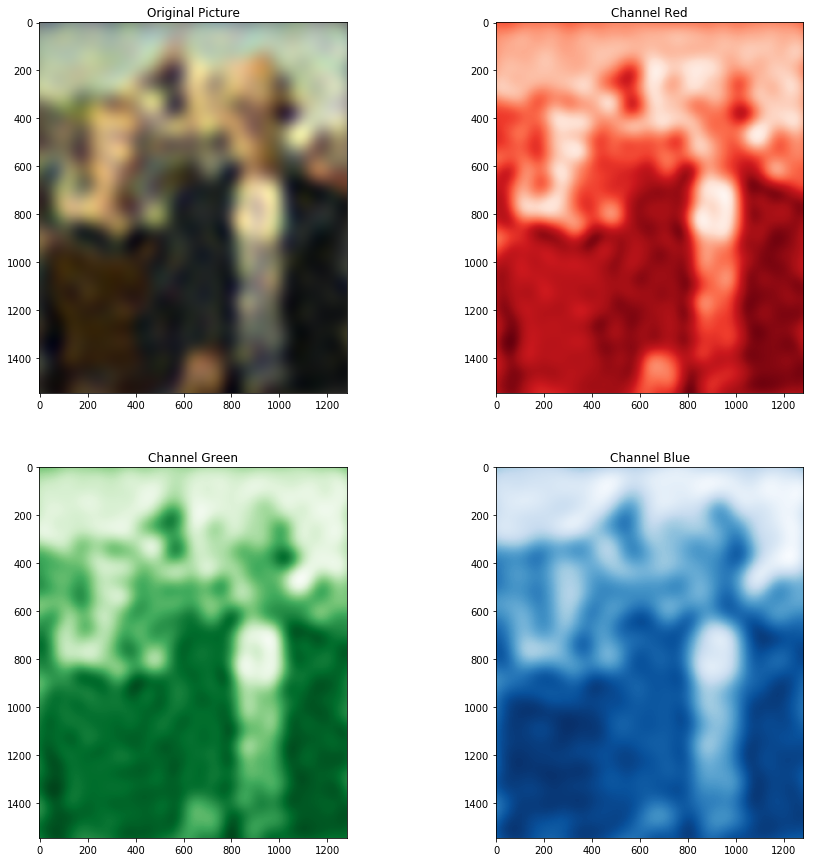

In [13]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
X_train, Y_train, X_test, Y_test = extract_dataset(photo, train_size=2000, test_size=500)

#parameters = {'kernel':['rbf', 'sigmoid'], 'C':[0.1, 1, 10, 40, 50, 70, 100], 'gamma':['auto', 0.0005, 0.01, 0.0001,0.0002, 0.0003, 0.0003, 0.00001]}
parameters = {'kernel':['rbf', 'sigmoid'], 'C':np.logspace(np.log10(0.001), np.log10(200), num=20), 'gamma':np.logspace(np.log10(0.00001), np.log10(2), num=30)}

svr_red = svm.SVR()
grid_searcher_red = GridSearchCV(svr_red, parameters, n_jobs=8, verbose=2)
grid_searcher_red.fit(X_train, Y_train[:, 0].astype(float))

svr_green = svm.SVR()
grid_searcher_green = GridSearchCV(svr_green, parameters, n_jobs=8, verbose=2)
grid_searcher_green.fit(X_train, Y_train[:, 1].astype(float))

svr_blue = svm.SVR()
grid_searcher_blue = GridSearchCV(svr_blue, parameters, n_jobs=8, verbose=2)
grid_searcher_blue.fit(X_train, Y_train[:, 2].astype(float))
log('best estimator for red channel', grid_searcher_red.best_estimator_)
log('best estimator for green channel', grid_searcher_green.best_estimator_)
log('best estimator for blue channel', grid_searcher_blue.best_estimator_)



log('Enumerate all coordinates...')
all_coordinates = np.array(list(itertools.product(np.arange(photo.shape[0]), np.arange(photo.shape[1]))))

log('Use the trained SVM models to predict all the pixels for RED...')
all_results_red = grid_searcher_red.predict(all_coordinates)
log('Use the trained SVM models to predict all the pixels for GREEN...')
all_results_green = grid_searcher_green.predict(all_coordinates)
log('Use the trained SVM models to predict all the pixels for BLUE...')
all_results_blue = grid_searcher_blue.predict(all_coordinates)

log('Reassemble an image from the predictions...')

predict = np.zeros(photo.shape)
for x in range(all_coordinates.shape[0]):
    predict[all_coordinates[x][0], all_coordinates[x][1]] = [all_results_red[x].astype(np.uint8), all_results_green[x].astype(np.uint8), all_results_blue[x].astype(np.uint8)]


show_matrix(predict.astype(np.uint8))


2018-09-06T12:01:46.392776 ---
2018-09-06T12:01:46.496903 for the point (0, 0) the model predicts colors [[128.8 139.  123.8]]
2018-09-06T12:01:46.498442 the original value was [111  96  73], equal to [111  96  73] and [128. 139. 123.]
2018-09-06T12:01:46.498543 ---
2018-09-06T12:01:46.603615 for the point (200, 200) the model predicts colors [[188.2 202.8 164.4]]
2018-09-06T12:01:46.604081 the original value was [186 207 164], equal to [186 207 164] and [188. 202. 164.]
2018-09-06T12:01:46.604131 ---
2018-09-06T12:01:46.712112 for the point (1544, 1279) the model predicts colors [[19.2 21.6 19.8]]
2018-09-06T12:01:46.713737 the original value was [2 2 2], equal to [2 2 2] and [19. 21. 19.]
2018-09-06T12:01:46.723914 ----
2018-09-06T12:01:46.724062 Image matrix of shape (1545, 1280, 3)
2018-09-06T12:01:46.815707 min/avg/max on the channels: [5 6 3]/[102.68397805  96.79359021  75.92526901]/[241 227 204]


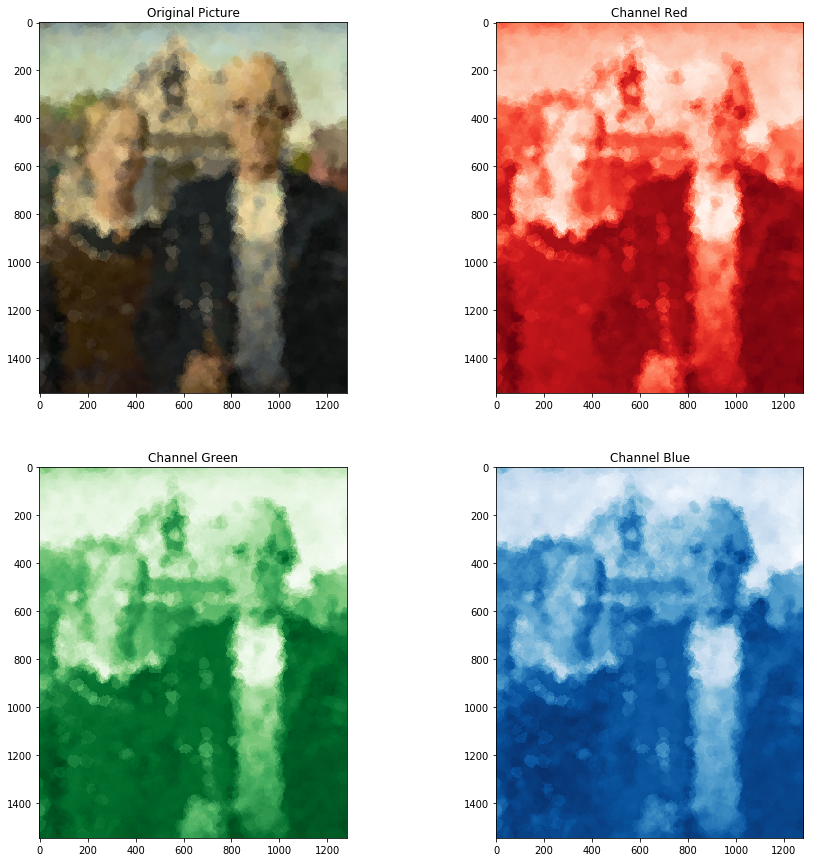

In [14]:
from sklearn import neighbors


#show_matrix(photo)


X_train, Y_train, X_test, Y_test = extract_dataset(photo, train_size=5000, test_size=0)
neighbors_model = neighbors.KNeighborsRegressor(n_neighbors=5, n_jobs=-1)
neighbors_model.fit(X_train, Y_train)

predicted = np.zeros((photo.shape[0], photo.shape[1], 3))


all_coordinates = np.array(list(itertools.product(np.arange(predicted.shape[0]),
                                                  np.arange(predicted.shape[1]))))
all_results = neighbors_model.predict(all_coordinates)

for x in range(all_coordinates.shape[0]):
    predicted[all_coordinates[x][0], all_coordinates[x][1]] = all_results[x].astype(np.uint8)

sample_points = [(0,0), (200, 200), (photo.shape[0] - 1 , photo.shape[1] -1)]
for sp in sample_points:
    log('---')
    log(f'for the point {sp} the model predicts colors {neighbors_model.predict([[sp[0], sp[1]]])}')
    log(f'the original value was {photo[sp]}, equal to {photo[sp[0], sp[1]]} and {predicted[sp]}')
    
show_matrix(predicted.astype(np.uint8))

2018-09-06T12:01:53.158187 ---
2018-09-06T12:01:53.158565 for the point (0, 0) the model predicts colors [[108. 121. 112.]]
2018-09-06T12:01:53.158837 the original value was [111  96  73], equal to [111  96  73] and [108. 121. 112.]
2018-09-06T12:01:53.158865 ---
2018-09-06T12:01:53.159057 for the point (200, 200) the model predicts colors [[189. 207. 167.]]
2018-09-06T12:01:53.159307 the original value was [186 207 164], equal to [186 207 164] and [189. 207. 167.]
2018-09-06T12:01:53.159537 ---
2018-09-06T12:01:53.159927 for the point (1544, 1279) the model predicts colors [[28. 30. 27.]]
2018-09-06T12:01:53.160275 the original value was [2 2 2], equal to [2 2 2] and [28. 30. 27.]
2018-09-06T12:01:53.167222 ----
2018-09-06T12:01:53.167315 Image matrix of shape (1545, 1280, 3)
2018-09-06T12:01:53.254927 min/avg/max on the channels: [0 1 0]/[103.70452367  97.82569124  76.98964958]/[242 229 208]


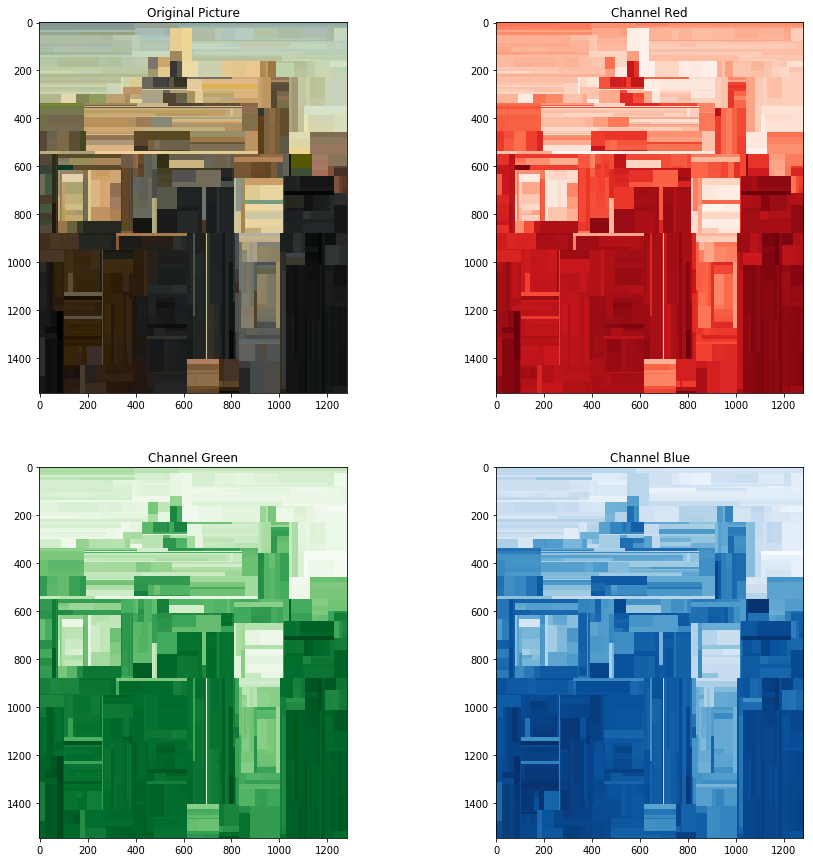

In [15]:
from sklearn import tree

X_train, Y_train, X_test, Y_test = extract_dataset(photo, train_size=1000, test_size=0)
tree_model = tree.DecisionTreeRegressor()
tree_model.fit(X_train, Y_train)

predicted = np.zeros((photo.shape[0], photo.shape[1], 3))


all_coordinates = np.array(list(itertools.product(np.arange(predicted.shape[0]), np.arange(predicted.shape[1]))))
all_results = tree_model.predict(all_coordinates)

for x in range(all_coordinates.shape[0]):
    predicted[all_coordinates[x][0], all_coordinates[x][1]] = all_results[x].astype(np.uint8)

sample_points = [(0,0), (200, 200), (photo.shape[0] - 1 , photo.shape[1] -1)]
for sp in sample_points:
    log('---')
    log(f'for the point {sp} the model predicts colors {tree_model.predict([[sp[0], sp[1]]])}')
    log(f'the original value was {photo[sp]}, equal to {photo[sp[0], sp[1]]} and {predicted[sp]}')
    
show_matrix(predicted.astype(np.uint8))

/Users/jacopo/.scientific_jupyter/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Epoch 1/400
5000/5000 [==============================] - 3s 671us/step - loss: 7345.5933
Epoch 2/400
5000/5000 [==============================] - 3s 576us/step - loss: 6392.4082
Epoch 3/400
5000/5000 [==============================] - 3s 585us/step - loss: 6337.1982
Epoch 4/400
5000/5000 [==============================] - 3s 576us/step - loss: 6361.1094
Epoch 5/400
5000/5000 [==============================] - 3s 589us/step - loss: 6337.1995
Epoch 6/400
5000/5000 [==============================] - 3s 588us/step - loss: 6301.2997
Epoch 7/400
5000/5000 [==============================] - 3s 590us/step - loss: 6289.1549
Epoch 8/400
5000/5000 [==============================] - 3s 578us/step - loss: 6298.8183
Epoch 9/400
5000/5000 [==============================] - 3s 577us/step - loss: 6243.3969
Epoch 10/400
5000/5000 [==============================] - 3s 591us/step - loss: 6212.3572
Epoch 11/400
5000/5000 [==============================] - 3s 575us/step - loss: 6183.2124
Epoch 12/400
5000/5

5000/5000 [==============================] - 3s 592us/step - loss: 753.7953
Epoch 93/400
5000/5000 [==============================] - 3s 583us/step - loss: 798.6819
Epoch 94/400
5000/5000 [==============================] - 3s 567us/step - loss: 787.0957
Epoch 95/400
5000/5000 [==============================] - 3s 591us/step - loss: 793.9376
Epoch 96/400
5000/5000 [==============================] - 3s 582us/step - loss: 766.0182
Epoch 97/400
5000/5000 [==============================] - 4s 717us/step - loss: 768.3916
Epoch 98/400
5000/5000 [==============================] - 5s 934us/step - loss: 885.8989
Epoch 99/400
5000/5000 [==============================] - 5s 966us/step - loss: 847.8693
Epoch 100/400
5000/5000 [==============================] - 5s 941us/step - loss: 741.4946
Epoch 101/400
5000/5000 [==============================] - 4s 807us/step - loss: 777.3813
Epoch 102/400
5000/5000 [==============================] - 4s 781us/step - loss: 748.4071
Epoch 103/400
5000/5000 [======

5000/5000 [==============================] - 3s 659us/step - loss: 722.8709 0s - loss: 73
Epoch 183/400
5000/5000 [==============================] - 4s 736us/step - loss: 741.7860
Epoch 184/400
5000/5000 [==============================] - 3s 699us/step - loss: 673.7481
Epoch 185/400
5000/5000 [==============================] - 4s 701us/step - loss: 692.6417
Epoch 186/400
5000/5000 [==============================] - 4s 719us/step - loss: 702.9963
Epoch 187/400
5000/5000 [==============================] - 4s 731us/step - loss: 745.6623
Epoch 188/400
5000/5000 [==============================] - 3s 700us/step - loss: 717.0064
Epoch 189/400
5000/5000 [==============================] - 4s 714us/step - loss: 717.2287
Epoch 190/400
5000/5000 [==============================] - 4s 790us/step - loss: 682.7152
Epoch 191/400
5000/5000 [==============================] - 3s 652us/step - loss: 779.4832
Epoch 192/400
5000/5000 [==============================] - 3s 580us/step - loss: 682.2673
Epoch 193/

5000/5000 [==============================] - 3s 641us/step - loss: 662.0513
Epoch 274/400
5000/5000 [==============================] - 3s 634us/step - loss: 672.3128
Epoch 275/400
5000/5000 [==============================] - 3s 596us/step - loss: 663.3266
Epoch 276/400
5000/5000 [==============================] - 3s 623us/step - loss: 732.2366
Epoch 277/400
5000/5000 [==============================] - 3s 665us/step - loss: 653.3139
Epoch 278/400
5000/5000 [==============================] - 4s 806us/step - loss: 666.8105
Epoch 279/400
5000/5000 [==============================] - 4s 702us/step - loss: 658.7131
Epoch 280/400
5000/5000 [==============================] - 3s 628us/step - loss: 639.7372
Epoch 281/400
5000/5000 [==============================] - 3s 645us/step - loss: 687.9003
Epoch 282/400
5000/5000 [==============================] - 3s 627us/step - loss: 693.4274
Epoch 283/400
5000/5000 [==============================] - 3s 620us/step - loss: 713.1183
Epoch 284/400
5000/5000 

5000/5000 [==============================] - 3s 636us/step - loss: 628.2484
Epoch 364/400
5000/5000 [==============================] - 3s 670us/step - loss: 678.7329
Epoch 365/400
5000/5000 [==============================] - 4s 710us/step - loss: 687.7330
Epoch 366/400
5000/5000 [==============================] - 3s 662us/step - loss: 638.6332
Epoch 367/400
5000/5000 [==============================] - 3s 632us/step - loss: 638.3462
Epoch 368/400
5000/5000 [==============================] - 3s 603us/step - loss: 660.5170
Epoch 369/400
5000/5000 [==============================] - 3s 605us/step - loss: 681.5380
Epoch 370/400
5000/5000 [==============================] - 3s 605us/step - loss: 647.2837
Epoch 371/400
5000/5000 [==============================] - 3s 597us/step - loss: 651.3689
Epoch 372/400
5000/5000 [==============================] - 3s 613us/step - loss: 625.8724
Epoch 373/400
5000/5000 [==============================] - 3s 637us/step - loss: 676.8422
Epoch 374/400
5000/5000 

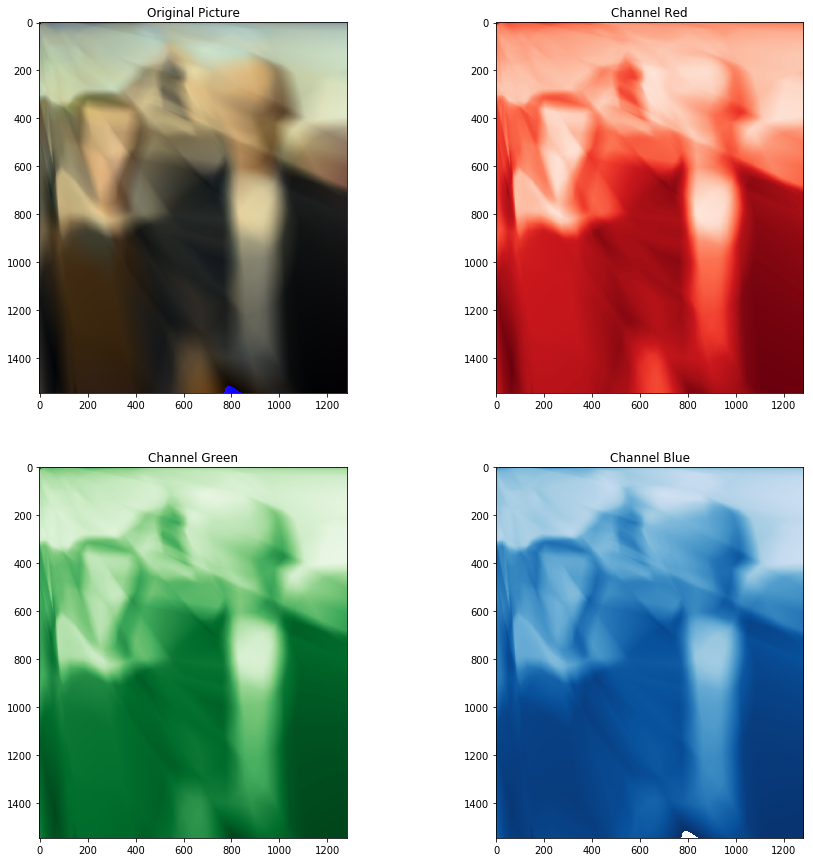

In [16]:
from keras.models import Sequential 
from keras.layers import Dense, Flatten, Dropout
import numpy as np

N_NEURONS = 1000
ACTIVATION='selu'

model = Sequential()
model.add(Dense(N_NEURONS, input_shape=(2,), activation=ACTIVATION))
model.add(Dropout(0.01))
model.add(Dense(N_NEURONS, input_shape=(N_NEURONS,), activation=ACTIVATION))
model.add(Dropout(0.01))
model.add(Dense(N_NEURONS, input_shape=(N_NEURONS,), activation=ACTIVATION))
model.add(Dense(3, input_shape=(N_NEURONS,), activation=ACTIVATION))
model.compile(optimizer='adam', loss='mse')

X_train, Y_train, X_test, Y_test = extract_dataset(photo, train_size=5000, test_size=0)

model.fit(x=X_train, y=Y_train, epochs=400)
print('Model trained')
predicted = np.zeros((photo.shape[0], photo.shape[1], 3))


all_coordinates = np.array(list(itertools.product(np.arange(predicted.shape[0]), np.arange(predicted.shape[1]))))
all_results = model.predict(all_coordinates)

for x in range(all_coordinates.shape[0]):
    predicted[all_coordinates[x][0], all_coordinates[x][1]] = all_results[x].astype(np.uint8)

sample_points = [(0,0), (200, 200), (photo.shape[0] - 1 , photo.shape[1] -1)]
for sp in sample_points:
    log('---')
    log(f'for the point {sp} the model predicts colors {predicted[sp]}')
    log(f'the original value was {photo[sp]}')
    
show_matrix(predicted.astype(np.uint8))